# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import torch
import torchvision
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np

In [2]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 33.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fakeloader mi restituisce immagini generate casualmente, cioè i pixel sono numeri random (dopo la trasformazione diventano tensori normalizzati). Le label sono anch'esse generate casualmente tra 0 e num_classes-1.
Se num_classes non viene specificato, di default è 10.

Fake_label: 9 ---> truck


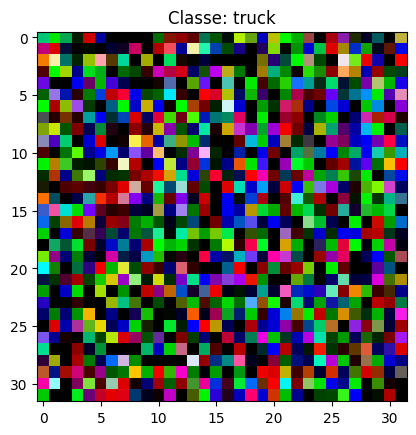

In [3]:
fake_image_batch, fake_label_batch = next(iter(fakeloader))
image_idx = 1
fake_image = fake_image_batch[image_idx]
fake_label = fake_label_batch[image_idx].item()
fake_mapped_label = classes[fake_label]
print("Fake_label:",fake_label, "--->", fake_mapped_label)
plt.imshow(fake_image.permute(1, 2, 0))
plt.title(f'Classe: {fake_mapped_label}')
plt.show()

In [4]:
# for data in fakeloader:
#     x, y = data
#     plt.imshow(x[0,:].permute(1,2,0))
#     print(classes[y[0]])
#     break


In [5]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


modifico il train-loop per renderlo più informativo

In [7]:
from tqdm import tqdm
import time

epochs = 50
best_loss = float('inf')
start_time = time.time()

for e in range(epochs):
    epoch_start = time.time()
    running_loss = 0
    num_batches = len(trainloader)

    # Progress bar per i batch nell'epoca corrente
    pbar = tqdm(trainloader, desc=f'Epoch {e+1}/{epochs}',
                leave=False, ncols=100)

    for it, data in enumerate(pbar):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)
        l = loss(yp, y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        running_loss += l.item()
        #fixare la progress bar
        pbar.set_postfix({'Loss': f'{l.item():.4f}'})

    # stats dell'epoca
    avg_loss = running_loss / num_batches
    epoch_time = time.time() - epoch_start
    total_time = time.time() - start_time

    # miglior loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = e + 1

    print(f'Epoch {e+1:2d}/{epochs} | '
          f'Avg Loss: {avg_loss:.6f} | '
          f'Best: {best_loss:.6f} (ep {best_epoch}) | '
          f'Time: {epoch_time:.1f}s | '
          f'Total: {total_time/60:.1f}m')

print(f'\nTraining completato! Tempo totale: {(time.time()-start_time)/60:.1f} minuti')
print(f'Migliore loss: {best_loss:.6f} all\'epoca {best_epoch}')

Epoch  1/50 | Avg Loss: 2.155697 | Best: 2.155697 (ep 1) | Time: 13.4s | Total: 0.2m


Epoch  2/50 | Avg Loss: 1.894480 | Best: 1.894480 (ep 2) | Time: 12.1s | Total: 0.4m


Epoch  3/50 | Avg Loss: 1.780791 | Best: 1.780791 (ep 3) | Time: 12.2s | Total: 0.6m


Epoch  4/50 | Avg Loss: 1.704983 | Best: 1.704983 (ep 4) | Time: 12.6s | Total: 0.8m


Epoch  5/50 | Avg Loss: 1.648813 | Best: 1.648813 (ep 5) | Time: 12.5s | Total: 1.0m


Epoch  6/50 | Avg Loss: 1.607842 | Best: 1.607842 (ep 6) | Time: 12.6s | Total: 1.3m


Epoch  7/50 | Avg Loss: 1.576366 | Best: 1.576366 (ep 7) | Time: 11.3s | Total: 1.4m


Epoch  8/50 | Avg Loss: 1.549022 | Best: 1.549022 (ep 8) | Time: 11.6s | Total: 1.6m


Epoch  9/50 | Avg Loss: 1.527094 | Best: 1.527094 (ep 9) | Time: 11.6s | Total: 1.8m


Epoch 10/50 | Avg Loss: 1.505901 | Best: 1.505901 (ep 10) | Time: 11.7s | Total: 2.0m


Epoch 11/50 | Avg Loss: 1.487956 | Best: 1.487956 (ep 11) | Time: 12.0s | Total: 2.2m


Epoch 12/50 | Avg Loss: 1.471608 | Best: 1.471608 (ep 12) | Time: 11.7s | Total: 2.4m


Epoch 13/50 | Avg Loss: 1.454743 | Best: 1.454743 (ep 13) | Time: 11.9s | Total: 2.6m


Epoch 14/50 | Avg Loss: 1.438088 | Best: 1.438088 (ep 14) | Time: 11.7s | Total: 2.8m


Epoch 15/50 | Avg Loss: 1.424167 | Best: 1.424167 (ep 15) | Time: 11.8s | Total: 3.0m


Epoch 16/50 | Avg Loss: 1.410107 | Best: 1.410107 (ep 16) | Time: 11.9s | Total: 3.2m


Epoch 17/50 | Avg Loss: 1.396431 | Best: 1.396431 (ep 17) | Time: 11.4s | Total: 3.4m


Epoch 18/50 | Avg Loss: 1.384119 | Best: 1.384119 (ep 18) | Time: 11.0s | Total: 3.6m


Epoch 19/50 | Avg Loss: 1.372427 | Best: 1.372427 (ep 19) | Time: 11.8s | Total: 3.8m


Epoch 20/50 | Avg Loss: 1.360797 | Best: 1.360797 (ep 20) | Time: 11.8s | Total: 4.0m


Epoch 21/50 | Avg Loss: 1.349737 | Best: 1.349737 (ep 21) | Time: 12.0s | Total: 4.2m


Epoch 22/50 | Avg Loss: 1.338964 | Best: 1.338964 (ep 22) | Time: 11.9s | Total: 4.4m


Epoch 23/50 | Avg Loss: 1.329913 | Best: 1.329913 (ep 23) | Time: 11.8s | Total: 4.6m


Epoch 24/50 | Avg Loss: 1.317932 | Best: 1.317932 (ep 24) | Time: 12.2s | Total: 4.8m


Epoch 25/50 | Avg Loss: 1.308501 | Best: 1.308501 (ep 25) | Time: 11.9s | Total: 5.0m


Epoch 26/50 | Avg Loss: 1.302269 | Best: 1.302269 (ep 26) | Time: 12.0s | Total: 5.2m


Epoch 27/50 | Avg Loss: 1.292892 | Best: 1.292892 (ep 27) | Time: 11.8s | Total: 5.4m


Epoch 28/50 | Avg Loss: 1.285298 | Best: 1.285298 (ep 28) | Time: 11.6s | Total: 5.6m


Epoch 29/50 | Avg Loss: 1.277352 | Best: 1.277352 (ep 29) | Time: 11.7s | Total: 5.8m


Epoch 30/50 | Avg Loss: 1.269323 | Best: 1.269323 (ep 30) | Time: 11.6s | Total: 5.9m


Epoch 31/50 | Avg Loss: 1.263191 | Best: 1.263191 (ep 31) | Time: 11.7s | Total: 6.1m


Epoch 32/50 | Avg Loss: 1.252870 | Best: 1.252870 (ep 32) | Time: 11.9s | Total: 6.3m


Epoch 33/50 | Avg Loss: 1.248385 | Best: 1.248385 (ep 33) | Time: 11.9s | Total: 6.5m


Epoch 34/50 | Avg Loss: 1.240692 | Best: 1.240692 (ep 34) | Time: 12.2s | Total: 6.7m


Epoch 35/50 | Avg Loss: 1.234250 | Best: 1.234250 (ep 35) | Time: 11.9s | Total: 6.9m


Epoch 36/50 | Avg Loss: 1.229093 | Best: 1.229093 (ep 36) | Time: 11.9s | Total: 7.1m


Epoch 37/50 | Avg Loss: 1.221826 | Best: 1.221826 (ep 37) | Time: 12.1s | Total: 7.3m


Epoch 38/50 | Avg Loss: 1.215380 | Best: 1.215380 (ep 38) | Time: 11.8s | Total: 7.5m


Epoch 39/50 | Avg Loss: 1.210061 | Best: 1.210061 (ep 39) | Time: 11.1s | Total: 7.7m


Epoch 40/50 | Avg Loss: 1.204142 | Best: 1.204142 (ep 40) | Time: 11.4s | Total: 7.9m


Epoch 41/50 | Avg Loss: 1.197577 | Best: 1.197577 (ep 41) | Time: 11.6s | Total: 8.1m


Epoch 42/50 | Avg Loss: 1.193282 | Best: 1.193282 (ep 42) | Time: 11.9s | Total: 8.3m


Epoch 43/50 | Avg Loss: 1.188313 | Best: 1.188313 (ep 43) | Time: 11.8s | Total: 8.5m


Epoch 44/50 | Avg Loss: 1.182749 | Best: 1.182749 (ep 44) | Time: 11.8s | Total: 8.7m


Epoch 45/50 | Avg Loss: 1.177215 | Best: 1.177215 (ep 45) | Time: 11.9s | Total: 8.9m


Epoch 46/50 | Avg Loss: 1.172759 | Best: 1.172759 (ep 46) | Time: 11.9s | Total: 9.1m


Epoch 47/50 | Avg Loss: 1.167193 | Best: 1.167193 (ep 47) | Time: 11.9s | Total: 9.3m


Epoch 48/50 | Avg Loss: 1.161304 | Best: 1.161304 (ep 48) | Time: 11.7s | Total: 9.5m


Epoch 49/50 | Avg Loss: 1.158942 | Best: 1.158942 (ep 49) | Time: 11.1s | Total: 9.7m


Epoch 50/50 | Avg Loss: 1.152553 | Best: 1.152553 (ep 50) | Time: 11.5s | Total: 9.9m

Training completato! Tempo totale: 9.9 minuti
Migliore loss: 1.152553 all'epoca 50


In [8]:
torch.save(model.state_dict(), './cifar10_CNN_2.pth')

In [9]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = CNN().to(device)
#model.load_state_dict(torch.load('./cifar10_CNN_new.pth')) #fully trained
model.load_state_dict(torch.load('./cifar10_CNN_2.pth')) #50 epochs


<All keys matched successfully>

In [10]:
#here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)


Accuracy: 0.5662999749183655


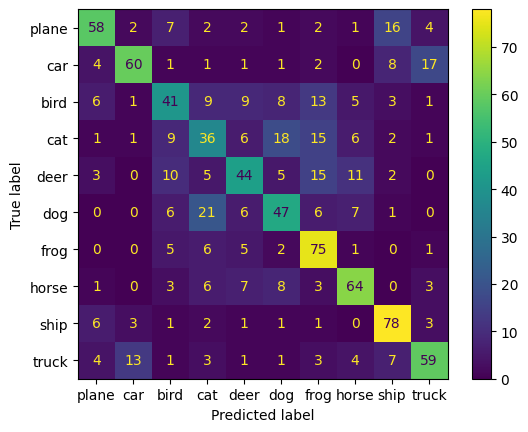

In [11]:
#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')
from sklearn import metrics

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=classes)
disp.plot()
plt.show()


tensor(7, device='cuda:0')


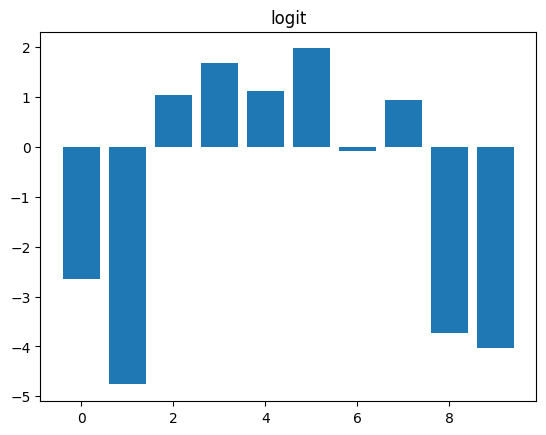

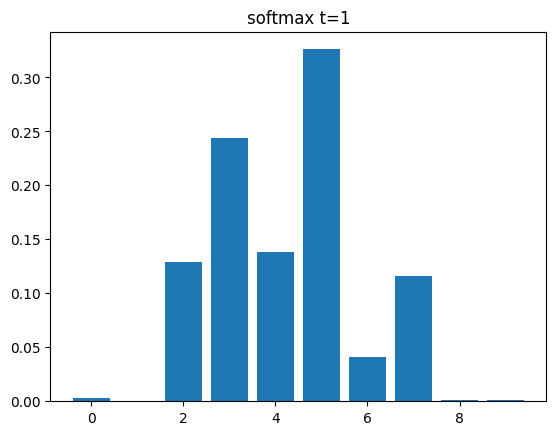

In [12]:
#Example of logit and softmax output
print(y[0])
output = model(x)
plt.bar(np.arange(10),output[0].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[0].detach().cpu())
plt.show()




REMEMBER:

softmax standard: $$p_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

softmax con temperature: $$p_i(T) = \frac{e^{z_i / T}}{\sum_{j=1}^{K} e^{z_j / T}}$$

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


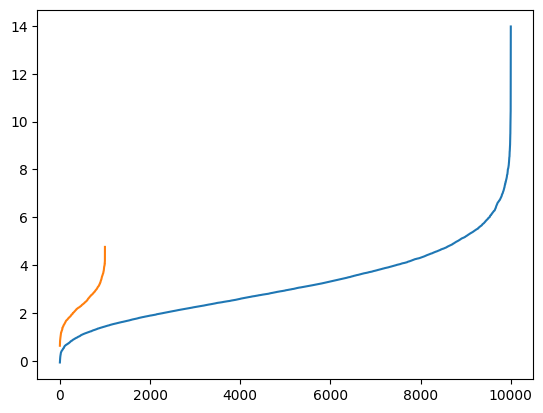

In [13]:
def max_logit(logit):
    s = logit.max(dim=1)[0]
    return s #ottengo un vettore di dimensione batch size che contiene i valori di logit più grandi per ogni immaigne

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0]
    return s #ottengo un vettore di dimensione batch size che contiene i valori di probabilità max (softmax dei logit) più grandi per ogni immaigne


def compute_scores(data_loader, score_fun, model):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device)) #eseguo modello su tutto il ds
            s = score_fun(output) #calcolo lo score che ho scelto --> vettore di dim batch_size
            scores.append(s)
        scores_t = torch.cat(scores) #tensore monodimensionale
        # print(scores_t)
        return scores_t


scores_test = compute_scores(testloader, max_logit, model)
scores_fake = compute_scores(fakeloader, max_logit, model)


plt.plot(sorted(scores_test.cpu()))
plt.plot(sorted(scores_fake.cpu()))


Linea blu: tutti gli score delle immagini di test, cresce più lentamente e arriva a valori molto più alti (maggiori di 10 perché usaimo i logit non normalizzati) => per le immagini di CIFAR-10 il modello produce logit molto alti => alta confidenza

Linea arancione: tutti gli score delle immagini fake / OOD, rimane più bassa e cresce più in fretta => significa che il modello, su dati OOD, produce logit massimi generalmente più bassi => bassa confidenza

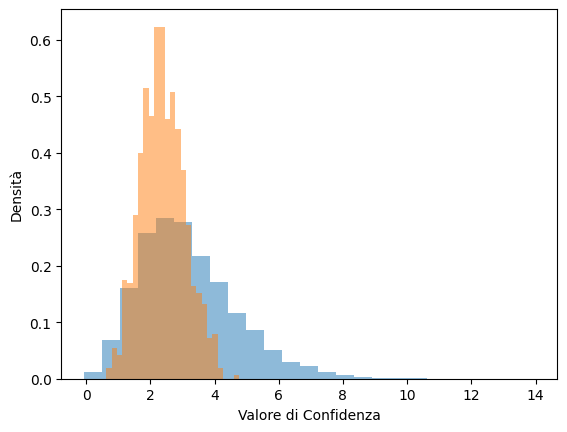

In [14]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25)
plt.xlabel('Valore di Confidenza')
plt.ylabel('Densità')
plt.show()

Distribuzione dei punteggi:possiamo vedere che il modello rimane su valori di confidenza più bassi per le immagini OOD, mentre aumenta i suoi valori di confidenza (riesce anche ad arrivare a valori prossimi a 10 in questo caso) per le immagini che conosce

Proviamo ad utilizzare le probabilità

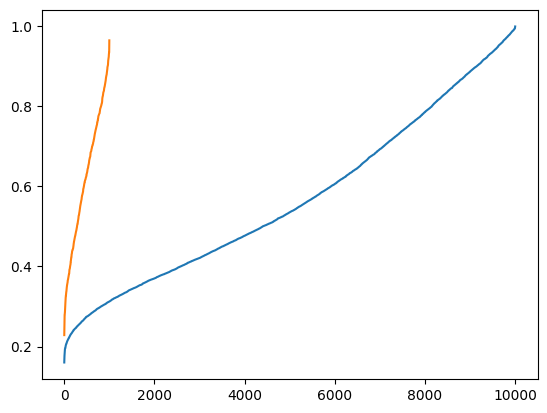

In [15]:
scores_test = compute_scores(testloader, max_softmax, model)
scores_fake = compute_scores(fakeloader, max_softmax, model)


plt.plot(sorted(scores_test.cpu()))
plt.plot(sorted(scores_fake.cpu()))

Proviamo a giocare con la temperatura:

*   T=1 -> normale softmax
*   T>1 -> distribuzione più piatta: le probabilità diventano più uniformi, il modello appare meno sicuro (confidence più bassa)
*   𝑇<1 -> distribuzione più “aggressiva”: la classe più grande diventa ancora più dominante, il modello appare più sicuro (confidence più alta).




Linea blu: arriva fino a 1 perché il modello assegna confidenza 100% ad alcune immagini

Linea arancione: rimane più bassa sempre per una questione di confidence

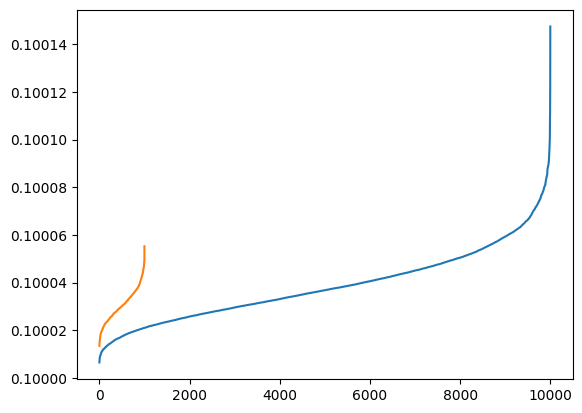

In [16]:
temp=10000
scores_test_temp = compute_scores(testloader, lambda l: max_softmax(l, T=temp), model)
scores_fake_temp = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp), model)
plt.plot(sorted(scores_test_temp.cpu()))
plt.plot(sorted(scores_fake_temp.cpu()))

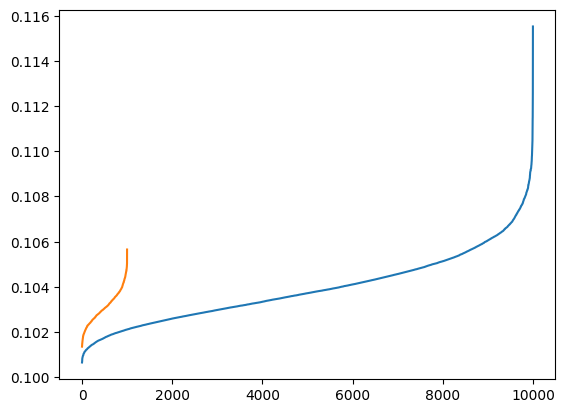

In [17]:
temp=100
scores_test_temp = compute_scores(testloader, lambda l: max_softmax(l, T=temp), model)
scores_fake_temp = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp), model)
plt.plot(sorted(scores_test_temp.cpu()))
plt.plot(sorted(scores_fake_temp.cpu()))

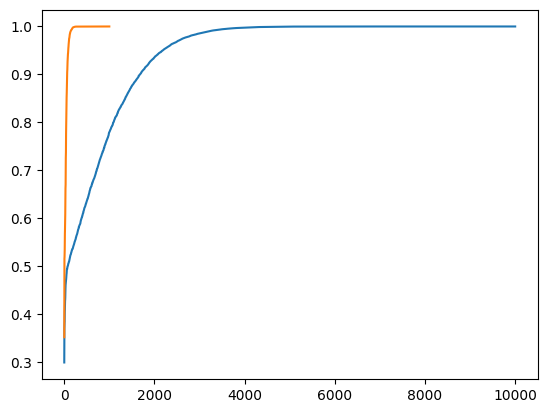

In [18]:
temp=0.1
scores_test_temp = compute_scores(testloader, lambda l: max_softmax(l, T=temp), model)
scores_fake_temp = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp), model)
plt.plot(sorted(scores_test_temp.cpu()))
plt.plot(sorted(scores_fake_temp.cpu()))

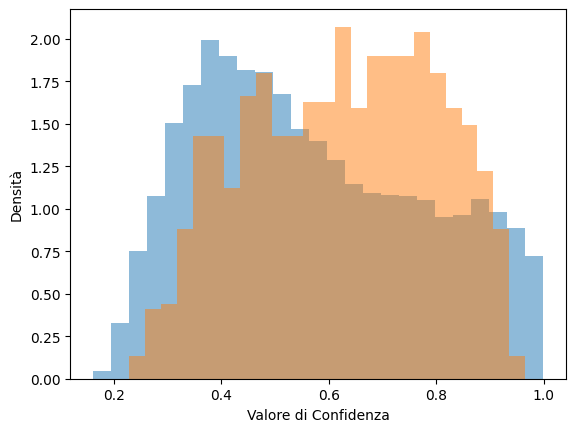

In [19]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25)
plt.xlabel('Valore di Confidenza')
plt.ylabel('Densità')
plt.show()


In [20]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        #2x32x32 -> 48x4x4
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

Autoencoder

Encoder (fase di compressione):
2x32x32 -> conv2d(3->12)+stride=2 -> 12x16x26
12x16x16 -> conv2d(12->24)+stride=2 -> 24x8x8
24x8x8 -> conv2d(24->48)+stride=2 -> 48x4x4

Decoder(ricostruzione):
48x4x4 -> convTranspose2d(48->24)+stride=2 -> 24x8x8
24x8x8 -> convTranspose2d(24->12)+stride=2 -> 12x16x16
12x16x16 -> convTranspose2d(12->3)+stride=2 -> 3x32x32


In teoria questo tipo di architettura è utile poichè viene trainato a ricostruire i dati noti, se gli diamo un'immagine OOD la ricostruzione sarà scarsa

In [21]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [22]:
epochs = 20
best_loss = float('inf')
start_time = time.time()

for e in range(epochs):
    epoch_start = time.time()
    running_loss = 0
    num_batches = len(trainloader)

    # Progress bar per i batch nell'epoca corrente
    pbar = tqdm(trainloader, desc=f'Epoch {e+1}/{epochs}',
                leave=False, ncols=100)

    for it, data in enumerate(pbar):
        x, y = data
        x = x.to(device)

        _, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        running_loss += l.item()
        #fixare la progress bar
        pbar.set_postfix({'Loss': f'{l.item():.4f}'})

    # stats dell'epoca
    avg_loss = running_loss / num_batches
    epoch_time = time.time() - epoch_start
    total_time = time.time() - start_time

    # miglior loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = e + 1

    print(f'Epoch {e+1:2d}/{epochs} | '
          f'Avg Loss: {avg_loss:.6f} | '
          f'Best: {best_loss:.6f} (ep {best_epoch}) | '
          f'Time: {epoch_time:.1f}s | '
          f'Total: {total_time/60:.1f}m')

print(f'\nTraining completato! Tempo totale: {(time.time()-start_time)/60:.1f} minuti')
print(f'Migliore loss: {best_loss:.6f} all\'epoca {best_epoch}')

Epoch  1/20 | Avg Loss: 0.379384 | Best: 0.379384 (ep 1) | Time: 11.7s | Total: 0.2m


Epoch  2/20 | Avg Loss: 0.222751 | Best: 0.222751 (ep 2) | Time: 11.5s | Total: 0.4m


Epoch  3/20 | Avg Loss: 0.206160 | Best: 0.206160 (ep 3) | Time: 11.7s | Total: 0.6m


Epoch  4/20 | Avg Loss: 0.198807 | Best: 0.198807 (ep 4) | Time: 11.3s | Total: 0.8m


Epoch  5/20 | Avg Loss: 0.192765 | Best: 0.192765 (ep 5) | Time: 11.3s | Total: 1.0m


Epoch  6/20 | Avg Loss: 0.185358 | Best: 0.185358 (ep 6) | Time: 11.5s | Total: 1.1m


Epoch  7/20 | Avg Loss: 0.178589 | Best: 0.178589 (ep 7) | Time: 10.4s | Total: 1.3m


Epoch  8/20 | Avg Loss: 0.174615 | Best: 0.174615 (ep 8) | Time: 11.3s | Total: 1.5m


Epoch  9/20 | Avg Loss: 0.172001 | Best: 0.172001 (ep 9) | Time: 11.6s | Total: 1.7m


Epoch 10/20 | Avg Loss: 0.170240 | Best: 0.170240 (ep 10) | Time: 11.2s | Total: 1.9m


Epoch 11/20 | Avg Loss: 0.168707 | Best: 0.168707 (ep 11) | Time: 11.6s | Total: 2.1m


Epoch 12/20 | Avg Loss: 0.167512 | Best: 0.167512 (ep 12) | Time: 11.3s | Total: 2.3m


Epoch 13/20 | Avg Loss: 0.166298 | Best: 0.166298 (ep 13) | Time: 11.4s | Total: 2.5m


Epoch 14/20 | Avg Loss: 0.165063 | Best: 0.165063 (ep 14) | Time: 11.2s | Total: 2.6m


Epoch 15/20 | Avg Loss: 0.162859 | Best: 0.162859 (ep 15) | Time: 10.5s | Total: 2.8m


Epoch 16/20 | Avg Loss: 0.161365 | Best: 0.161365 (ep 16) | Time: 11.3s | Total: 3.0m


Epoch 17/20 | Avg Loss: 0.160377 | Best: 0.160377 (ep 17) | Time: 11.6s | Total: 3.2m


Epoch 18/20 | Avg Loss: 0.159662 | Best: 0.159662 (ep 18) | Time: 11.3s | Total: 3.4m


Epoch 19/20 | Avg Loss: 0.159015 | Best: 0.159015 (ep 19) | Time: 11.2s | Total: 3.6m


Epoch 20/20 | Avg Loss: 0.158414 | Best: 0.158414 (ep 20) | Time: 11.4s | Total: 3.8m

Training completato! Tempo totale: 3.8 minuti
Migliore loss: 0.158414 all'epoca 20


In [23]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x) #xr è la ricostruzione, la mia metrica stavolta è la differenza tra l'immagine ricostruita e quella originale
        l = loss(x, xr) #errore di ricostruzione per pixel -> tensore [natch,C,H,W]
        score = l.mean([1,2,3]) #media su canali e dimensioni -> otteniamo un valore unico
        scores_fake_ae.append(-score) # lo neghiamo, come detto sopra, poichè più l'errore è grande più siamo in OOD,
                                      # ma in OOD detection si tende a lavorare con score maggiore = più in_distribution

scores_fake_ae = torch.cat(scores_fake_ae)



scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)

scores_test_ae = torch.cat(scores_test_ae)



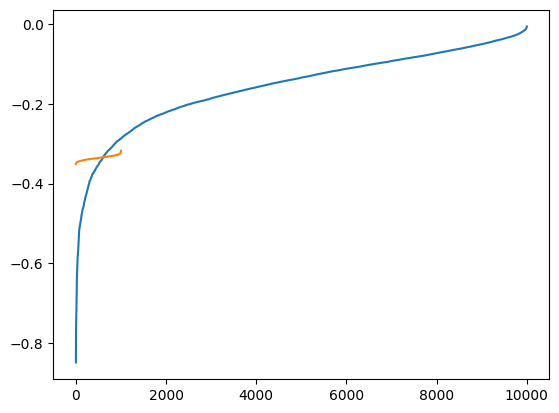

In [24]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))


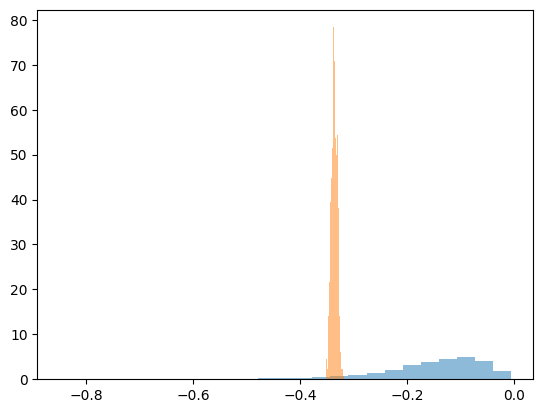

In [25]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

Possiamo vedere come l'autoencoder faccia fatica a ricostruire input OOD => in questo caso l'autoencoder è meglio nella OOD detection, probabilmente anche grazie al fatto che gli OOD input sono molto diversi

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



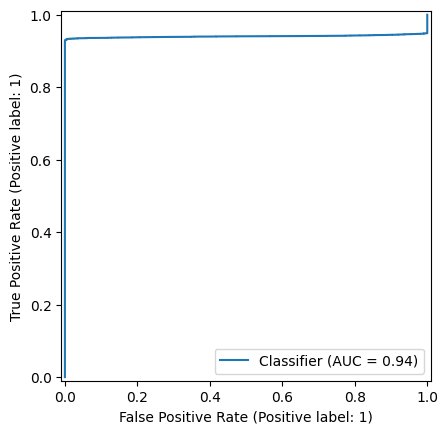

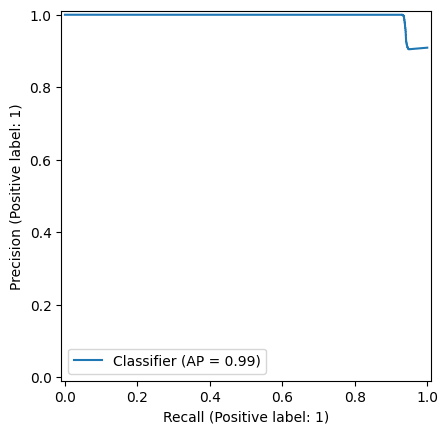

In [26]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())
metrics.PrecisionRecallDisplay.from_predictions(y.cpu(), ypred.cpu())

Dalla ROC AUC vediamo che l'Autoencoder separa bene gli OOD dagli iD
La Average Precision (area sotto la curva precision recall) non è molto indicativa, poichè abbiamo un dataset sbilanciato (1000 OOD e 10000 ID)

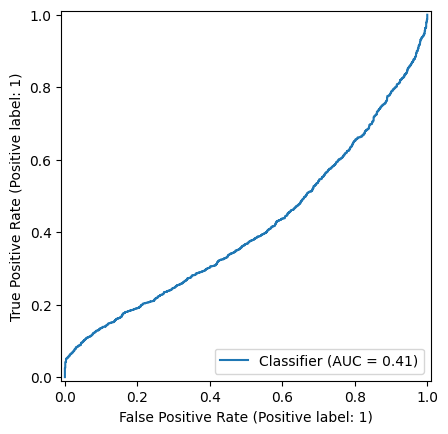

In [27]:
#softmax performance della cnn
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

La cnn è abbastanza scarsa invece probabilmente a causa della semplicità della rete. Proviamo con una resnet20 pre-traianto su cifar10

In [28]:
model_pretrained = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model_pretrained.eval()
model_pretrained.to(device)

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt


100%|██████████| 1.09M/1.09M [00:00<00:00, 32.3MB/s]


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.8112999796867371


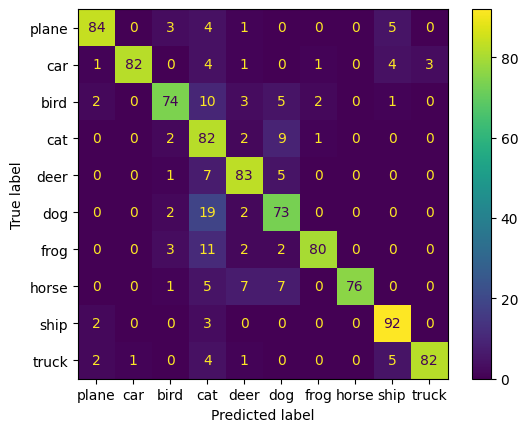

In [29]:
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model_pretrained(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')
from sklearn import metrics

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=classes)
disp.plot()
plt.show()

tensor(7, device='cuda:0')


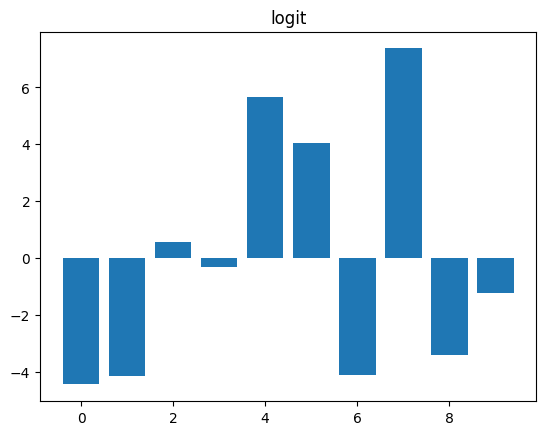

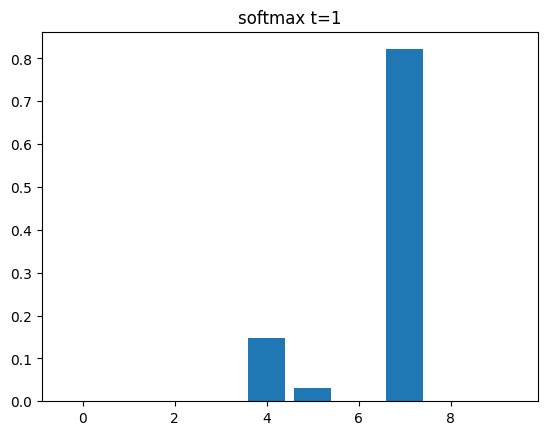

In [30]:
#Example of logit and softmax output
print(y[0])
output = model_pretrained(x)
plt.bar(np.arange(10),output[0].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[0].detach().cpu())
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


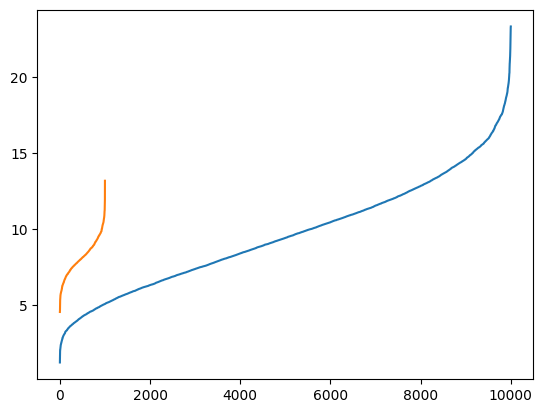

In [31]:
scores_test = compute_scores(testloader, max_logit, model_pretrained)
scores_fake = compute_scores(fakeloader, max_logit, model_pretrained)


plt.plot(sorted(scores_test.cpu()))
plt.plot(sorted(scores_fake.cpu()))

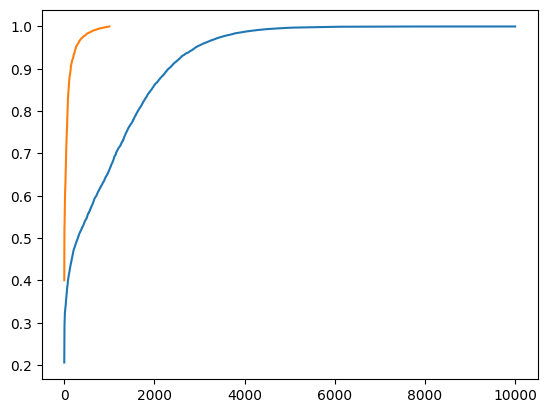

In [32]:
scores_test = compute_scores(testloader, max_softmax, model_pretrained)
scores_fake = compute_scores(fakeloader, max_softmax, model_pretrained)


plt.plot(sorted(scores_test.cpu()))
plt.plot(sorted(scores_fake.cpu()))

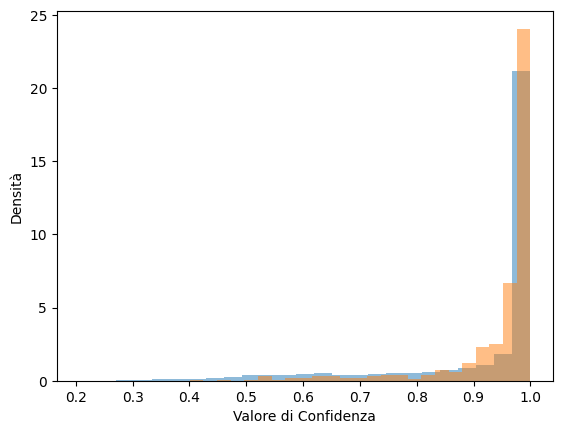

In [33]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25)
plt.xlabel('Valore di Confidenza')
plt.ylabel('Densità')
plt.show()

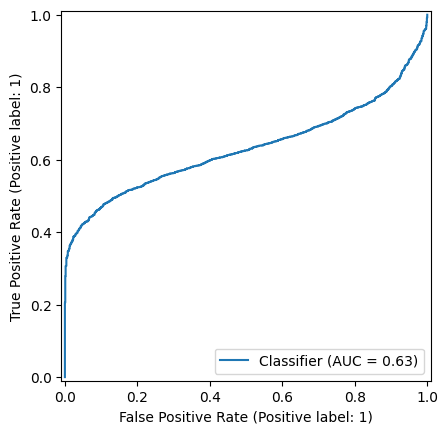

In [34]:
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [35]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [36]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [37]:
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


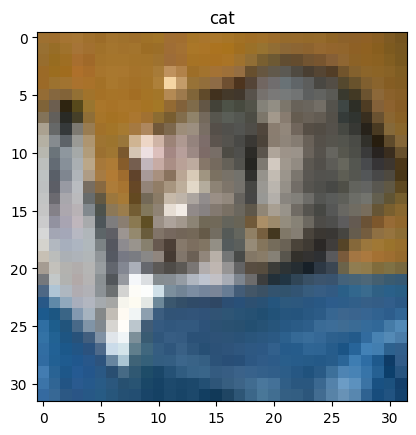

Attack!!
target class: deer
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
4 3
Targeted attack(deer) success! budget:13/255


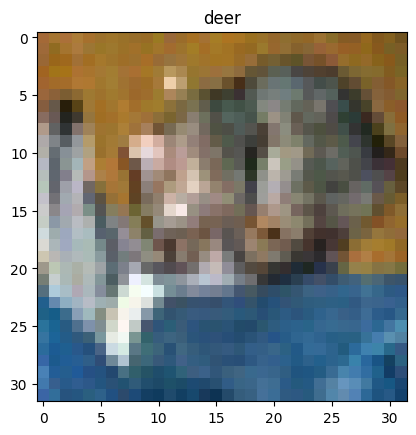

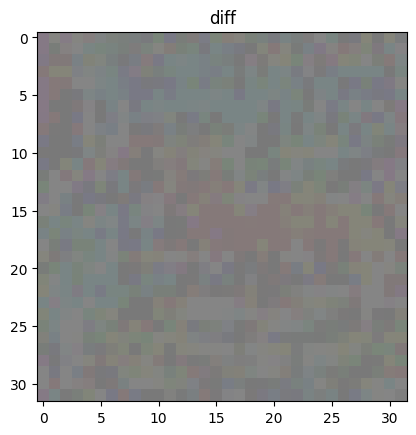

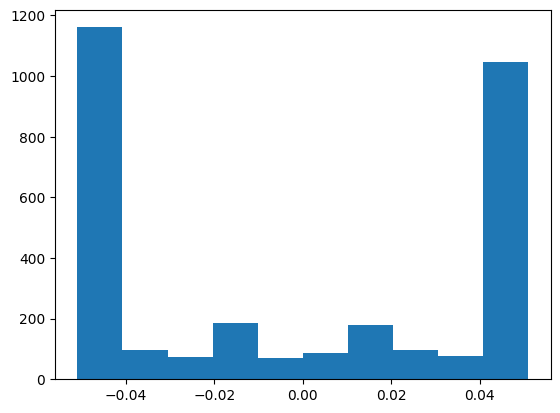

In [38]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer']
eps = 1/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:] #aggiunta dimensione alla x -> pytorch si aspetta comunque un batch, anche se è una sola immagine
y = y[None] #stessa cosa per la label

x.requires_grad=True  #fondamentale! Permette di calcolare la direzione di vulnerabilità del modello
#print(x)

before = x.clone() #copia dell'immagine (tensore) prima dell'attacco
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:  #controlliamo se il modello sbagli già di suo la predizione oppure se la classe reale è la stessa della target
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).to(device) #crea un tensore per l'etichetta target, aggiunge una dimensione (per il formato batch) e lo sposta sul device
        print(f'target class: {testset.classes[target.squeeze()]}')

    while not done: #untargeted attack until success!


        x.retain_grad() #per la conservazione dei gradienti, dato che faremo più iterazioni

        output=model(x) #forward

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted -> calcolo la loss rispetto all'etichetta target e la minimizzo
        else:
            yt=y #untargeted -> calcolo la loss rispetto all'etichetta vera e massimizzo la loss

        l = loss(output,yt)
        l.backward()


        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted -> per quanto detto sopra, ovvero che nel caso targeted minimizziamo la loss, si sposta l'immagine nella direzione opposta al grad
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted -> qui invece massimizziamo la loss, non abbiamo un target, vogliamo solo che sbagli

        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item(): #successo untarget -> predizione modello != predizione vero
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True

        if targeted_attack and output.argmax().item() == target: #successo traget -> predizione modello = predizione target

            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True


    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())







L'ultimo istogramma ci mostra la distribuzione dei cambiamenti applicati ai singoli pixel:

*   asse x: Rappresenta il valore del cambiamento che ogni pixel ha subìto;
*   asse y: Rappresenta il numero di pixel che hanno quel determinato valore di cambiamento



Dall'istogramma sopra vediamo che pochi pixel hanno subito cambiamenti lievi o nulli

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


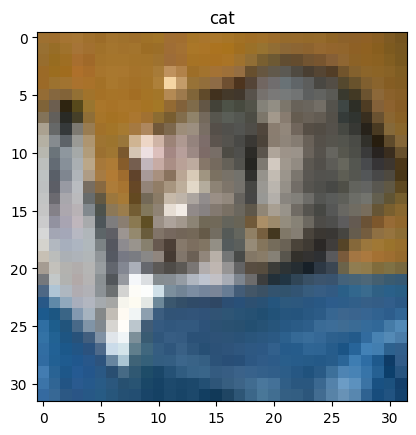

Attack!!
target class: deer
3 3
3 3
3 3
4 3
Targeted attack(deer) success! budget:4/255


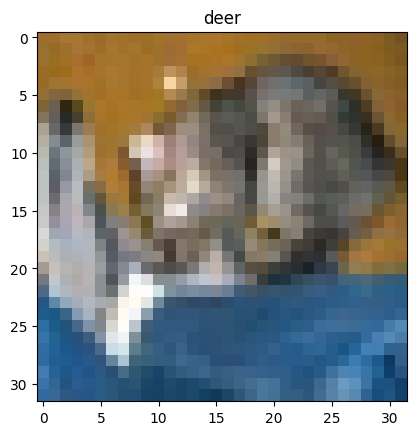

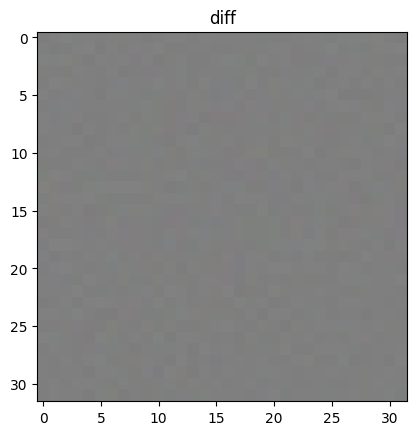

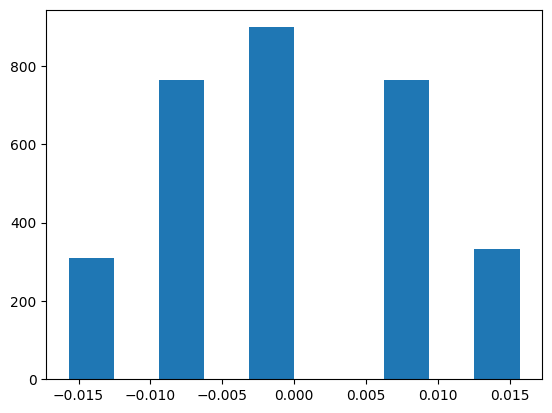

In [39]:
loss =  nn.CrossEntropyLoss()
model_pretrained.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer']
eps = 1/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:] #aggiunta dimensione alla x -> pytorch si aspetta comunque un batch, anche se è una sola immagine
y = y[None] #stessa cosa per la label

x.requires_grad=True  #fondamentale! Permette di calcolare la direzione di vulnerabilità del modello
#print(x)

before = x.clone() #copia dell'immagine (tensore) prima dell'attacco
output=model_pretrained(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:  #controlliamo se il modello sbagli già di suo la predizione oppure se la classe reale è la stessa della target
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).to(device) #crea un tensore per l'etichetta target, aggiunge una dimensione (per il formato batch) e lo sposta sul device
        print(f'target class: {testset.classes[target.squeeze()]}')

    while not done: #untargeted attack until success!


        x.retain_grad() #per la conservazione dei gradienti, dato che faremo più iterazioni (forse)

        output=model_pretrained(x) #forward

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted -> calcolo la loss rispetto all'etichetta target e la minimizzo
        else:
            yt=y #untargeted -> calcolo la loss rispetto all'etichetta vera e massimizzo la loss

        l = loss(output,yt)
        l.backward()


        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted -> per quanto detto sopra, ovvero che nel caso targeted minimizziamo la loss, si sposta l'immagine nella direzione opposta al grad
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted -> qui invece massimizziamo la loss, non abbiamo un target, vogliamo solo che sbagli

        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item(): #successo untarget -> predizione modello != predizione vero
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True

        if targeted_attack and output.argmax().item() == target: #successo traget -> predizione modello = predizione target

            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True


    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())







Possimao notare che, nel caso della rete pre_trained, pochi pixel hanno subito cambiamenti "pesanti", rimanendo comunque tra -0.016 e 0.016 (prima eravamo tra -0.05 e 0.05)

Inoltre il modello pre-addestrato è stato attaccato con successo con una perturbazione molto più piccola (lo vedevamo già dal budget) rispetto al modello addestrato da zero e poco efficiente. Questo è probabilmente dovuto al fatto che il modello pre-addestrato ha già imparato a riconoscere le caratteristiche essenziali delle immagini, ma questo lo rende anche più vulnerabile poichè un modello migliore non ha bisogno di grandi modifiche ai pixel per cambiare idea!

In [41]:
# FGSM one-step: prende un batch x,y e restituisce x_adv (same device, same shape)
def fgsm_one_step(model, x, y, eps):

    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True

    output = model(x_adv)
    loss = F.cross_entropy(output, y)
    model.zero_grad()
    loss.backward()

    grad_sign = x_adv.grad.data.sign() #tensore con stessa shape di x fatto da -1 e 1
    x_adv = x_adv + eps * grad_sign #perturbazione

    x_adv = torch.clamp(x_adv, -1.0, 1.0) #riportiamo i valori dei pixel dentro al dominio normalizzato -> la perturbazione può spingere alcuni pixel fuori da [-1.1]

    return x_adv.detach()

# Evaluate sul dataloader, avviene se epsilon è 0 (nessun attacco)
def eval_clean_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# Qui invece attacchiamo le immagini e vediamo come si comporta la rete
def eval_fgsm_accuracy(model, dataloader, eps):
    model.eval()
    correct = 0
    total = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        # create adversarial batch
        x_adv = fgsm_one_step(model, x, y, eps)
        with torch.no_grad():
            output = model(x_adv)
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# funzione per socrrere gli epsilon e salvare i risultati
def compute_accuracies_vs_eps(model, dataloader, epsilons):
    results = {}
    # optionally compute clean once (eps=0)
    if 0.0 in epsilons:
        results[0.0] = eval_clean_accuracy(model, dataloader)
    for eps in epsilons:
        if eps == 0.0:
            continue
        acc = eval_fgsm_accuracy(model, dataloader, eps)
        results[eps] = acc
    return results


In [42]:
# Assicurati che il modello sia sul device e in eval mode
model_pretrained.to(device)
model_pretrained.eval()

epsilons = [0.0, 1/255, 2/255, 4/255, 8/255, 16/255]   # prova questa scala
results = compute_accuracies_vs_eps(model_pretrained, testloader, epsilons)

# stampa i risultati
for eps, acc in results.items():
    print(f"eps={eps:.4f} -> accuracy={acc*100:.2f}%")


eps=0.0000 -> accuracy=83.10%
eps=0.0039 -> accuracy=55.32%
eps=0.0078 -> accuracy=35.52%
eps=0.0157 -> accuracy=20.31%
eps=0.0314 -> accuracy=14.09%
eps=0.0627 -> accuracy=11.82%


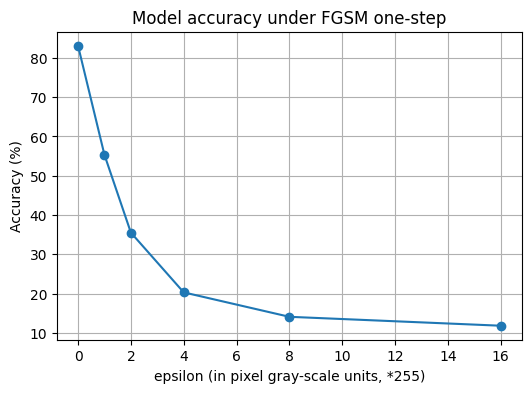

In [43]:
eps_vals = sorted(results.keys())
accs = [results[e] for e in eps_vals]

plt.figure(figsize=(6,4))
plt.plot([e*255 for e in eps_vals], [a*100 for a in accs], marker='o')  # x in [0..255] units
plt.xlabel("epsilon (in pixel gray-scale units, *255)")
plt.ylabel("Accuracy (%)")
plt.title("Model accuracy under FGSM one-step")
plt.grid(True)
plt.show()


### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [45]:
eps = 1/255
num_epochs = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=1e-4)

# Assicuriamoci che il modello sia in train
model_pretrained.train()

for epoch in range(num_epochs):
    running_loss = 0
    for x, y in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)

        # === FGSM on-the-fly ===
        x_adv = x.clone().detach()
        x_adv.requires_grad = True

        logits = model_pretrained(x_adv)
        loss = loss_fn(logits, y)
        model_pretrained.zero_grad()
        loss.backward()

        # genera gli adversarial
        x_adv = x_adv + eps * x_adv.grad.sign()
        x_adv = torch.clamp(x_adv, -1.0, 1.0)  # range normalizzato

        optimizer.zero_grad()

        x_combined = torch.cat([x, x_adv], dim=0)
        y_combined = torch.cat([y, y], dim=0)

        logits_combined = model_pretrained(x_combined)
        loss_combined = loss_fn(logits_combined, y_combined)

        loss_combined.backward()
        optimizer.step()

        running_loss += loss_combined.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")


Epoch 1/25:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/25: 100%|██████████| 196/196 [00:44<00:00,  4.37it/s]


Epoch 1, Avg Loss: 0.2703


Epoch 2/25: 100%|██████████| 196/196 [00:44<00:00,  4.37it/s]


Epoch 2, Avg Loss: 0.1466


Epoch 3/25: 100%|██████████| 196/196 [00:44<00:00,  4.40it/s]


Epoch 3, Avg Loss: 0.1141


Epoch 4/25: 100%|██████████| 196/196 [00:45<00:00,  4.34it/s]


Epoch 4, Avg Loss: 0.0939


Epoch 5/25: 100%|██████████| 196/196 [00:44<00:00,  4.42it/s]


Epoch 5, Avg Loss: 0.0792


Epoch 6/25: 100%|██████████| 196/196 [00:44<00:00,  4.40it/s]


Epoch 6, Avg Loss: 0.0691


Epoch 7/25: 100%|██████████| 196/196 [00:44<00:00,  4.42it/s]


Epoch 7, Avg Loss: 0.0609


Epoch 8/25: 100%|██████████| 196/196 [00:44<00:00,  4.41it/s]


Epoch 8, Avg Loss: 0.0535


Epoch 9/25: 100%|██████████| 196/196 [00:44<00:00,  4.39it/s]


Epoch 9, Avg Loss: 0.0476


Epoch 10/25: 100%|██████████| 196/196 [00:44<00:00,  4.42it/s]


Epoch 10, Avg Loss: 0.0421


Epoch 11/25: 100%|██████████| 196/196 [00:45<00:00,  4.35it/s]


Epoch 11, Avg Loss: 0.0373


Epoch 12/25: 100%|██████████| 196/196 [00:44<00:00,  4.41it/s]


Epoch 12, Avg Loss: 0.0328


Epoch 13/25: 100%|██████████| 196/196 [00:44<00:00,  4.42it/s]


Epoch 13, Avg Loss: 0.0304


Epoch 14/25:  61%|██████    | 119/196 [00:27<00:17,  4.35it/s]


KeyboardInterrupt: 

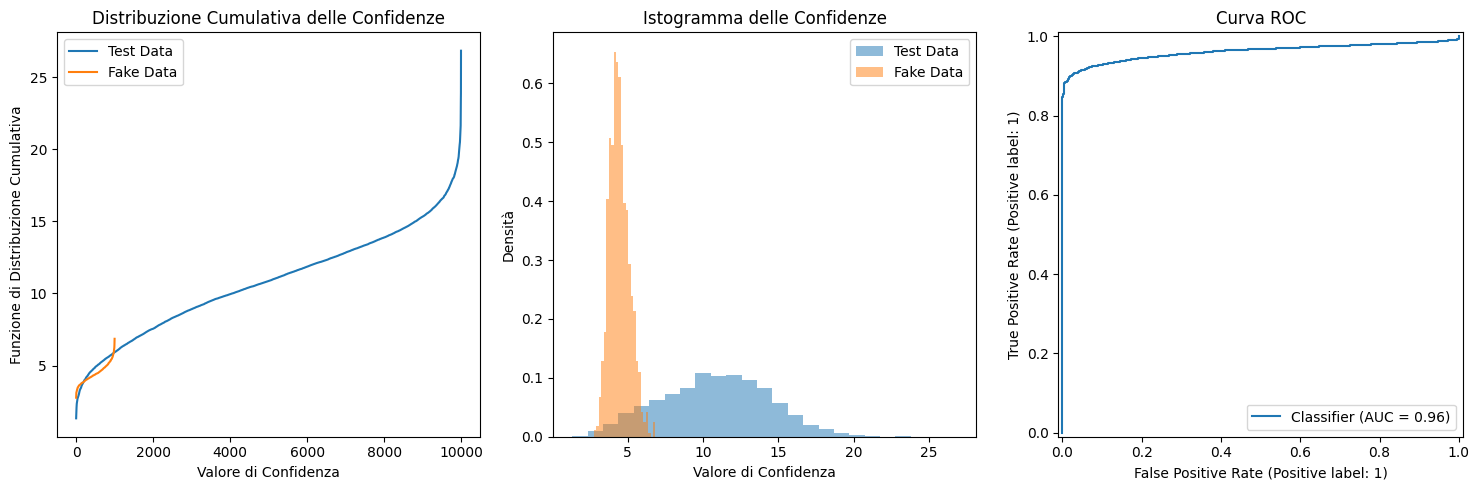

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primo grafico: Curve CDF (Cumulative Distribution Function)
axs[0].plot(sorted(scores_test.cpu()), label='Test Data')
axs[0].plot(sorted(scores_fake.cpu()), label='Fake Data')
axs[0].set_xlabel('Valore di Confidenza')
axs[0].set_ylabel('Funzione di Distribuzione Cumulativa')
axs[0].set_title('Distribuzione Cumulativa delle Confidenze')
axs[0].legend()

# Secondo grafico: Istogrammi di densità
axs[1].hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label='Test Data')
axs[1].hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label='Fake Data')
axs[1].set_xlabel('Valore di Confidenza')
axs[1].set_ylabel('Densità')
axs[1].set_title('Istogramma delle Confidenze')
axs[1].legend()

# Terzo grafico: Curva ROC
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)
y = torch.cat((y_test, y_fake))

metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu(), ax=axs[2])
axs[2].set_title('Curva ROC')

# Ottimizza il layout dei subplot
plt.tight_layout()
plt.show()

Miglioramento nella OOD detection: AUC da 0.63 -> 0.96


---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.


ESERCIZIO 3.1

In [56]:
def odin_scores(model, data_loader, T=1000.0, eps=0.001):
    """
    Compute ODIN confidence scores for a dataset.
    """
    model.eval()
    scores = []

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        x_adv = x.clone().detach()
        x_adv.requires_grad = True

        # Forward pass con temperatura
        logits = model(x_adv)
        logits_T = logits / T

        # Loss rispetto alla classe predetta
        target = logits_T.argmax(1)
        loss = F.cross_entropy(logits_T, target)
        model.zero_grad()
        loss.backward()

        # Perturbazione input
        x_adv = x_adv - eps * x_adv.grad.sign()
        x_adv = torch.clamp(x_adv, -1, 1)

        # Forward di nuovo
        logits_adv = model(x_adv)
        logits_adv_T = logits_adv / T
        softmax_adv = F.softmax(logits_adv_T, dim=1)

        # Confidenza = max softmax
        conf, _ = softmax_adv.max(dim=1)
        scores.append(conf.detach())

    return torch.cat(scores)

In [ ]:
eps_values = [0.0, 1/255, 2/255, 4/255]

# Modello pre trainato + train fgsm augm


--- Testing T=1, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9428


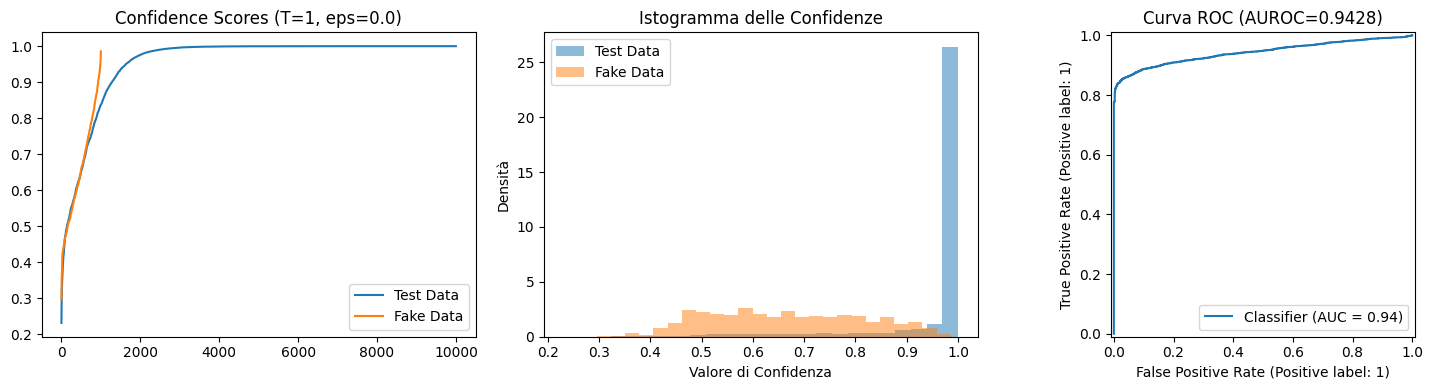


--- Testing T=1, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9917


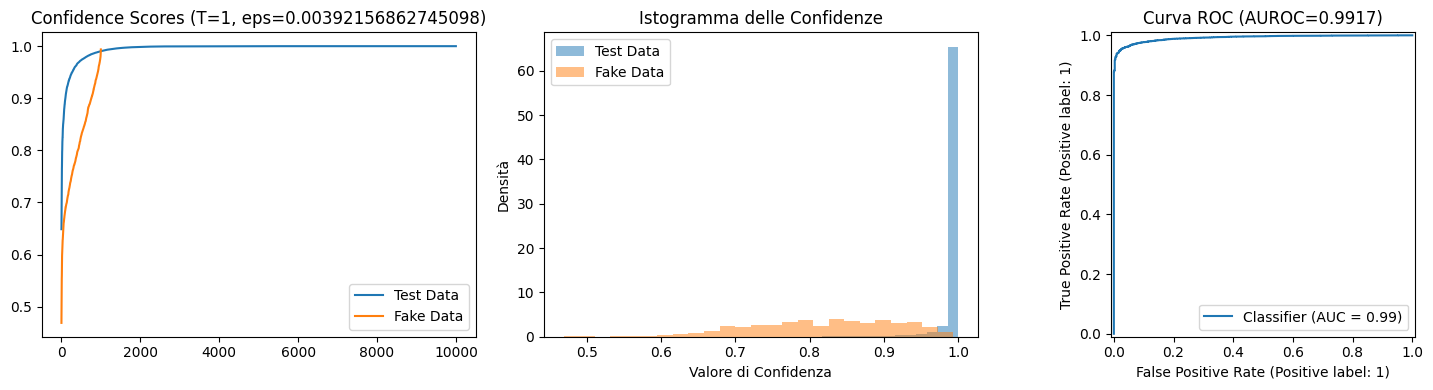


--- Testing T=1, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9970


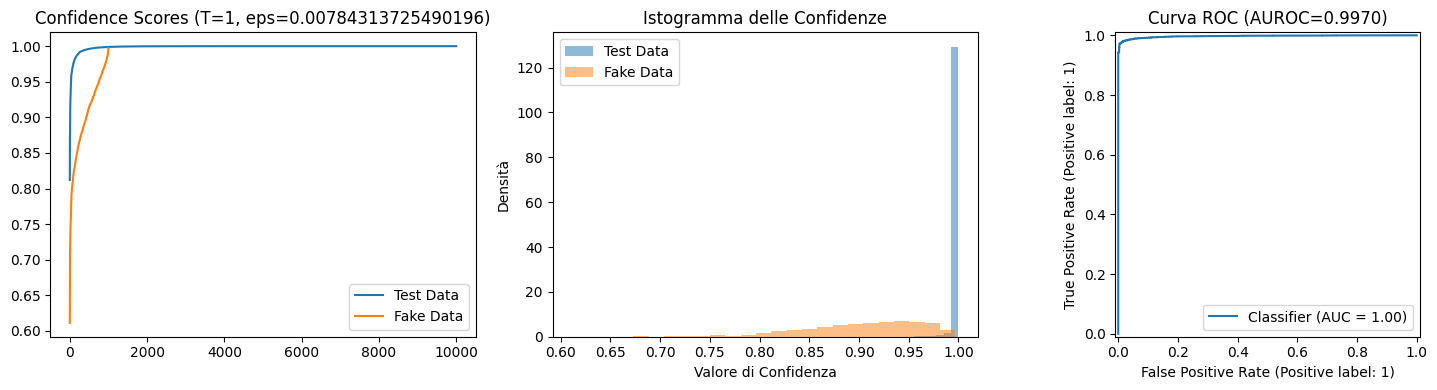


--- Testing T=1, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9984


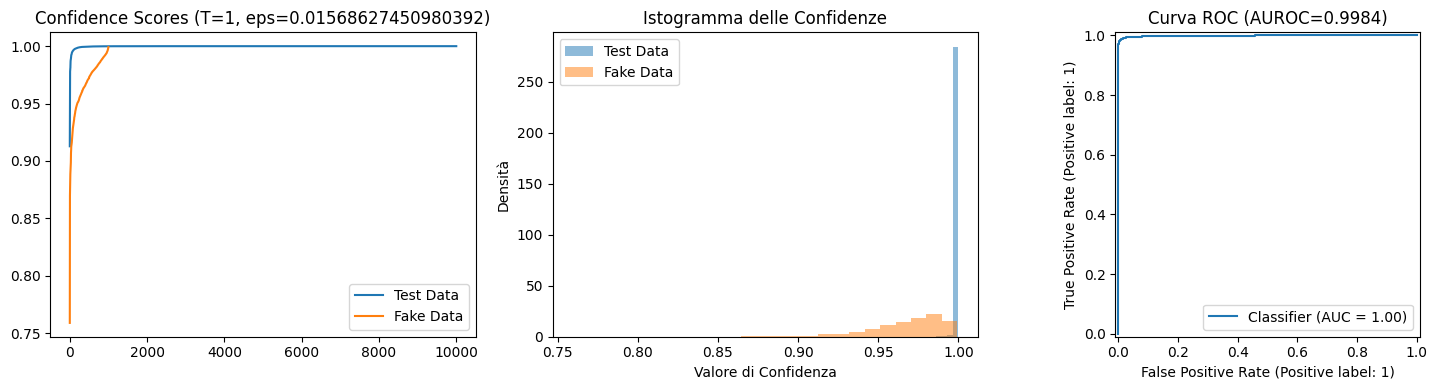


--- Testing T=1, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9984


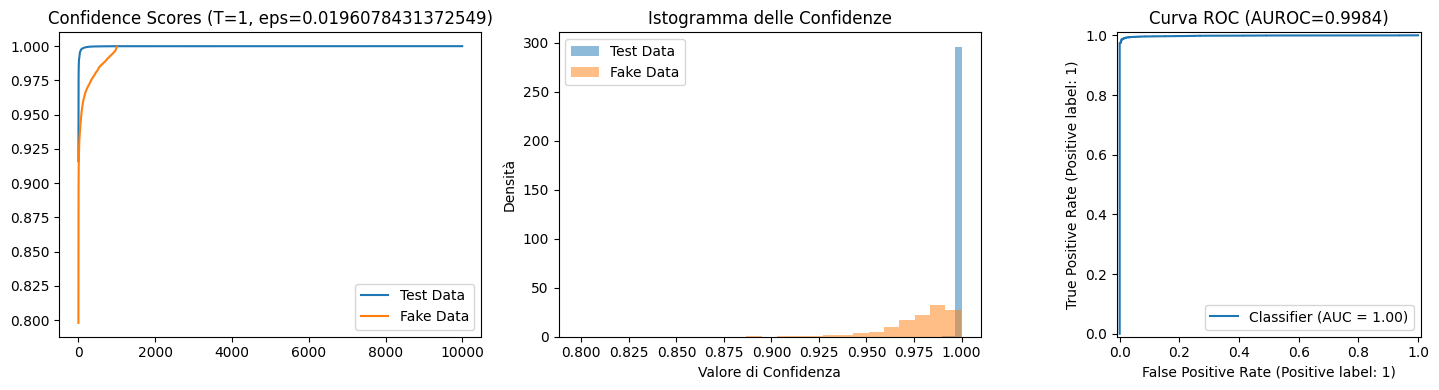


--- Testing T=1, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9982


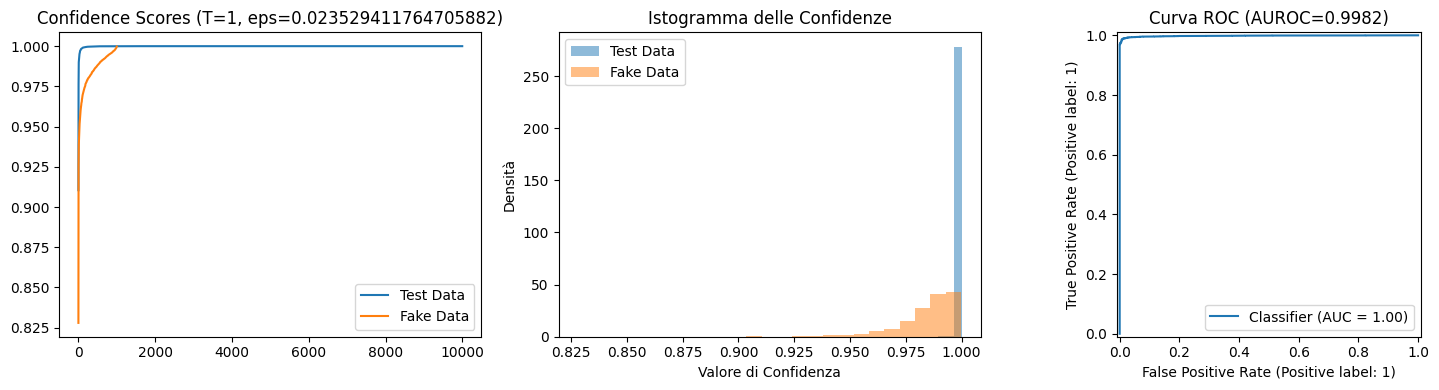


--- Testing T=1, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9943


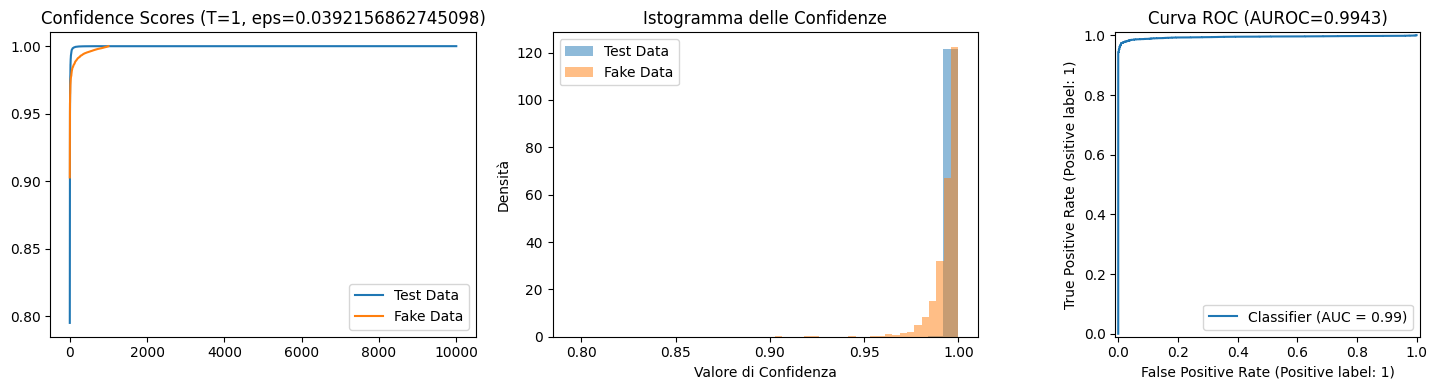


--- Testing T=10, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9627


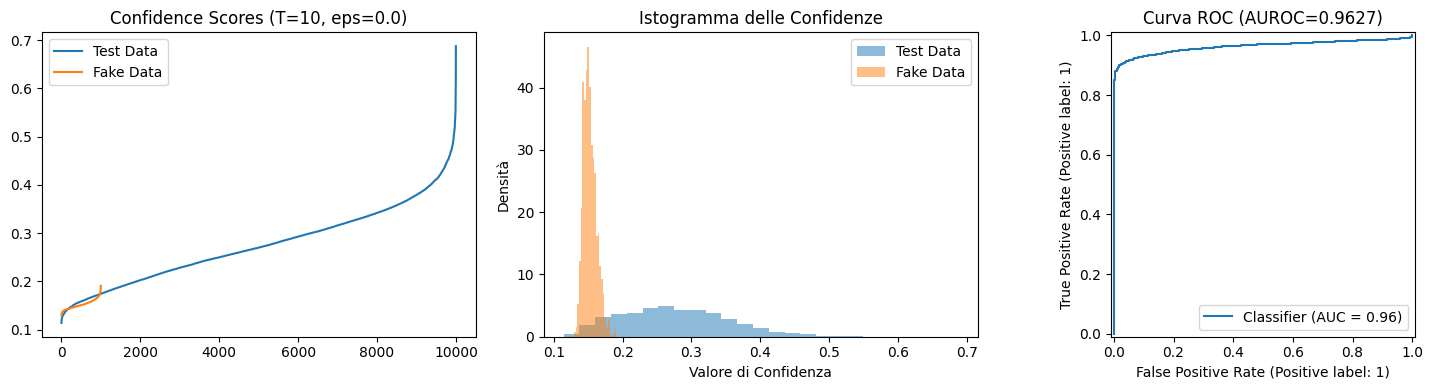


--- Testing T=10, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9906


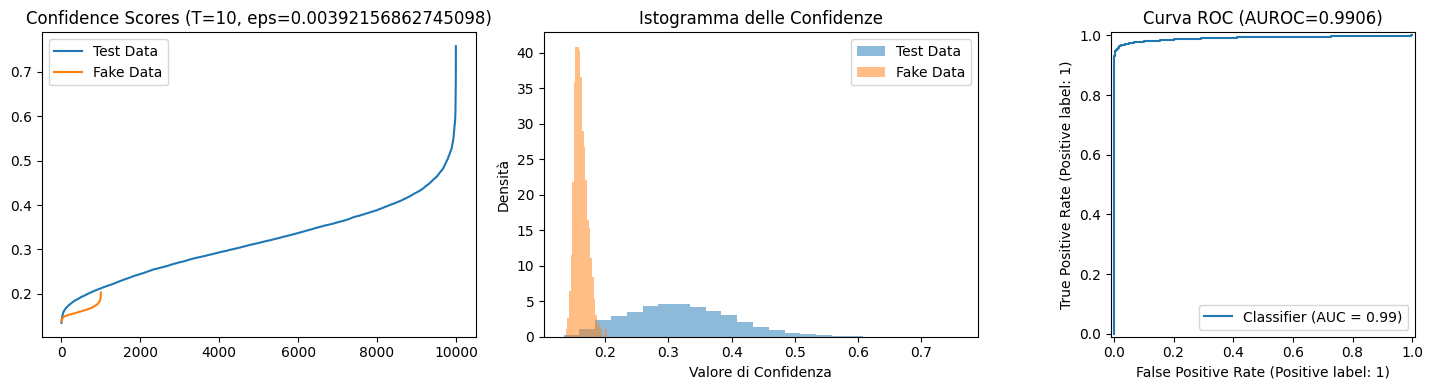


--- Testing T=10, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9964


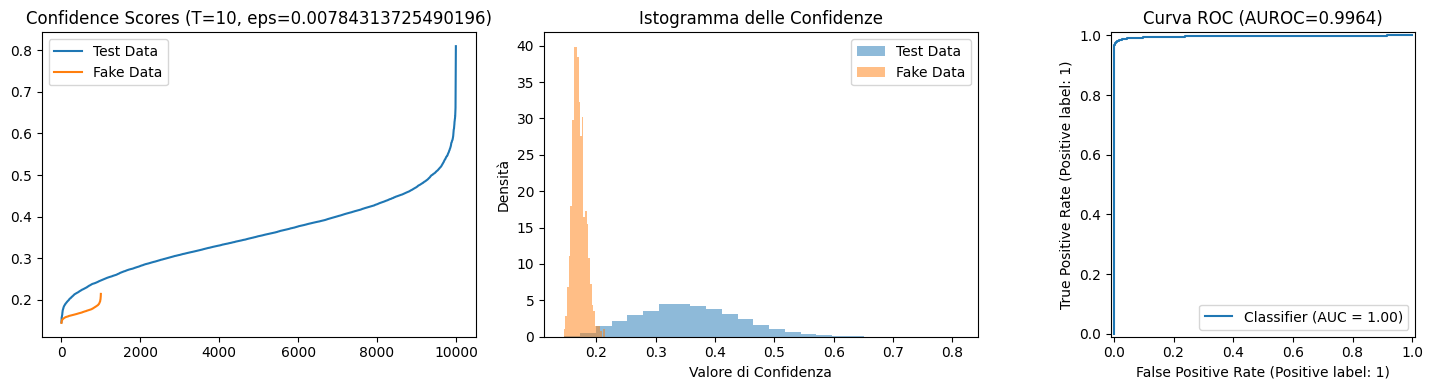


--- Testing T=10, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9986


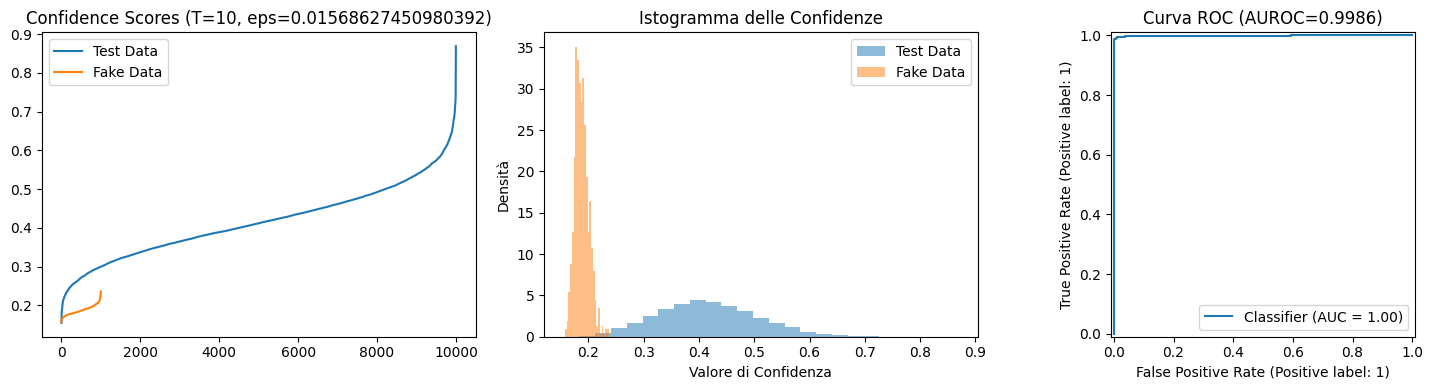


--- Testing T=10, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9988


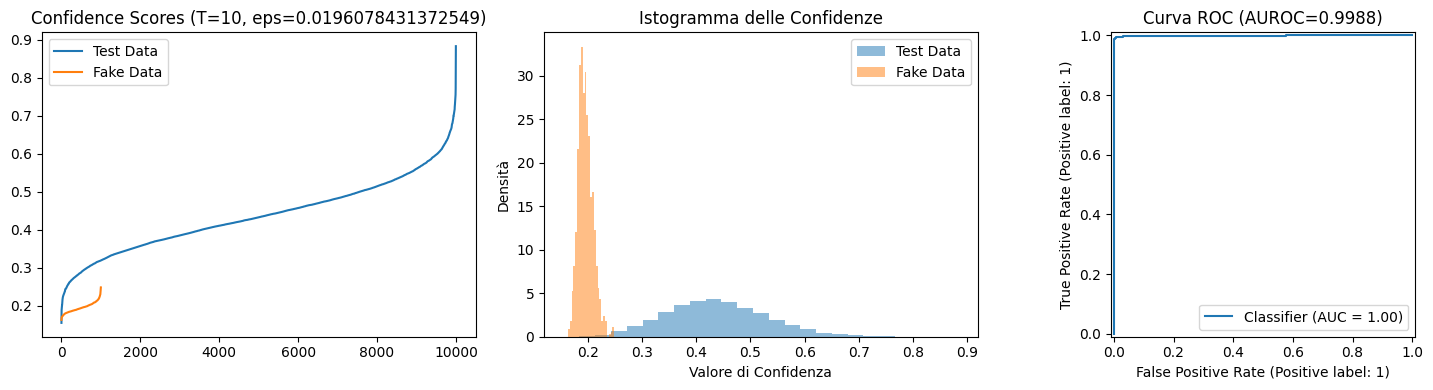


--- Testing T=10, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9989


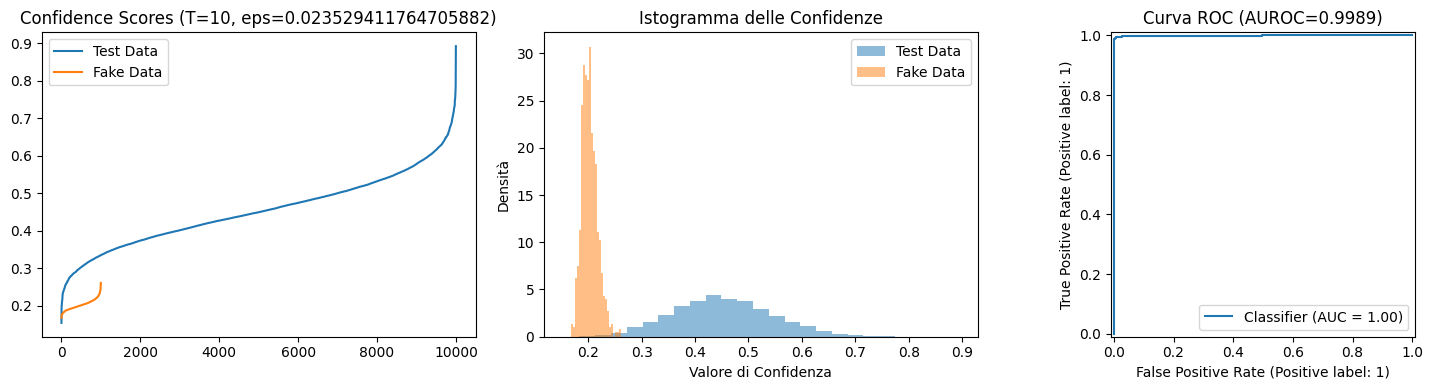


--- Testing T=10, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9978


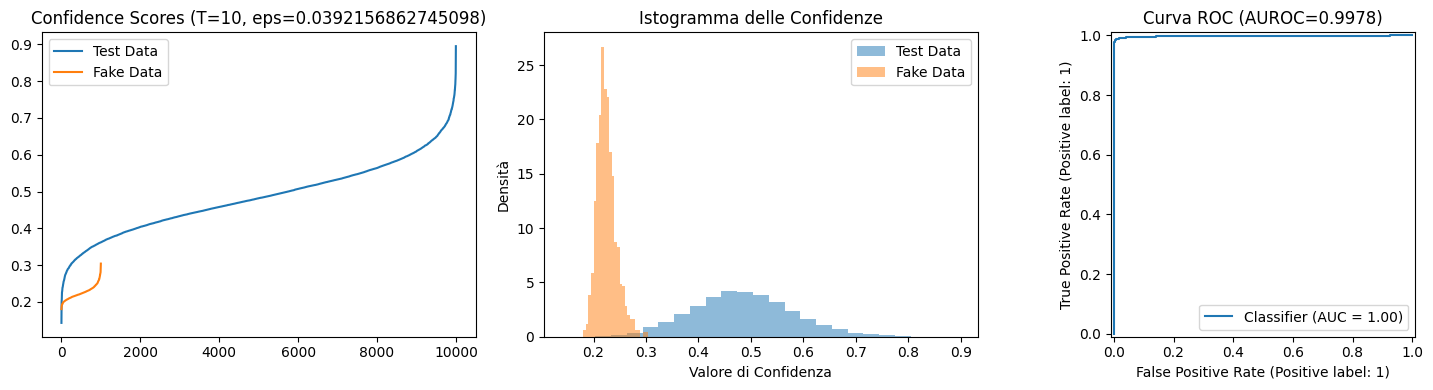


--- Testing T=100, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9624


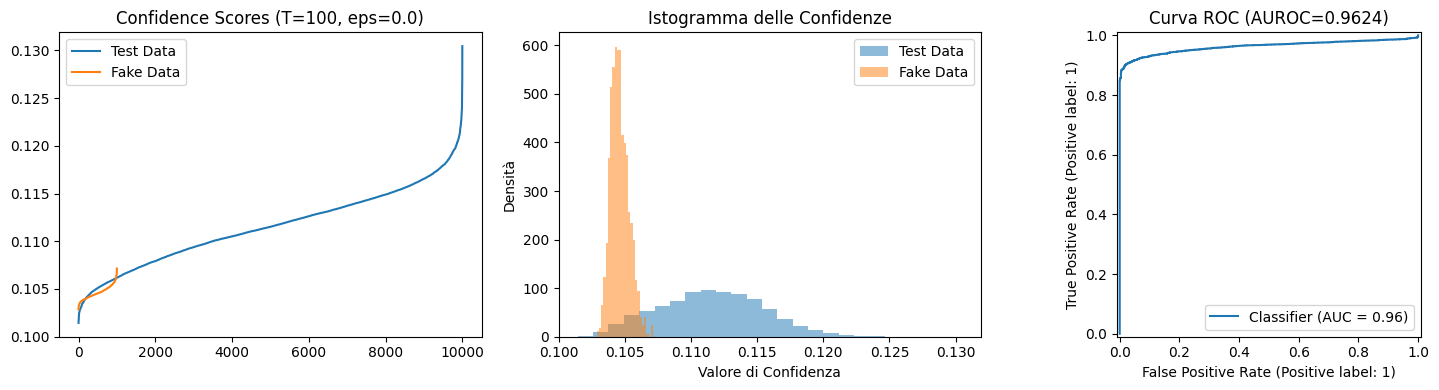


--- Testing T=100, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9900


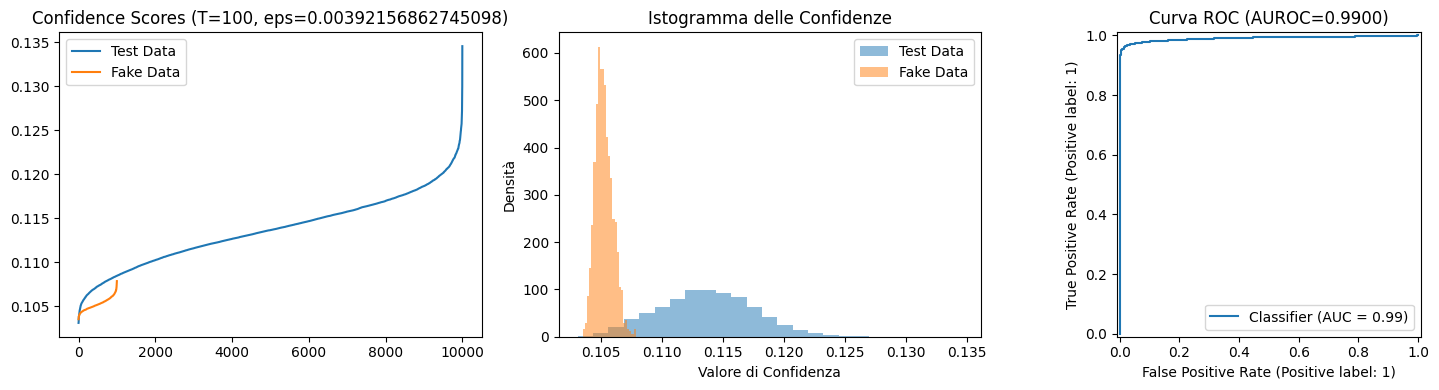


--- Testing T=100, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9962


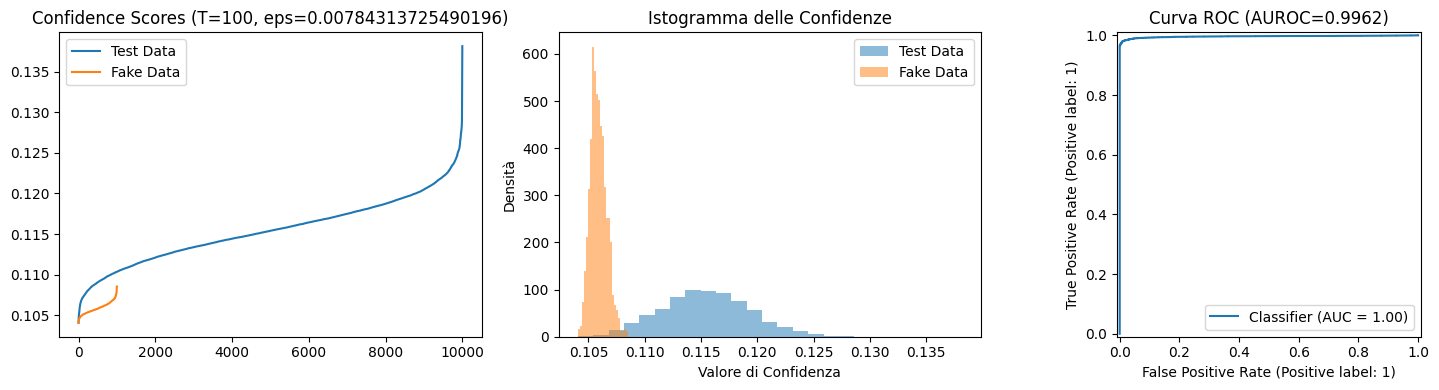


--- Testing T=100, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9985


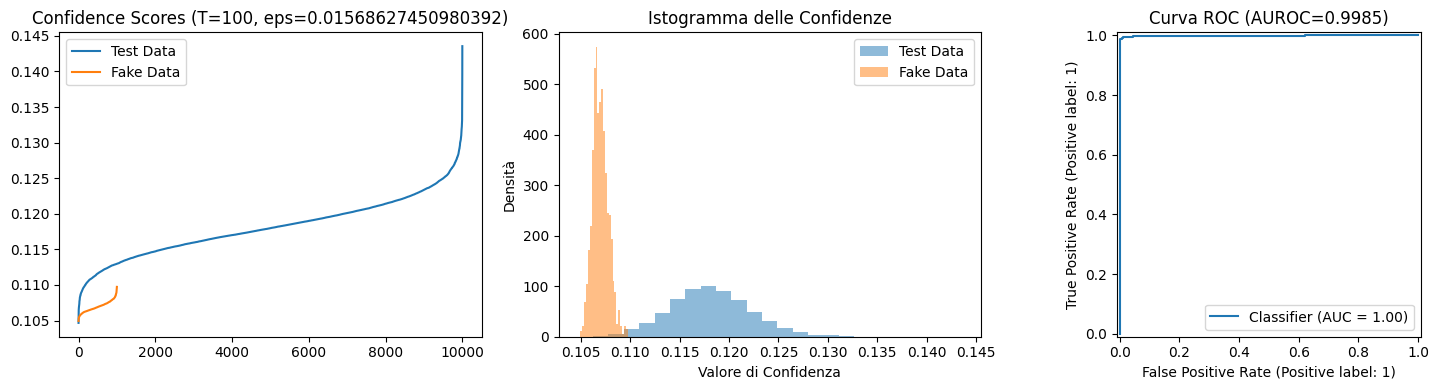


--- Testing T=100, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9987


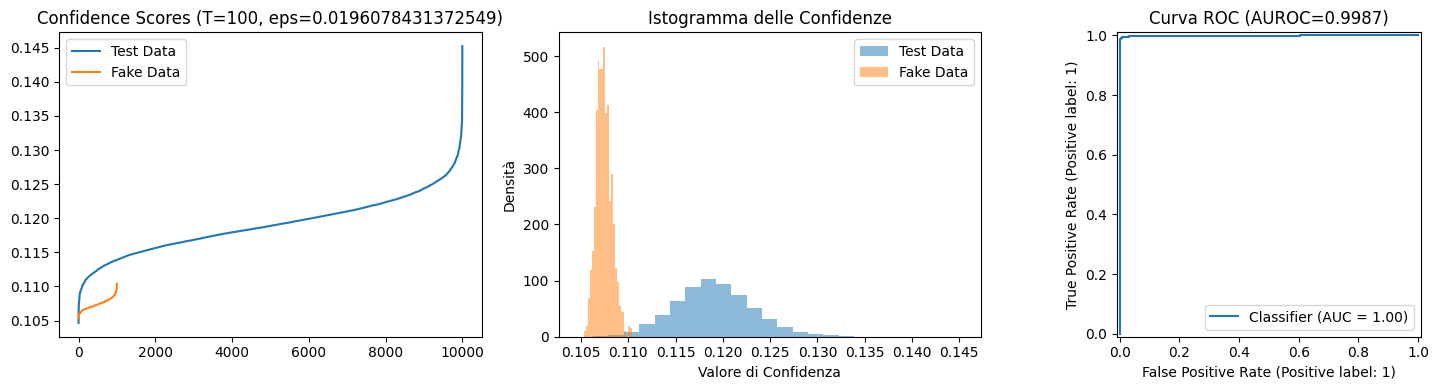


--- Testing T=100, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9988


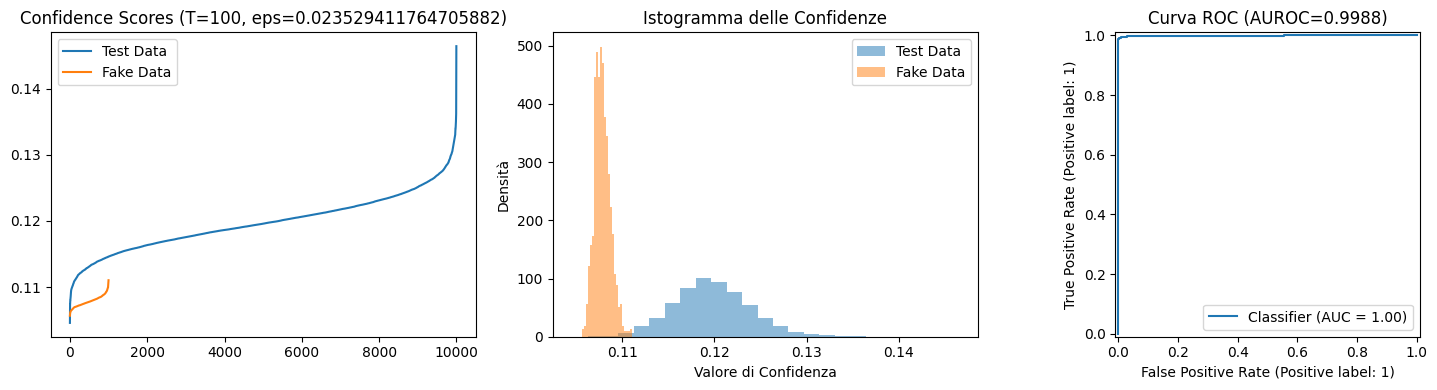


--- Testing T=100, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9979


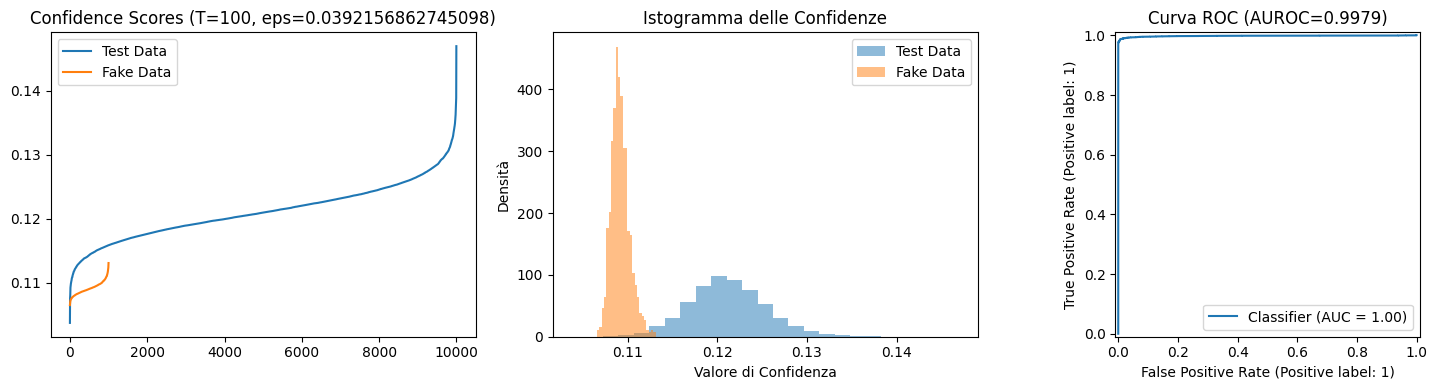


--- Testing T=1000, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9624


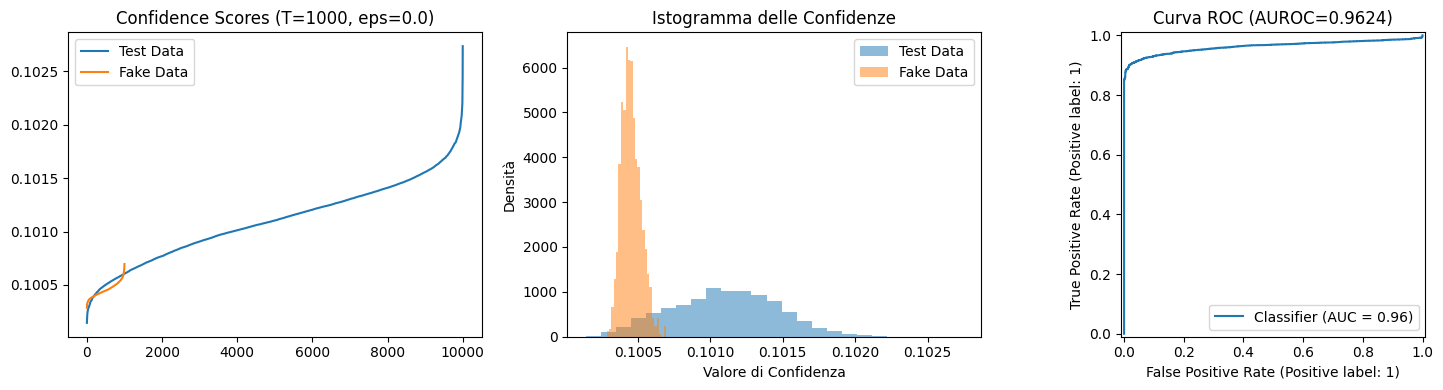


--- Testing T=1000, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9900


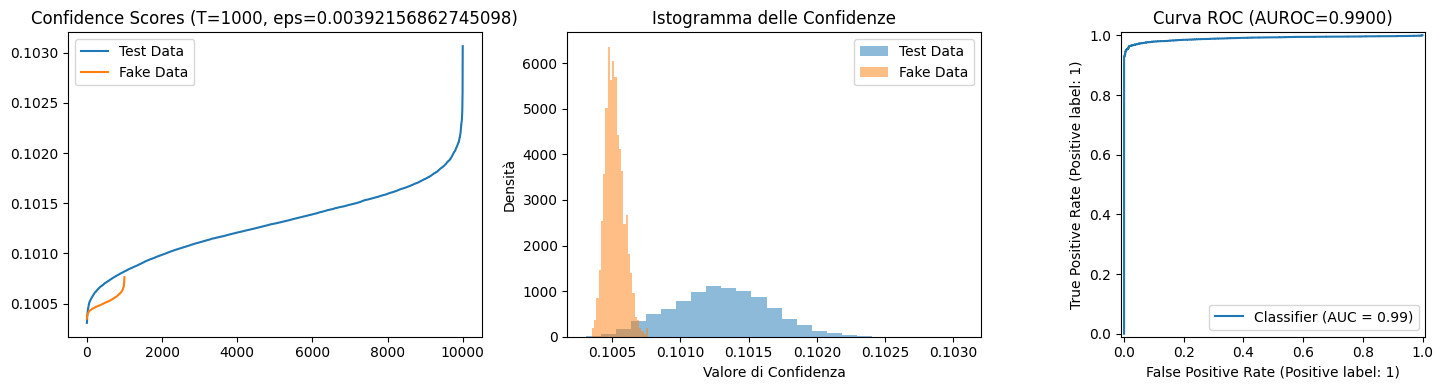


--- Testing T=1000, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9961


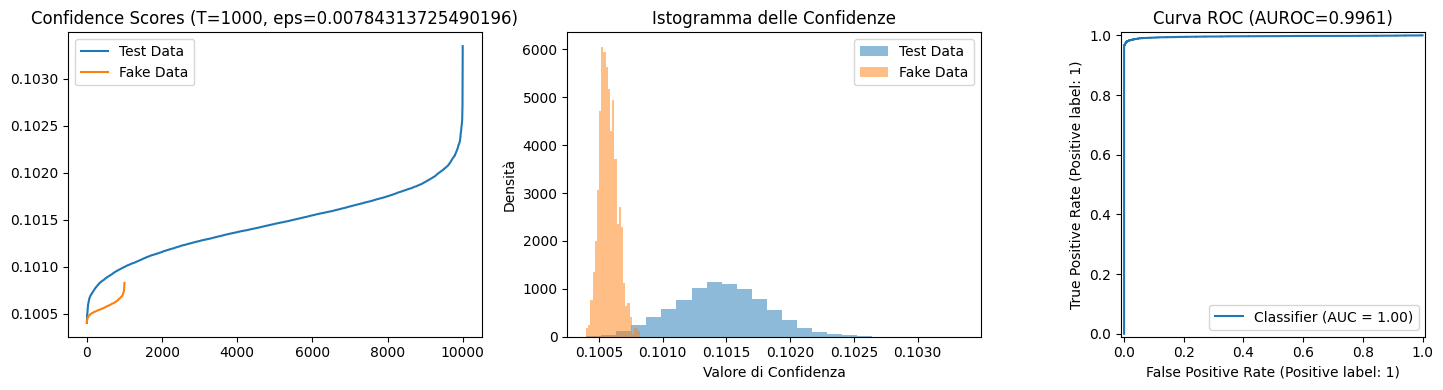


--- Testing T=1000, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9984


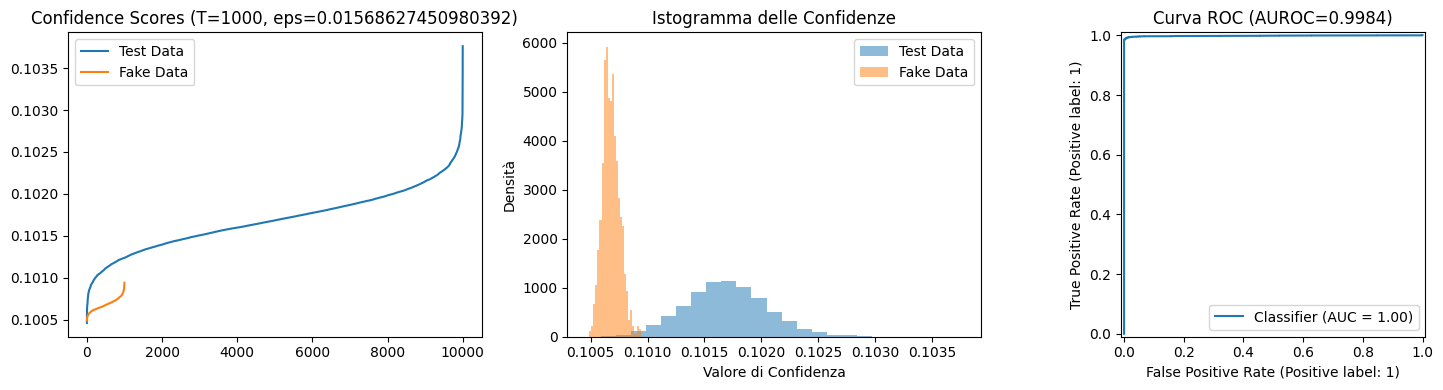


--- Testing T=1000, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9987


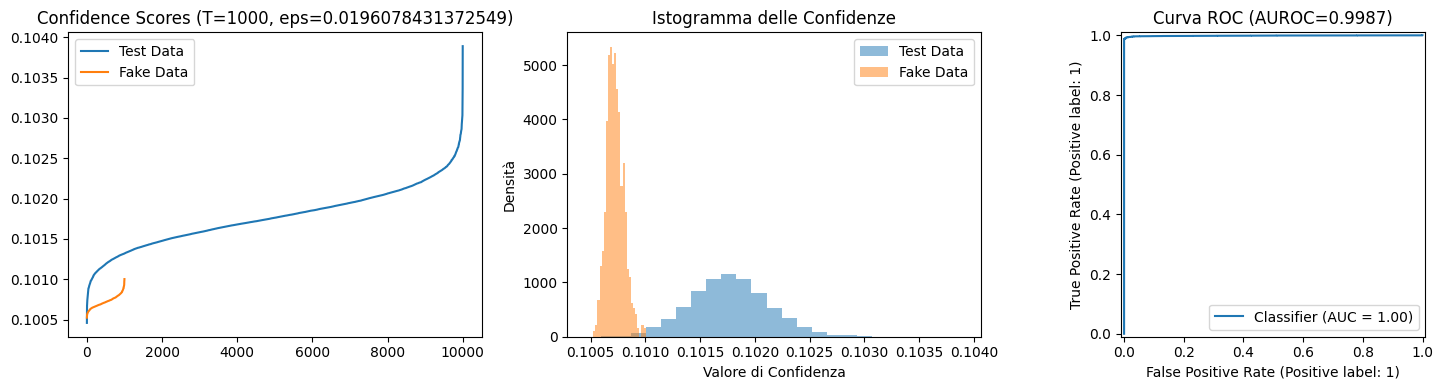


--- Testing T=1000, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9988


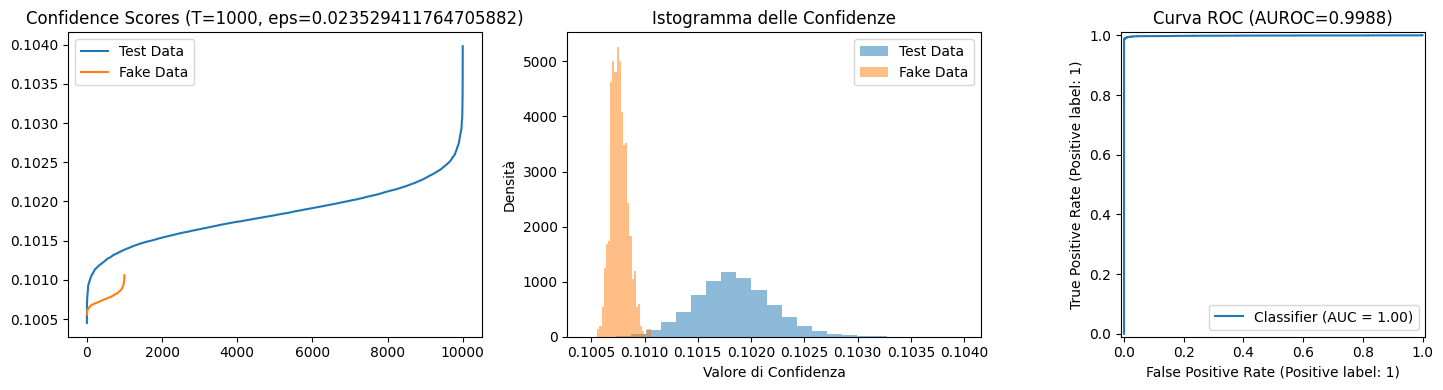


--- Testing T=1000, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9979


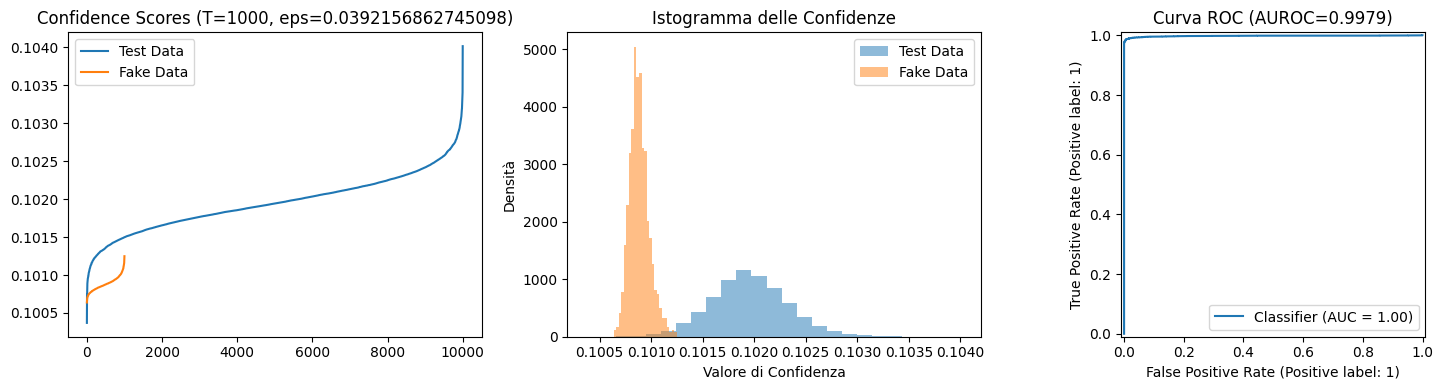

       T       eps     AUROC
0      1  0.000000  0.942769
1      1  0.003922  0.991680
2      1  0.007843  0.997026
3      1  0.015686  0.998441
4      1  0.019608  0.998430
5      1  0.023529  0.998209
6      1  0.039216  0.994258
7     10  0.000000  0.962699
8     10  0.003922  0.990626
9     10  0.007843  0.996430
10    10  0.015686  0.998561
11    10  0.019608  0.998796
12    10  0.023529  0.998859
13    10  0.039216  0.997834
14   100  0.000000  0.962432
15   100  0.003922  0.990023
16   100  0.007843  0.996163
17   100  0.015686  0.998455
18   100  0.019608  0.998722
19   100  0.023529  0.998808
20   100  0.039216  0.997875
21  1000  0.000000  0.962387
22  1000  0.003922  0.989959
23  1000  0.007843  0.996138
24  1000  0.015686  0.998447
25  1000  0.019608  0.998713
26  1000  0.023529  0.998804
27  1000  0.039216  0.997874


In [69]:
from sklearn.metrics import roc_auc_score
import pandas as pd

T_values = [1, 10, 100, 1000]
eps_values = [0.0, 1/255, 2/255, 4/255, 5/255, 6/255, 10/255]

# Lista per salvare i risultati
results = []

for T in T_values:
    for eps in eps_values:
        print(f"\n--- Testing T={T}, eps={eps} ---")

        scores_test = odin_scores(model_pretrained, testloader, T=T, eps=eps)
        scores_fake = odin_scores(model_pretrained, fakeloader, T=T, eps=eps)

        # Concatenazione per AUROC
        ypred = torch.cat((scores_test, scores_fake))
        y_test = torch.ones_like(scores_test)
        y_fake = torch.zeros_like(scores_fake)
        y = torch.cat((y_test, y_fake))

        auroc = roc_auc_score(
            y.detach().cpu().numpy(),
            ypred.detach().cpu().numpy()
        )

        # Salvataggio dei risultati
        results.append({"T": T, "eps": eps, "AUROC": auroc})
        print(f"AUROC = {auroc:.4f}")

        # Grafici diagnostici
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        # 1. Scatter ordinato
        axs[0].plot(sorted(scores_test.cpu()), label='Test Data')
        axs[0].plot(sorted(scores_fake.cpu()), label='Fake Data')
        axs[0].set_title(f"Confidence Scores (T={T}, eps={eps})")
        axs[0].legend()

        # 2. Istogramma densità
        axs[1].hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label='Test Data')
        axs[1].hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label='Fake Data')
        axs[1].set_xlabel('Valore di Confidenza')
        axs[1].set_ylabel('Densità')
        axs[1].set_title('Istogramma delle Confidenze')
        axs[1].legend()

        # 3. Curva ROC con AUC
        metrics.RocCurveDisplay.from_predictions(
            y.detach().cpu().numpy(),
            ypred.detach().cpu().numpy(),
            ax=axs[2]
        )
        axs[2].set_title(f'Curva ROC (AUROC={auroc:.4f})')

        plt.tight_layout()
        plt.show()

# Conversione a DataFrame per analisi successive
df_results = pd.DataFrame(results)
print(df_results)

T             1         10        100       1000
eps                                             
0.000000  0.942769  0.962699  0.962432  0.962387
0.003922  0.991680  0.990626  0.990023  0.989959
0.007843  0.997026  0.996430  0.996163  0.996138
0.015686  0.998441  0.998561  0.998455  0.998447
0.019608  0.998430  0.998796  0.998722  0.998713
0.023529  0.998209  0.998859  0.998808  0.998804
0.039216  0.994258  0.997834  0.997875  0.997874


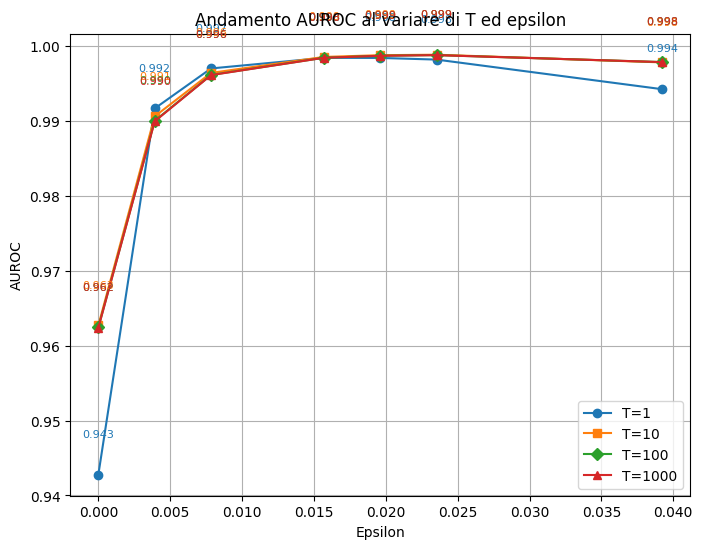

In [70]:
print(df_results.pivot(index="eps", columns="T", values="AUROC"))
markers = ["o", "s", "D", "^"]  # marker diversi per ogni T
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

plt.figure(figsize=(8,6))
for i, T in enumerate(T_values):
    subset = df_results[df_results["T"] == T]
    plt.plot(subset["eps"], subset["AUROC"],
             marker=markers[i], color=colors[i],
             label=f"T={T}")
    # aggiungi etichette numeriche sui punti
    for x, y in zip(subset["eps"], subset["AUROC"]):
        plt.text(x, y+0.005, f"{y:.3f}", ha="center", fontsize=8, color=colors[i])

plt.xlabel("Epsilon")
plt.ylabel("AUROC")
plt.title("Andamento AUROC al variare di T ed epsilon")
plt.legend()
plt.grid(True)
plt.show()

# Primo MOdello Semplice (convnet inziale)


In [71]:
model


CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


--- Testing T=1, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.4140


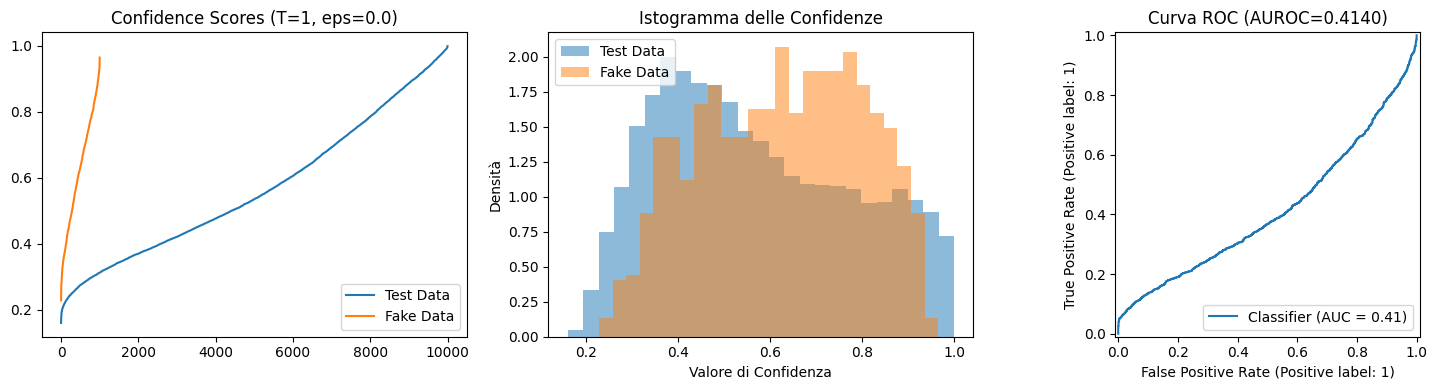


--- Testing T=1, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.3821


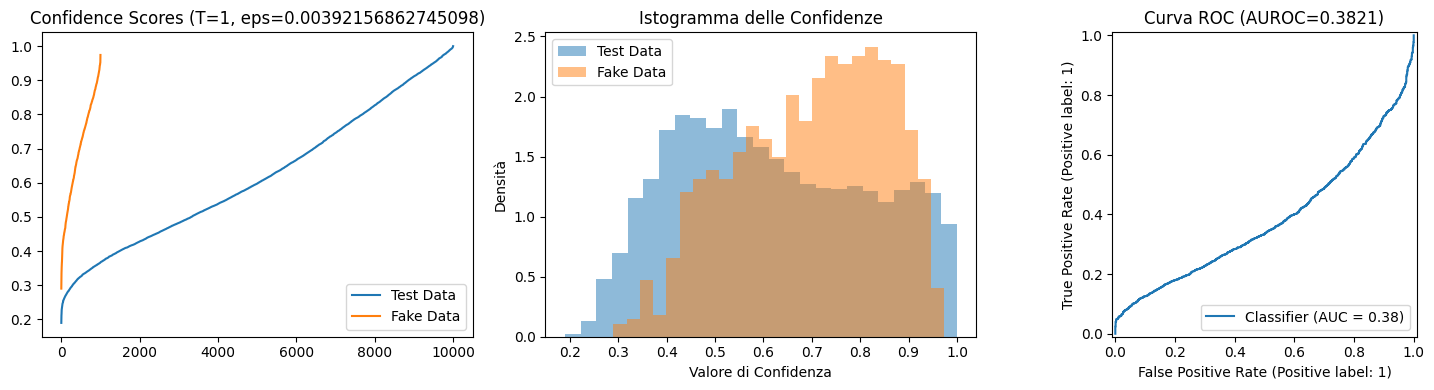


--- Testing T=1, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.3548


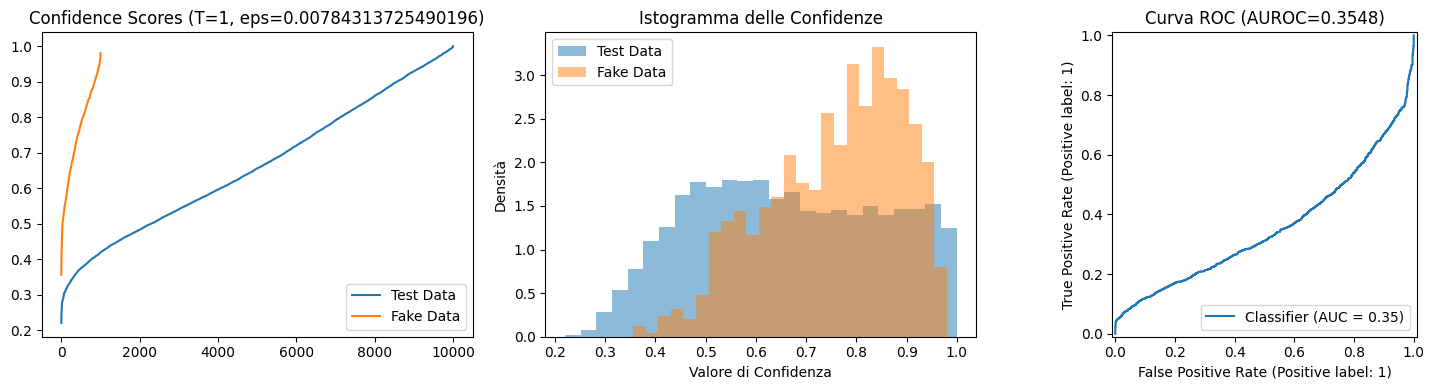


--- Testing T=1, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.3149


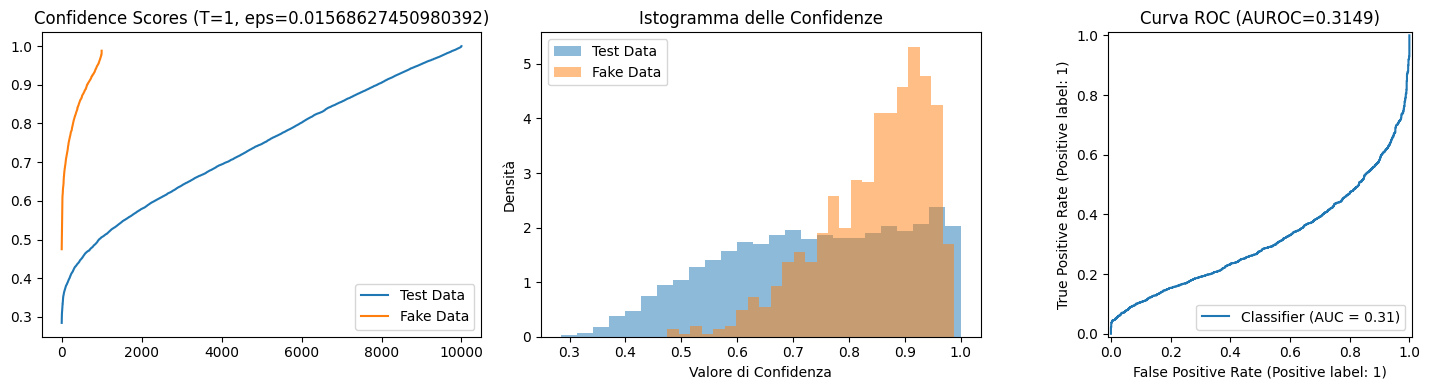


--- Testing T=1, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.3009


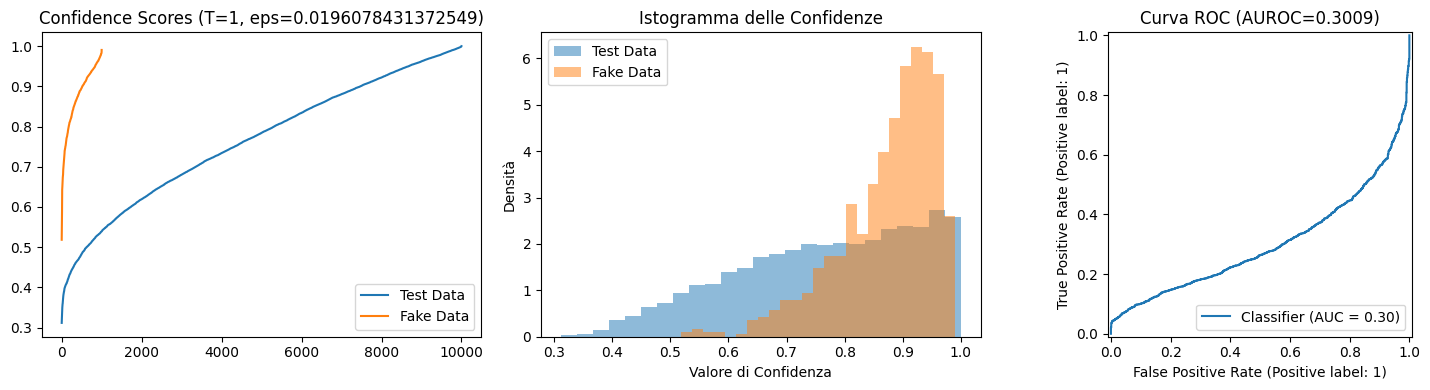


--- Testing T=1, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.2898


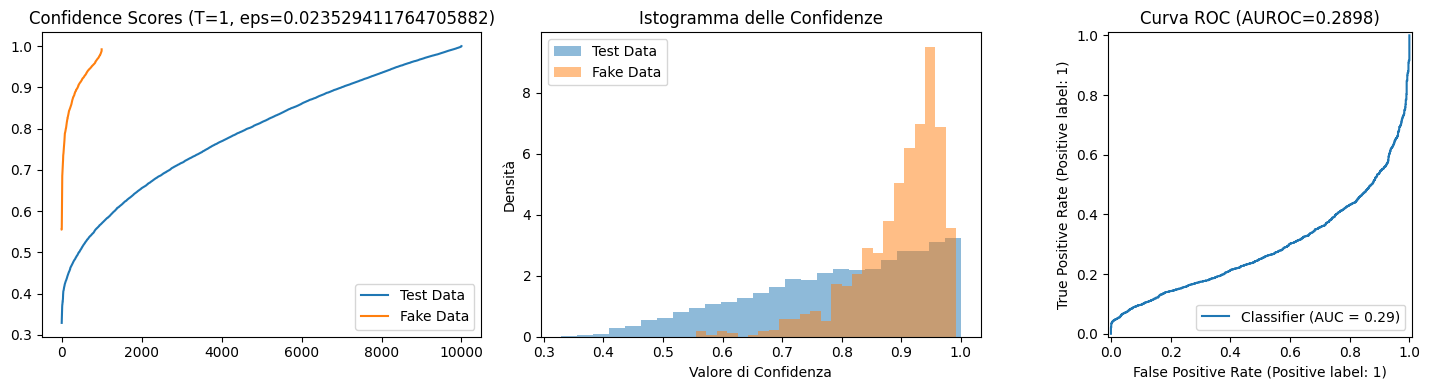


--- Testing T=1, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.2654


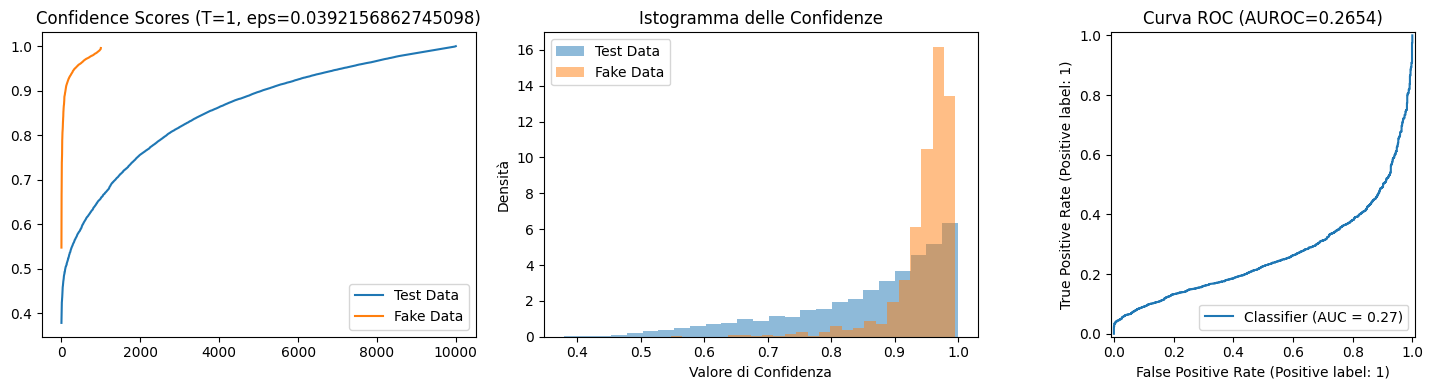


--- Testing T=10, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6332


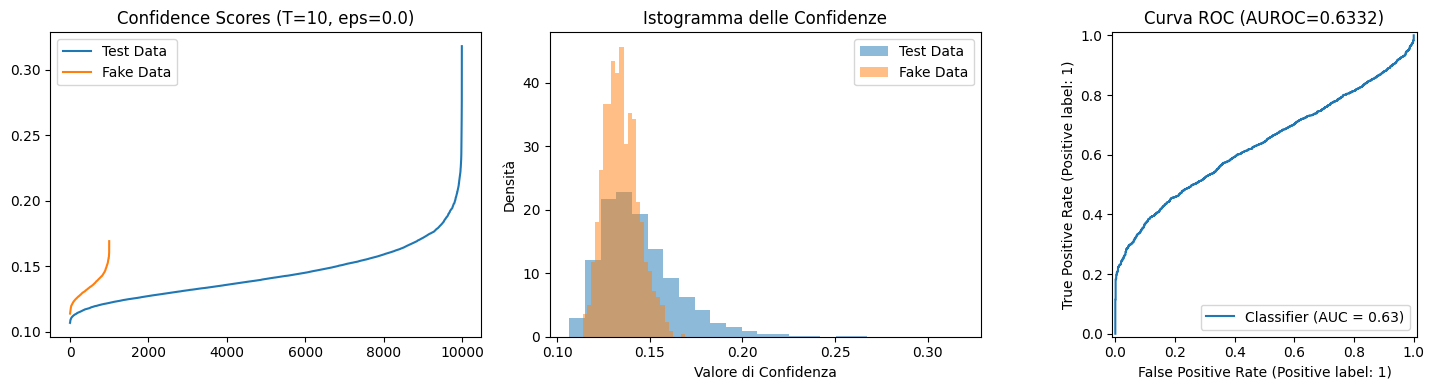


--- Testing T=10, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6184


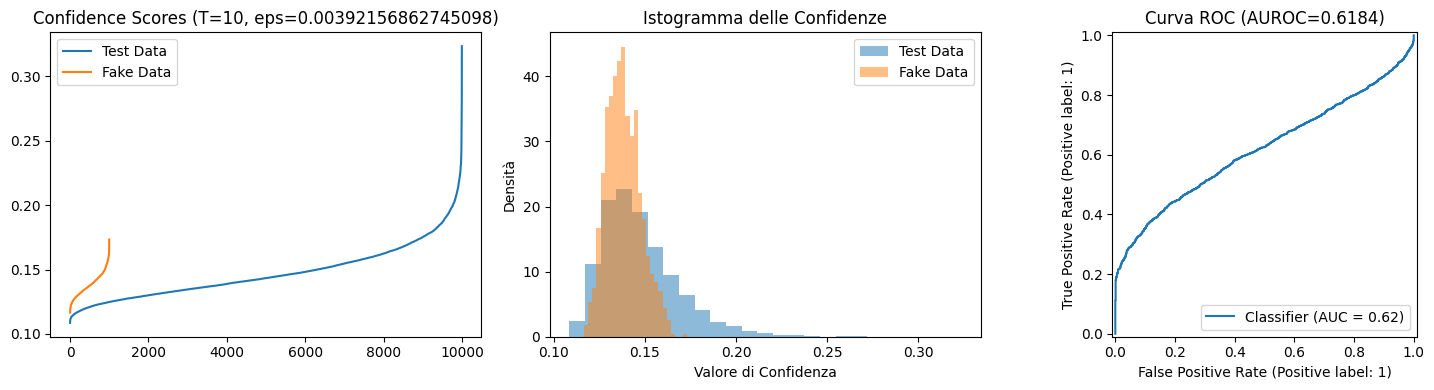


--- Testing T=10, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6021


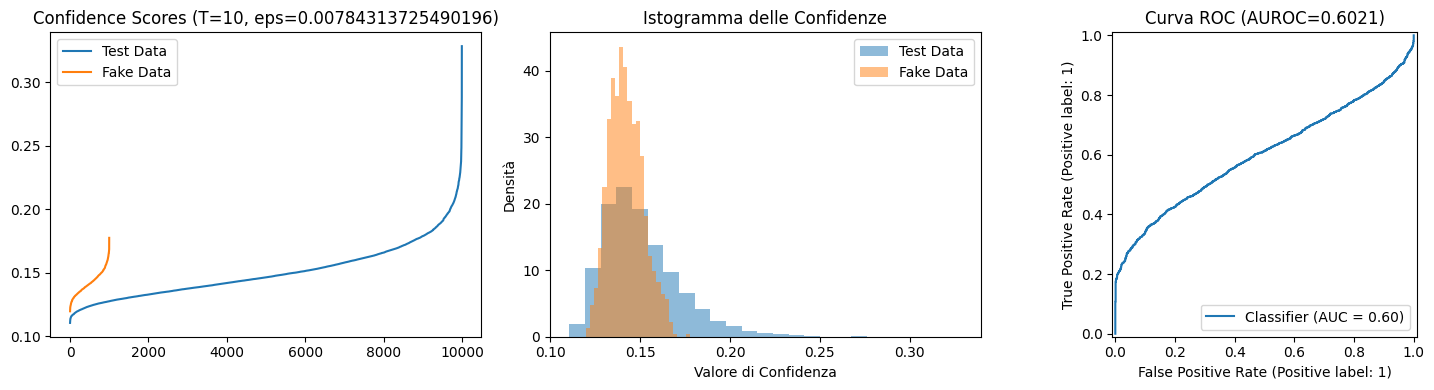


--- Testing T=10, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5674


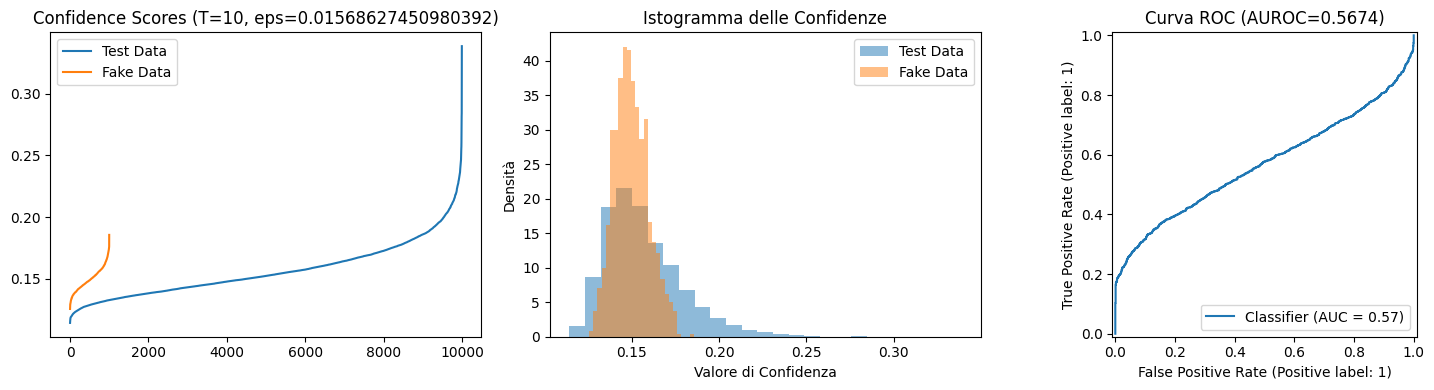


--- Testing T=10, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5499


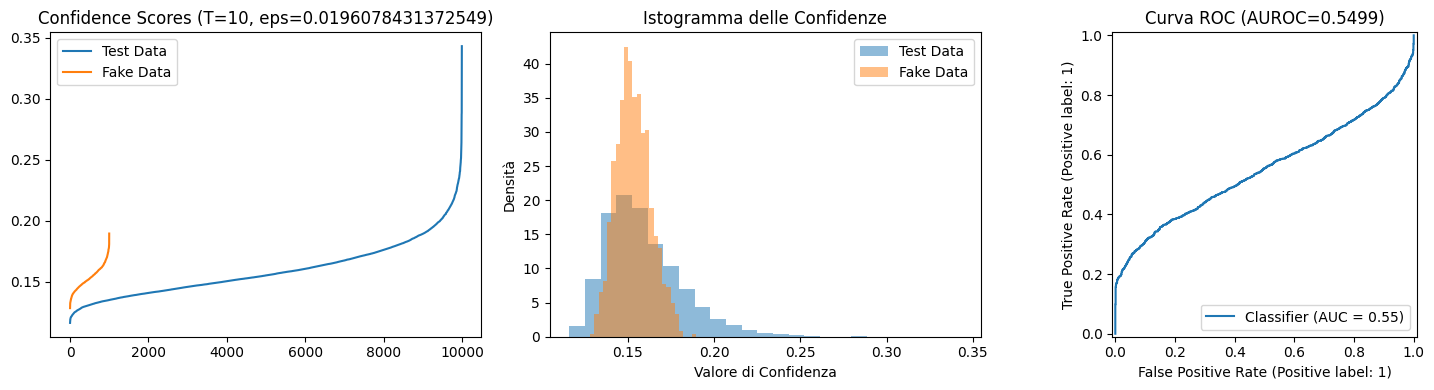


--- Testing T=10, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5328


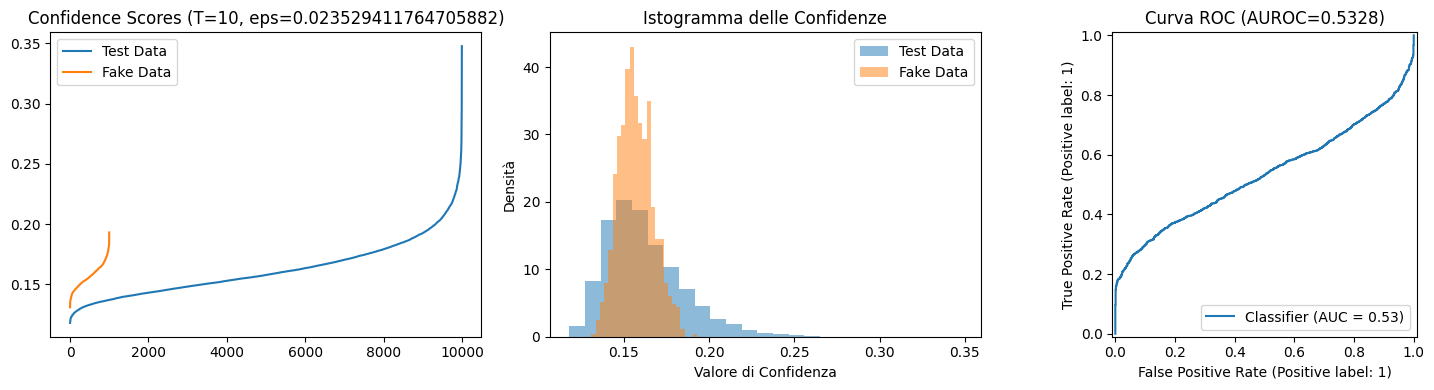


--- Testing T=10, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.4718


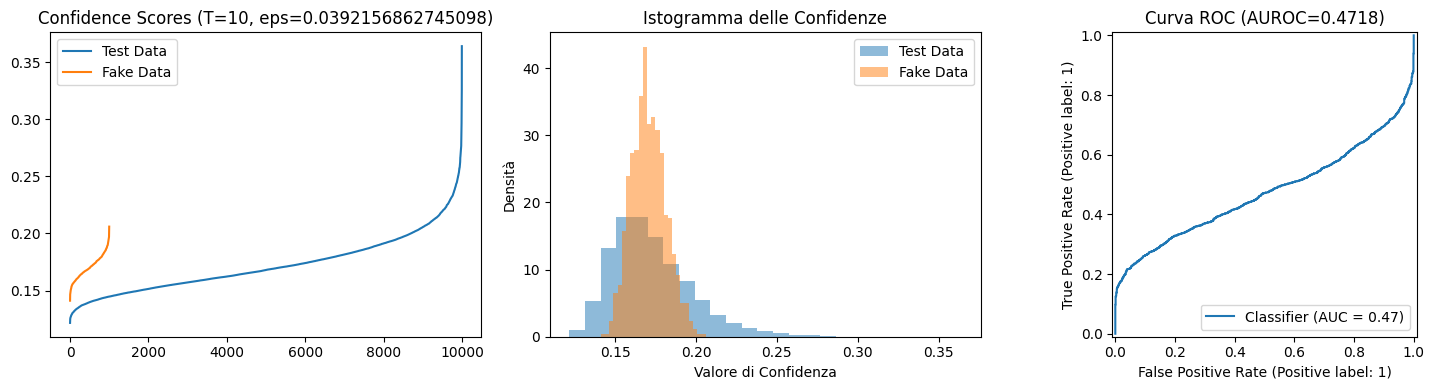


--- Testing T=100, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6623


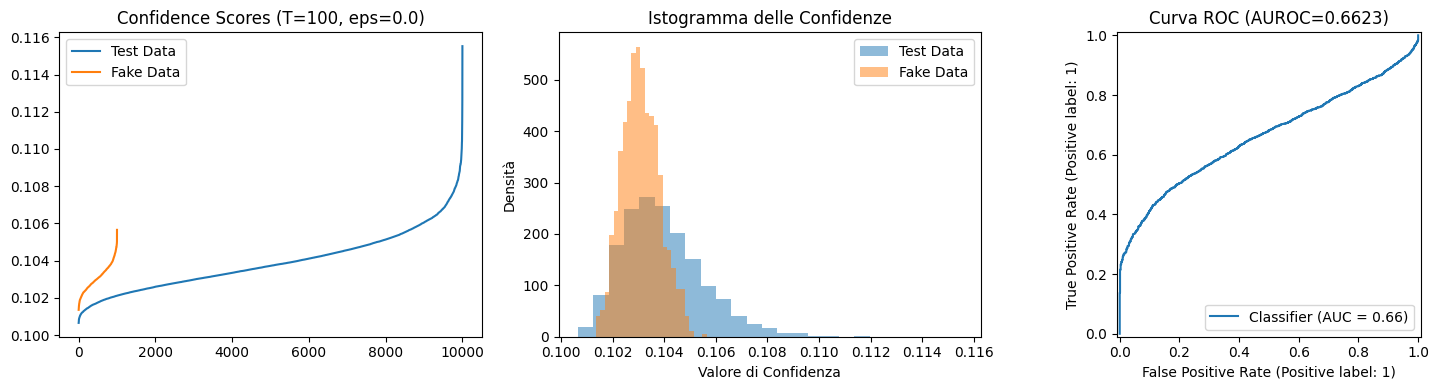


--- Testing T=100, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6507


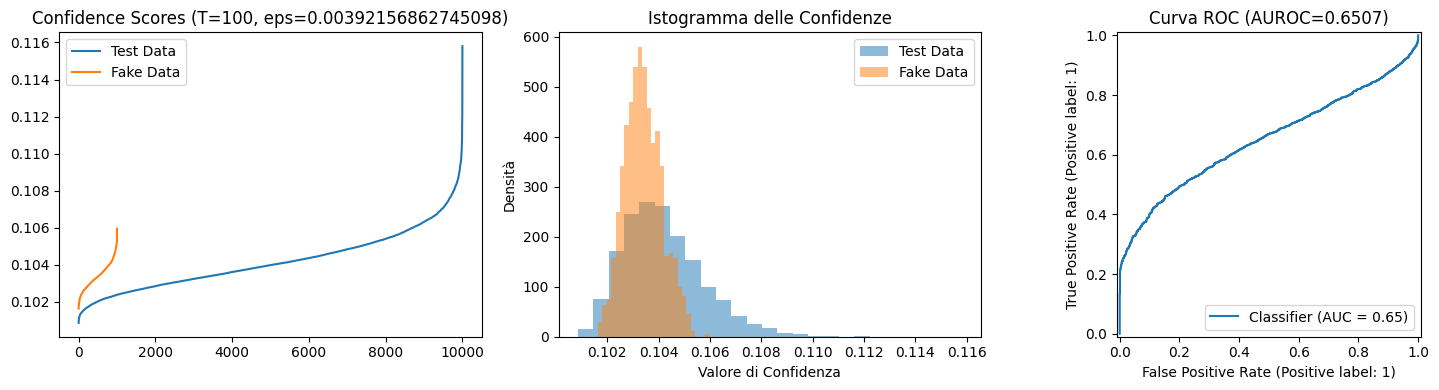


--- Testing T=100, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6373


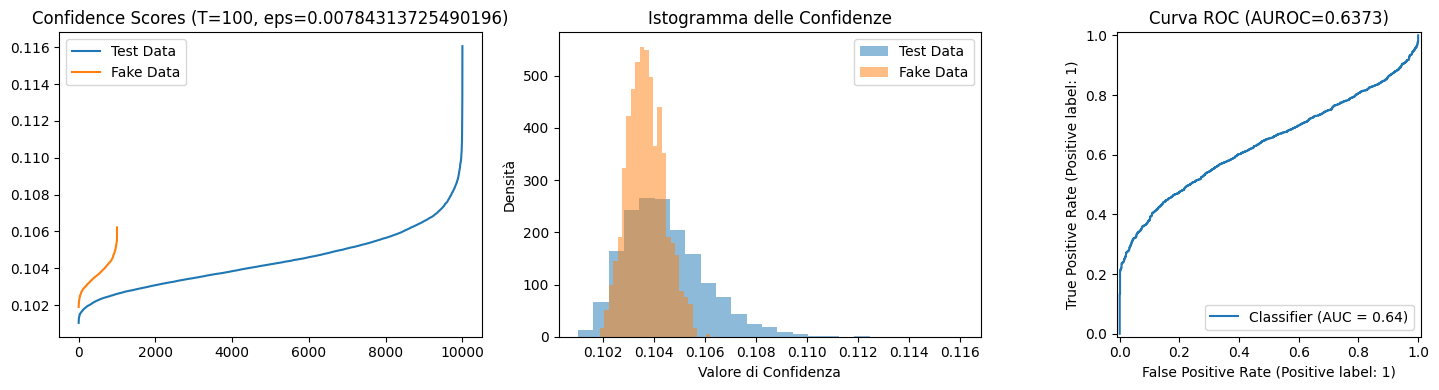


--- Testing T=100, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6078


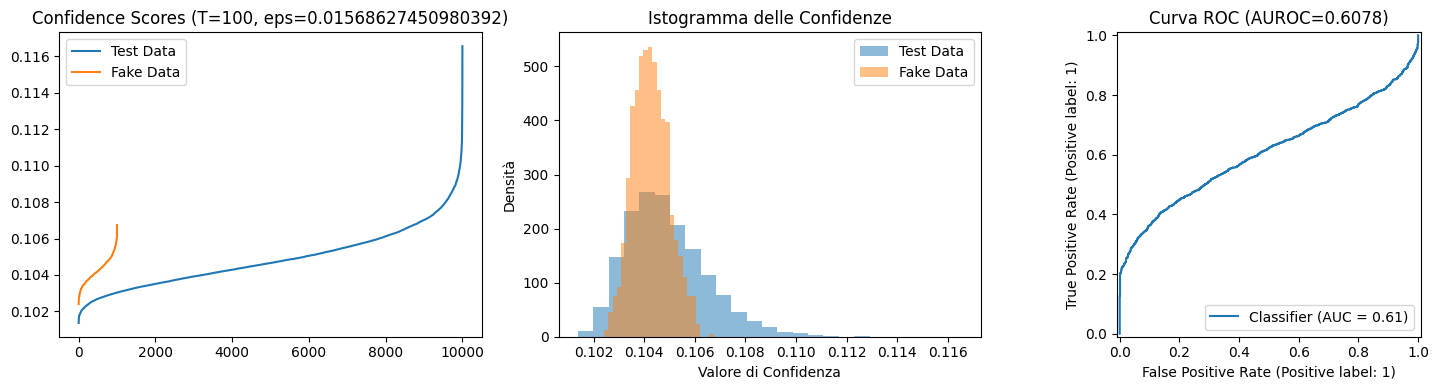


--- Testing T=100, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5922


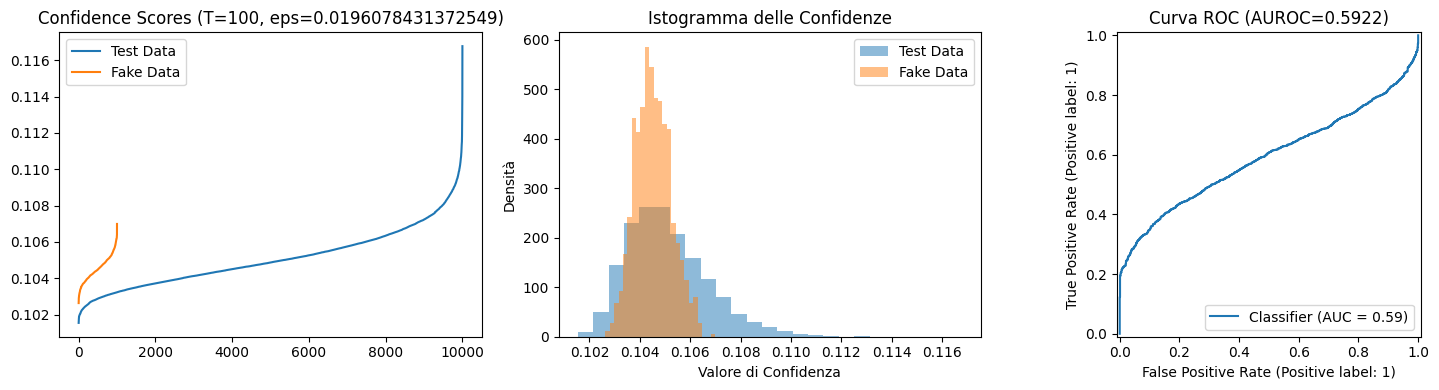


--- Testing T=100, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5766


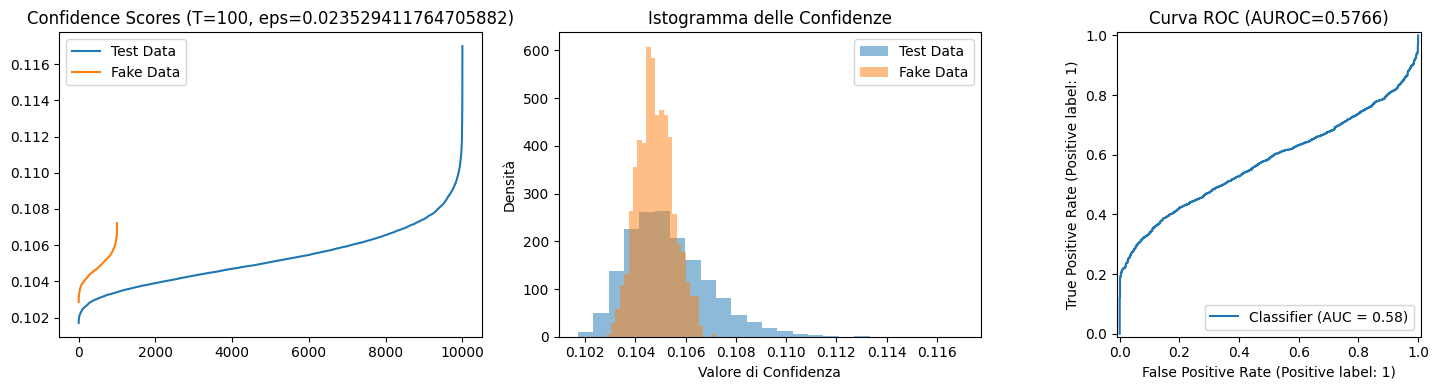


--- Testing T=100, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5177


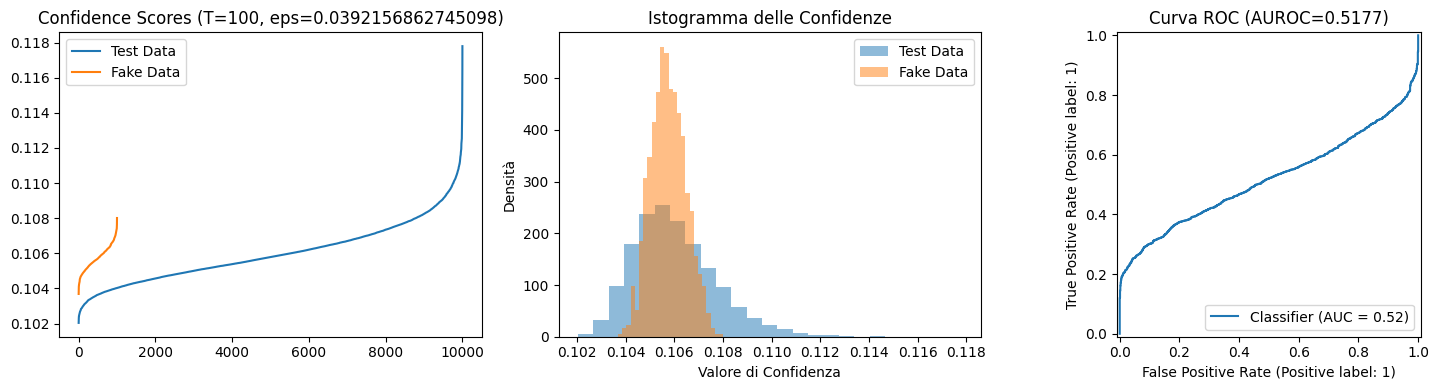


--- Testing T=1000, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6651


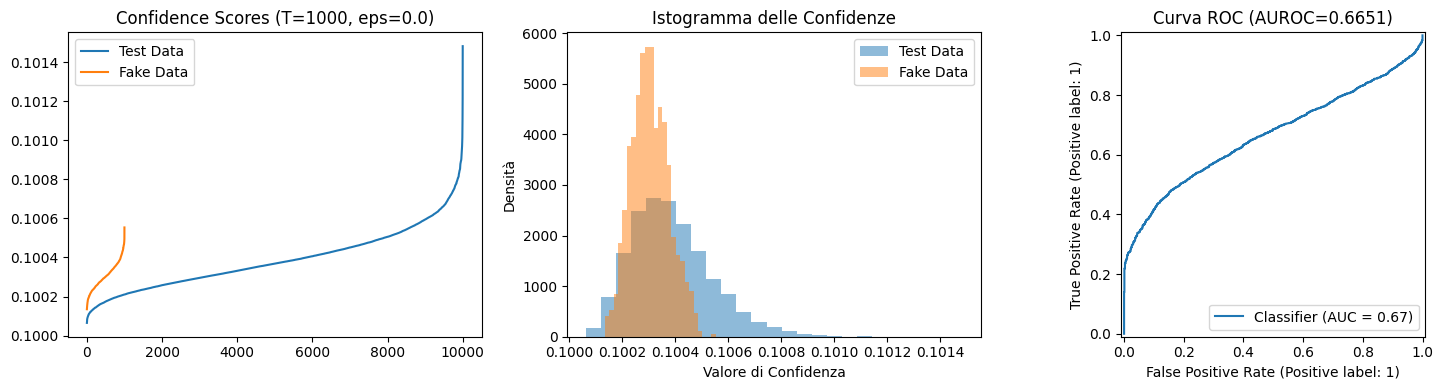


--- Testing T=1000, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6538


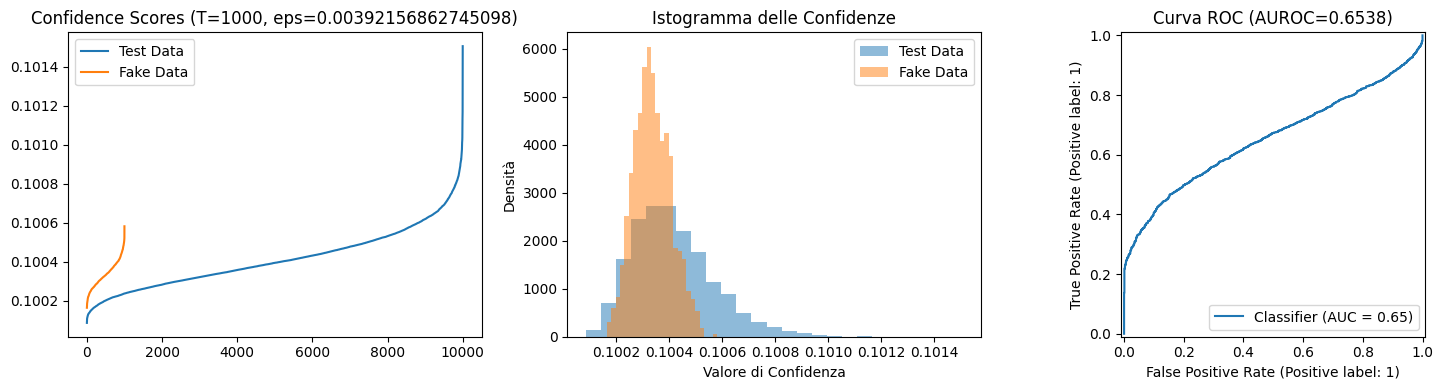


--- Testing T=1000, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6408


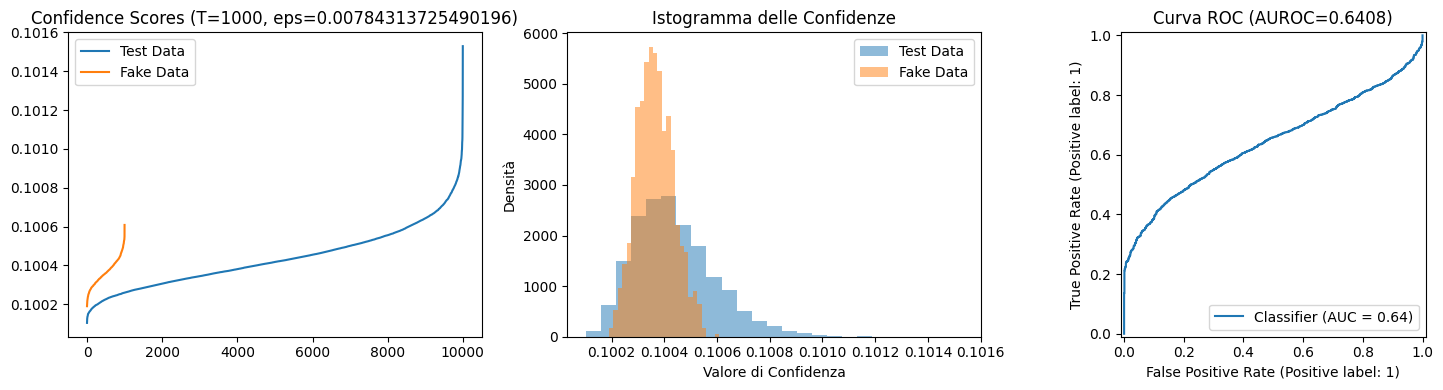


--- Testing T=1000, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6117


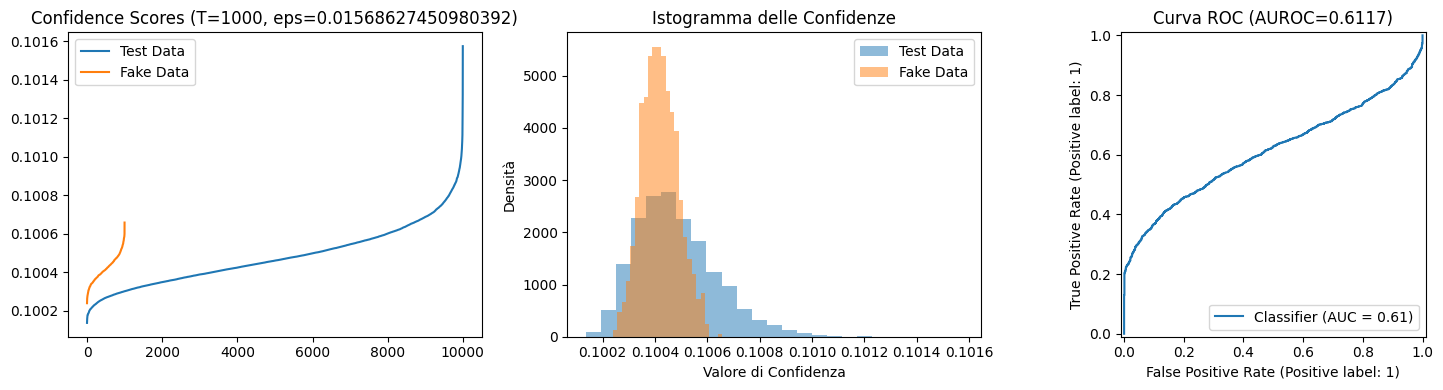


--- Testing T=1000, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5964


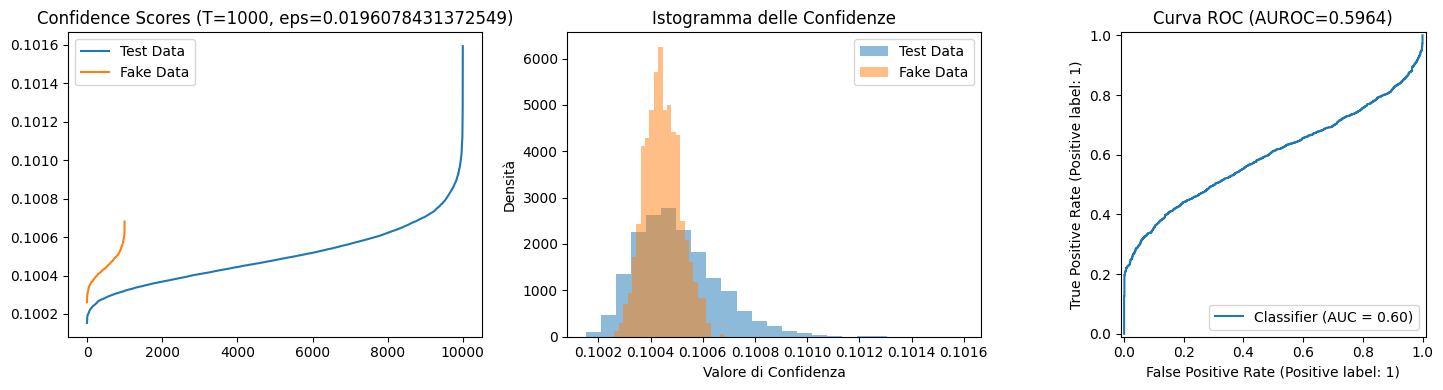


--- Testing T=1000, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5810


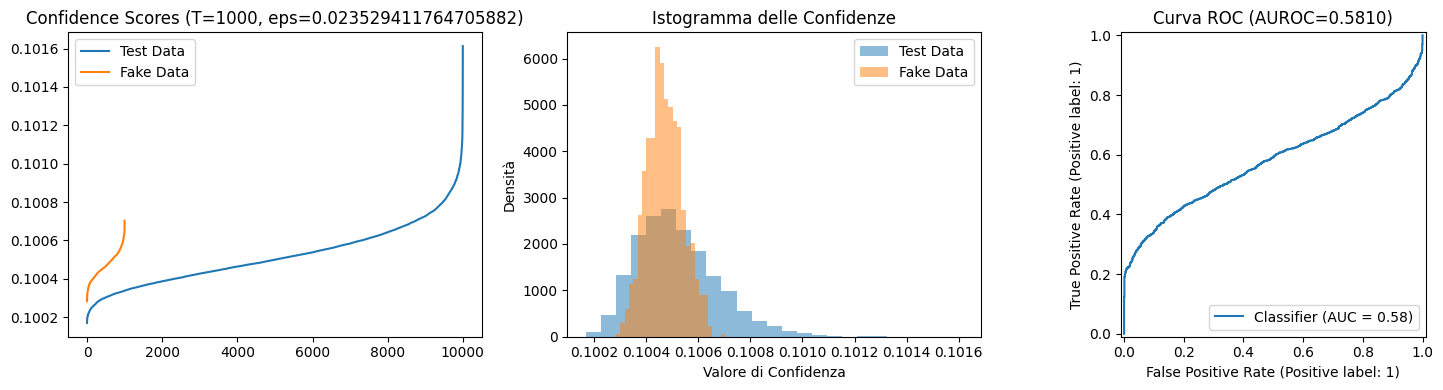


--- Testing T=1000, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5225


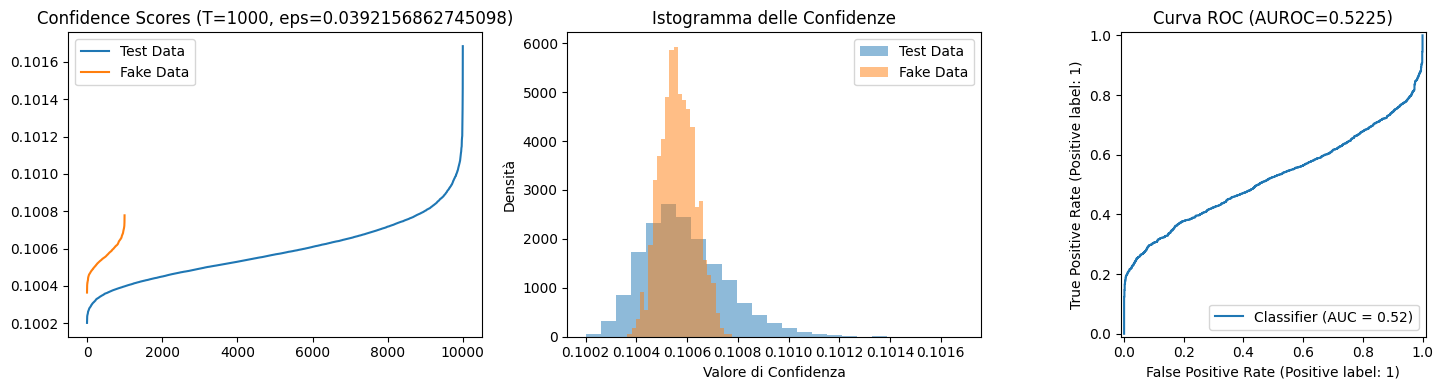

       T       eps     AUROC
0      1  0.000000  0.414014
1      1  0.003922  0.382092
2      1  0.007843  0.354822
3      1  0.015686  0.314867
4      1  0.019608  0.300875
5      1  0.023529  0.289841
6      1  0.039216  0.265351
7     10  0.000000  0.633222
8     10  0.003922  0.618442
9     10  0.007843  0.602071
10    10  0.015686  0.567371
11    10  0.019608  0.549942
12    10  0.023529  0.532804
13    10  0.039216  0.471823
14   100  0.000000  0.662307
15   100  0.003922  0.650687
16   100  0.007843  0.637345
17   100  0.015686  0.607758
18   100  0.019608  0.592212
19   100  0.023529  0.576594
20   100  0.039216  0.517702
21  1000  0.000000  0.665064
22  1000  0.003922  0.653753
23  1000  0.007843  0.640756
24  1000  0.015686  0.611701
25  1000  0.019608  0.596382
26  1000  0.023529  0.580983
27  1000  0.039216  0.522481


In [75]:
T_values = [1, 10, 100, 1000]
eps_values = [0.0, 1/255, 2/255, 4/255, 5/255, 6/255, 10/255]

# Lista per salvare i risultati
results = []

for T in T_values:
    for eps in eps_values:
        print(f"\n--- Testing T={T}, eps={eps} ---")

        scores_test = odin_scores(model, testloader, T=T, eps=eps)
        scores_fake = odin_scores(model, fakeloader, T=T, eps=eps)

        # Concatenazione per AUROC
        ypred = torch.cat((scores_test, scores_fake))
        y_test = torch.ones_like(scores_test)
        y_fake = torch.zeros_like(scores_fake)
        y = torch.cat((y_test, y_fake))

        auroc = roc_auc_score(
            y.detach().cpu().numpy(),
            ypred.detach().cpu().numpy()
        )

        # Salvataggio dei risultati
        results.append({"T": T, "eps": eps, "AUROC": auroc})
        print(f"AUROC = {auroc:.4f}")

        # Grafici diagnostici
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        # 1. Scatter ordinato
        axs[0].plot(sorted(scores_test.cpu()), label='Test Data')
        axs[0].plot(sorted(scores_fake.cpu()), label='Fake Data')
        axs[0].set_title(f"Confidence Scores (T={T}, eps={eps})")
        axs[0].legend()

        # 2. Istogramma densità
        axs[1].hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label='Test Data')
        axs[1].hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label='Fake Data')
        axs[1].set_xlabel('Valore di Confidenza')
        axs[1].set_ylabel('Densità')
        axs[1].set_title('Istogramma delle Confidenze')
        axs[1].legend()

        # 3. Curva ROC con AUC
        metrics.RocCurveDisplay.from_predictions(
            y.detach().cpu().numpy(),
            ypred.detach().cpu().numpy(),
            ax=axs[2]
        )
        axs[2].set_title(f'Curva ROC (AUROC={auroc:.4f})')

        plt.tight_layout()
        plt.show()

# Conversione a DataFrame per analisi successive
df_results = pd.DataFrame(results)
print(df_results)

T             1         10        100       1000
eps                                             
0.000000  0.414014  0.633222  0.662307  0.665064
0.003922  0.382092  0.618442  0.650687  0.653753
0.007843  0.354822  0.602071  0.637345  0.640756
0.015686  0.314867  0.567371  0.607758  0.611701
0.019608  0.300875  0.549942  0.592212  0.596382
0.023529  0.289841  0.532804  0.576594  0.580983
0.039216  0.265351  0.471823  0.517702  0.522481


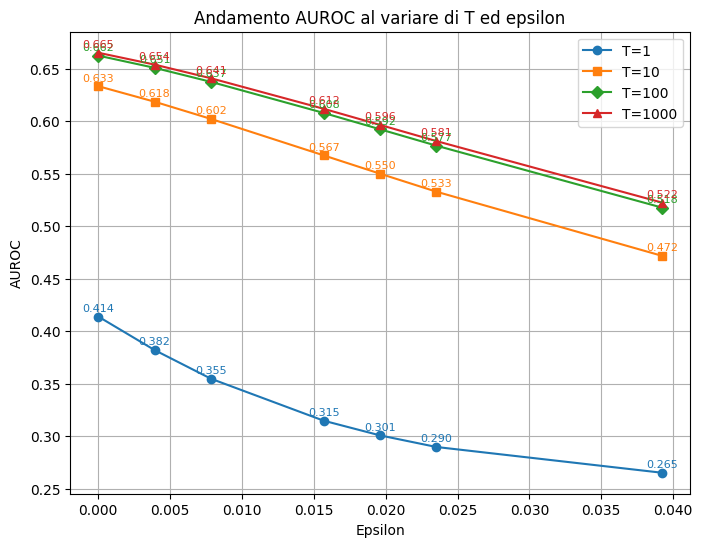

In [76]:
print(df_results.pivot(index="eps", columns="T", values="AUROC"))
markers = ["o", "s", "D", "^"]  # marker diversi per ogni T
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

plt.figure(figsize=(8,6))
for i, T in enumerate(T_values):
    subset = df_results[df_results["T"] == T]
    plt.plot(subset["eps"], subset["AUROC"],
             marker=markers[i], color=colors[i],
             label=f"T={T}")
    # aggiungi etichette numeriche sui punti
    for x, y in zip(subset["eps"], subset["AUROC"]):
        plt.text(x, y+0.005, f"{y:.3f}", ha="center", fontsize=8, color=colors[i])

plt.xlabel("Epsilon")
plt.ylabel("AUROC")
plt.title("Andamento AUROC al variare di T ed epsilon")
plt.legend()
plt.grid(True)
plt.show()

# Modello pre-trainato ma senza train aggiuntivo con fgsm data aug

In [77]:
model_try = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model_try.to(device)
model_try.eval()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias


--- Testing T=1, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6318


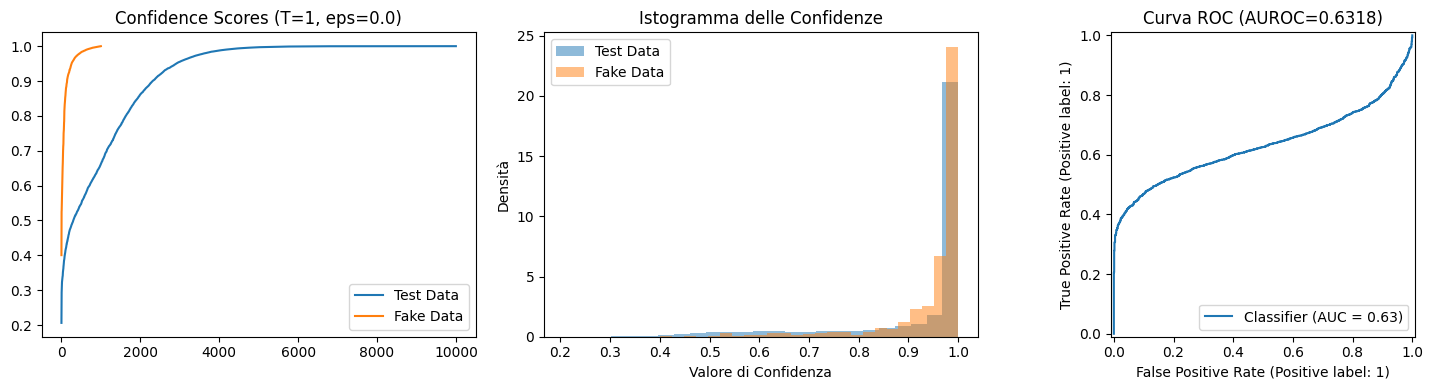


--- Testing T=1, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8831


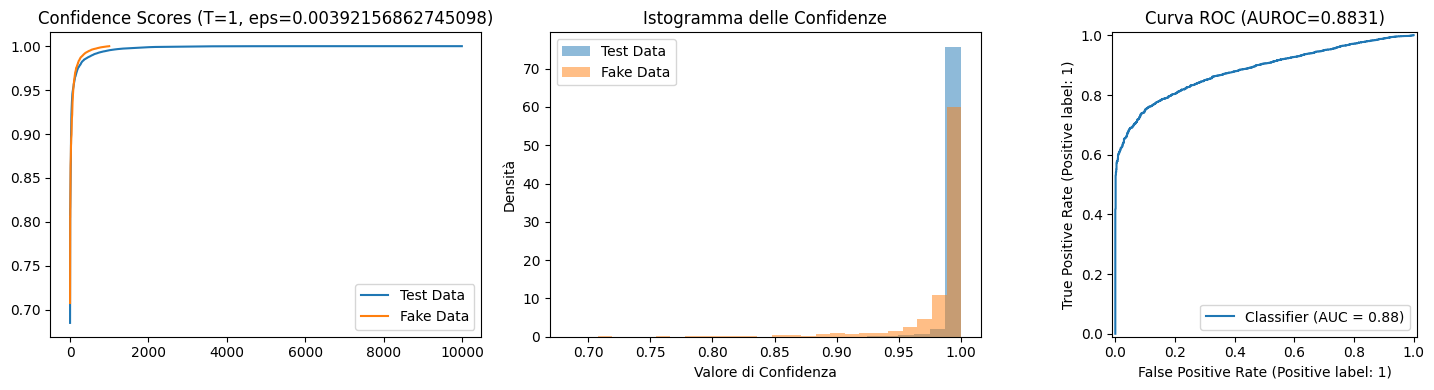


--- Testing T=1, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9296


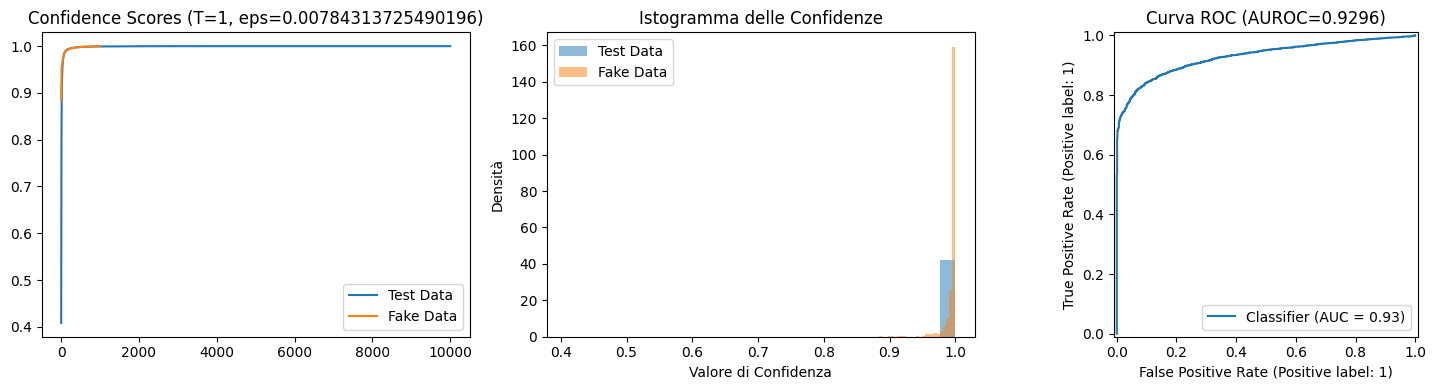


--- Testing T=1, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9005


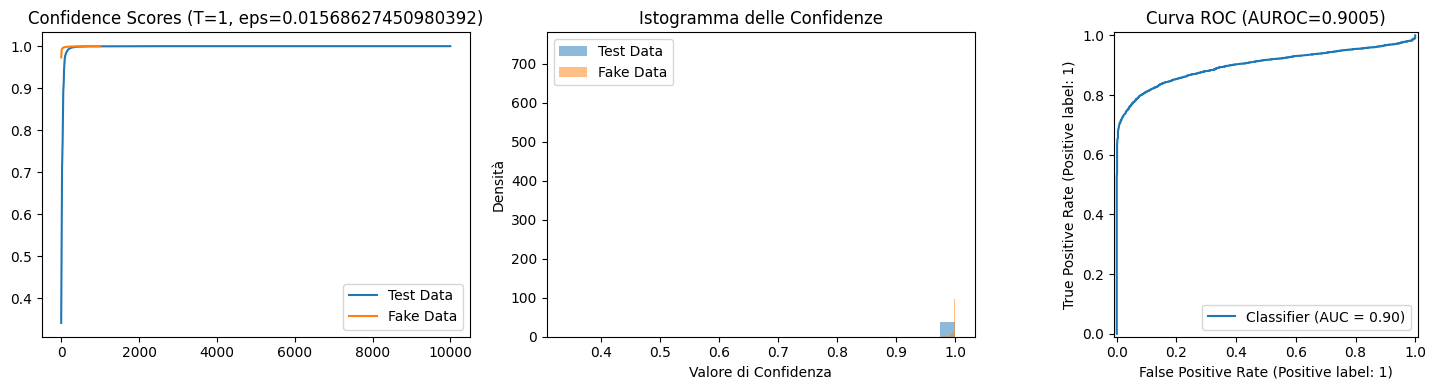


--- Testing T=1, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8601


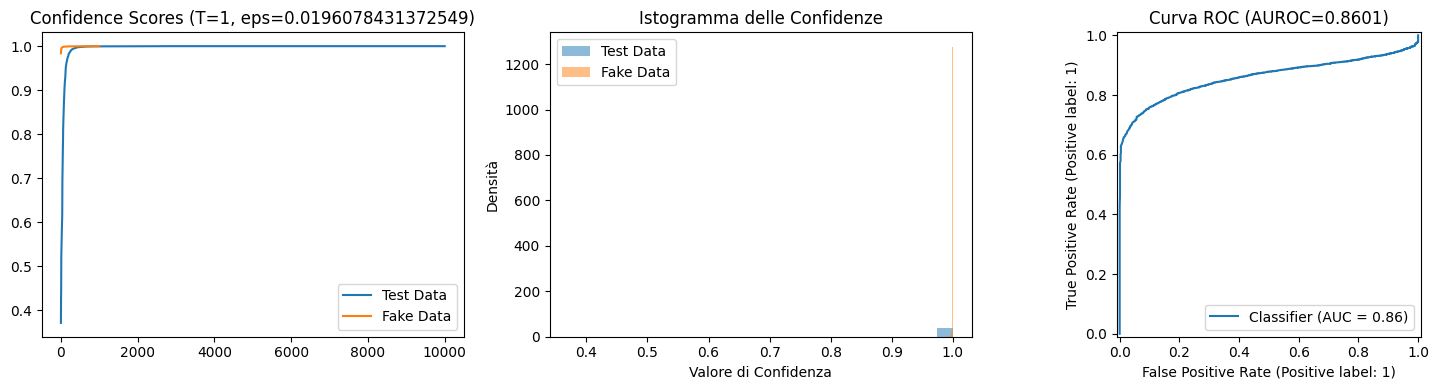


--- Testing T=1, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8065


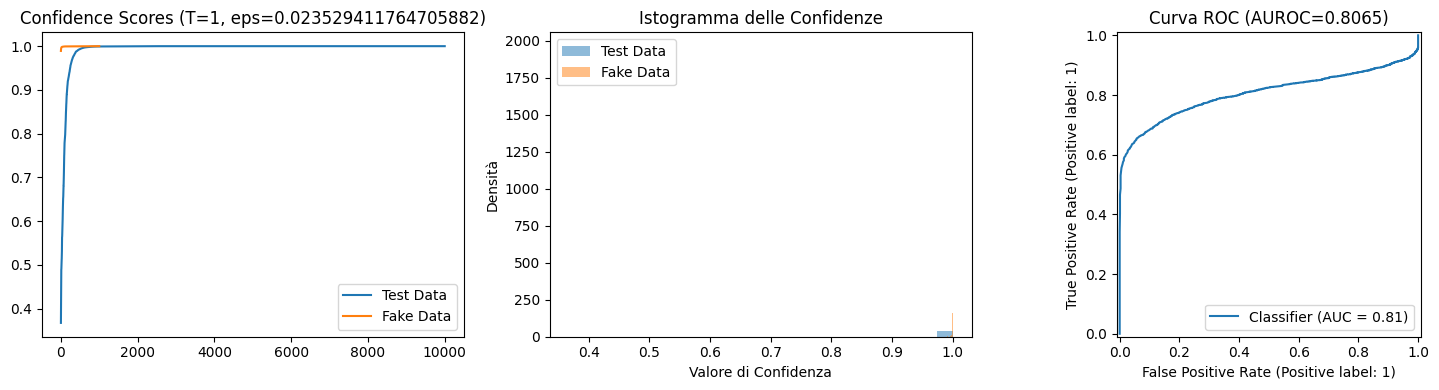


--- Testing T=1, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5257


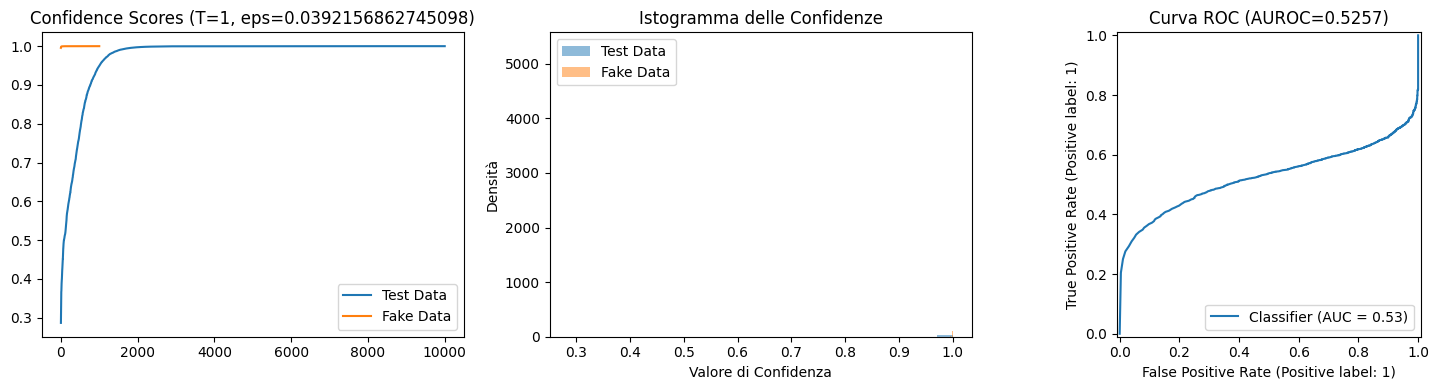


--- Testing T=10, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6213


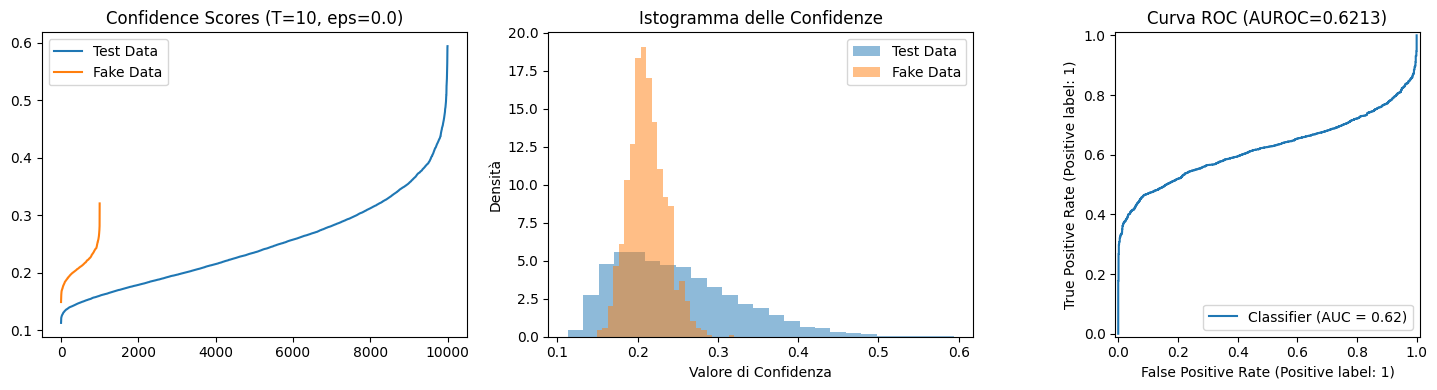


--- Testing T=10, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8563


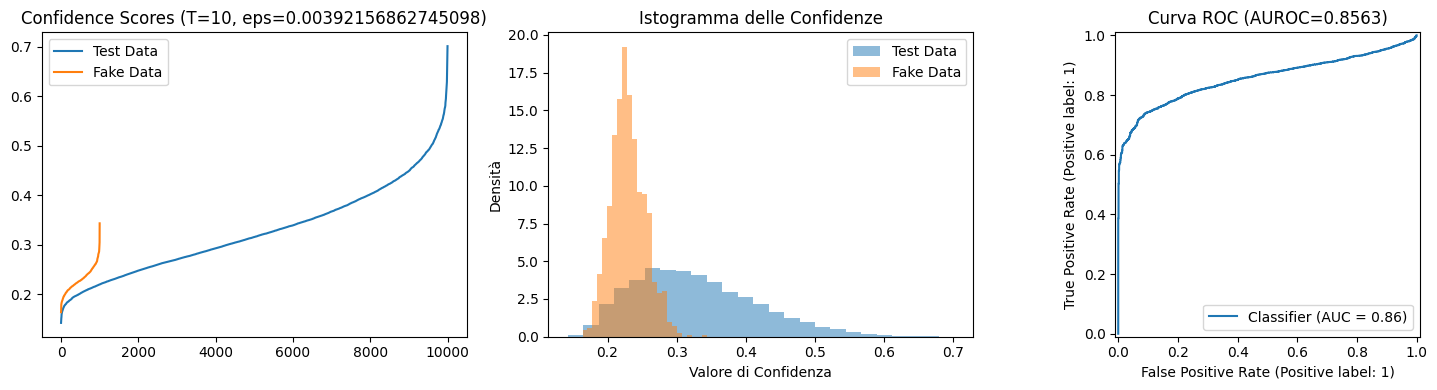


--- Testing T=10, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9234


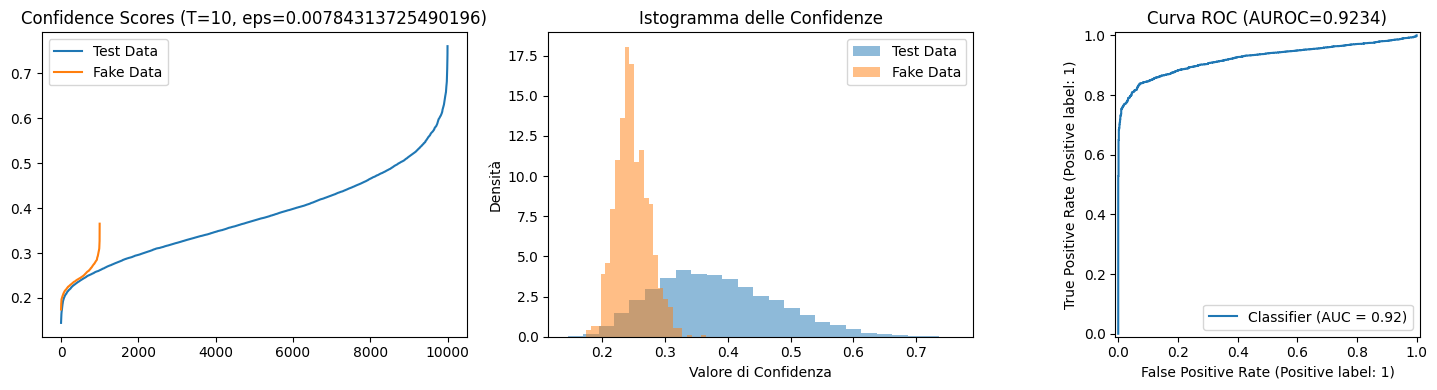


--- Testing T=10, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9207


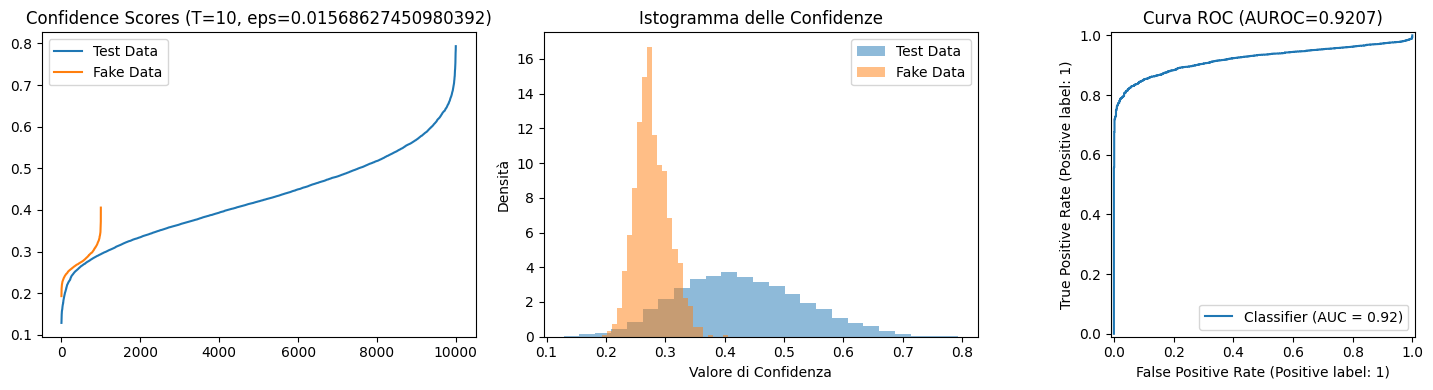


--- Testing T=10, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8919


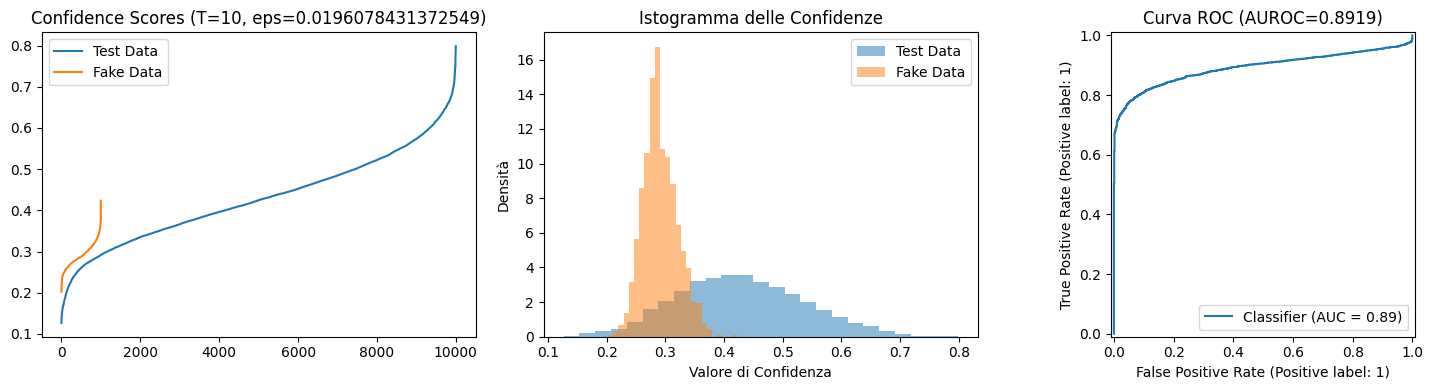


--- Testing T=10, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8466


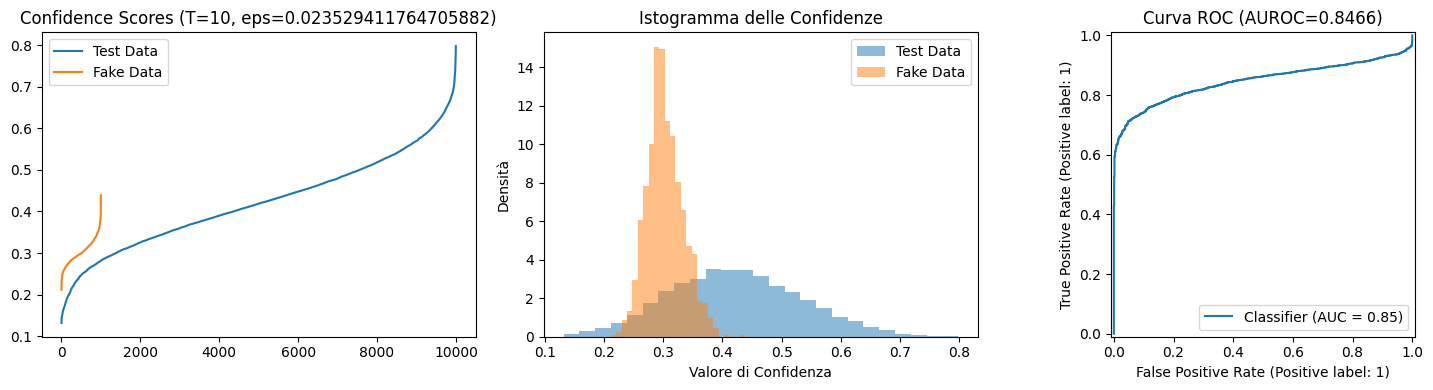


--- Testing T=10, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5688


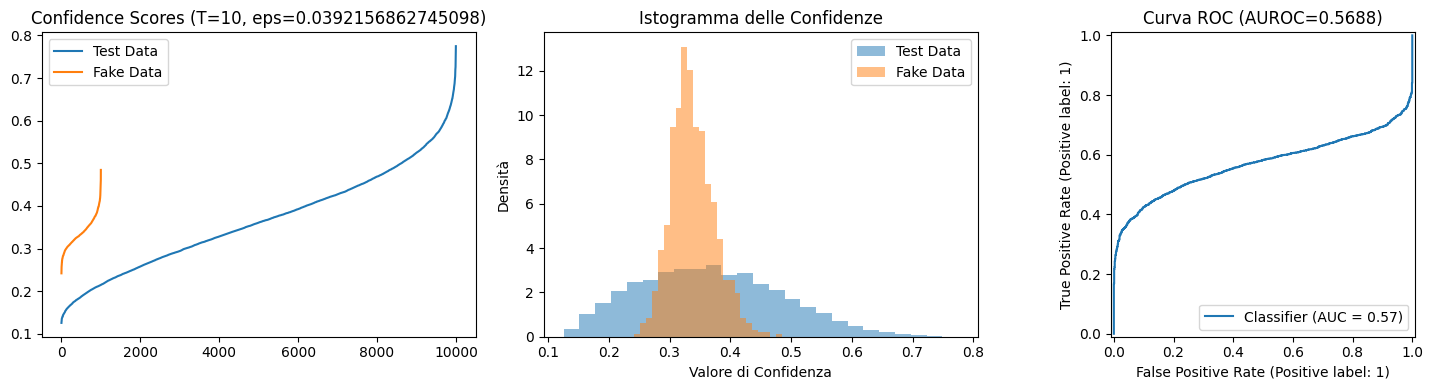


--- Testing T=100, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6216


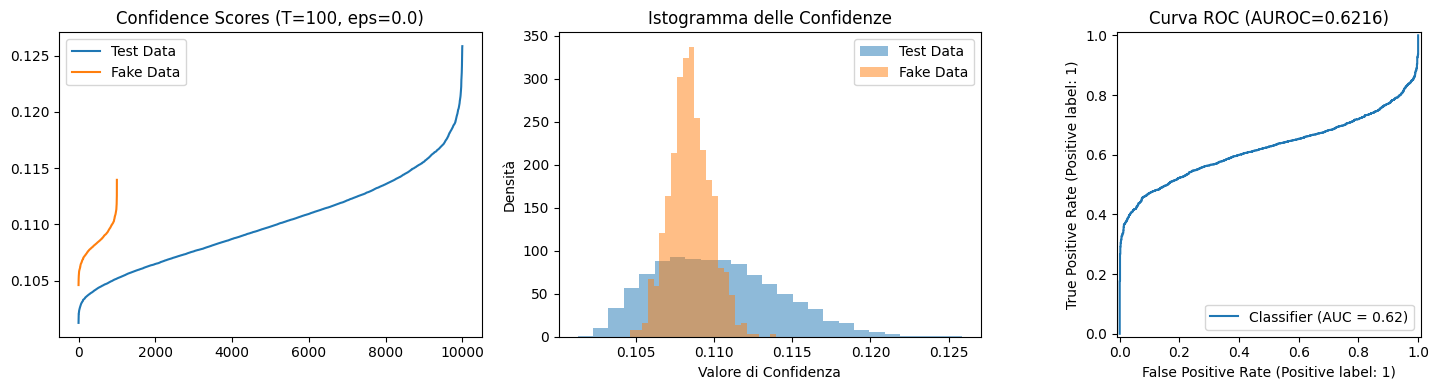


--- Testing T=100, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8536


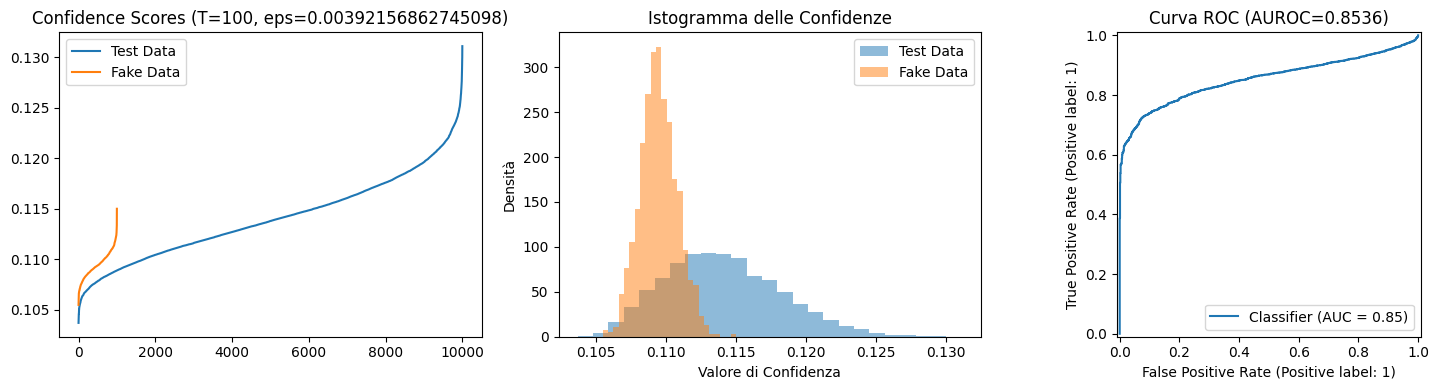


--- Testing T=100, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9216


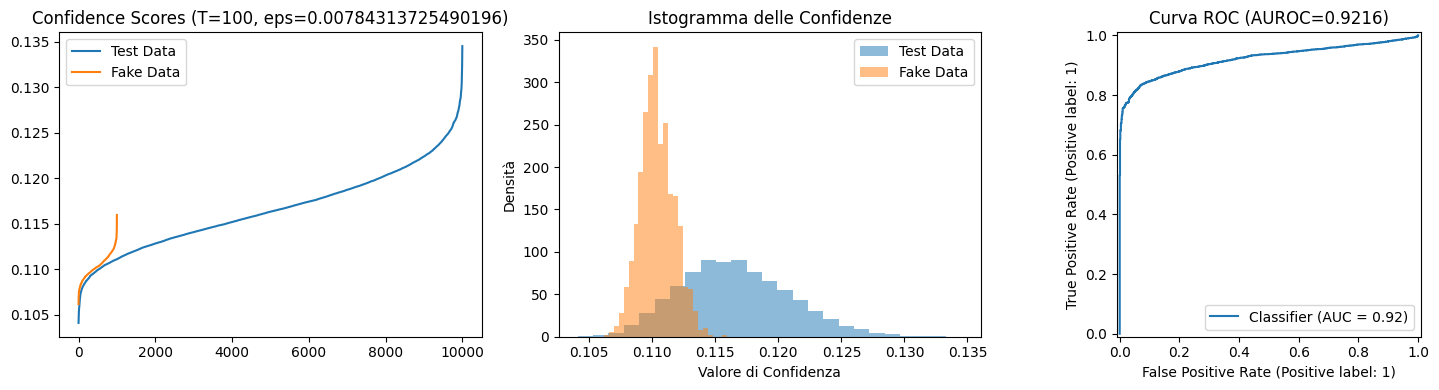


--- Testing T=100, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9202


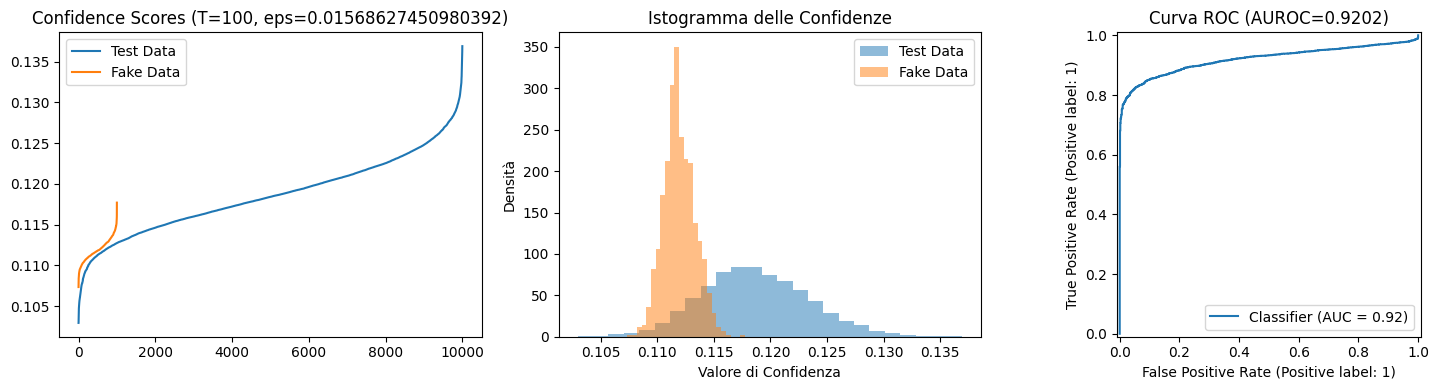


--- Testing T=100, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8924


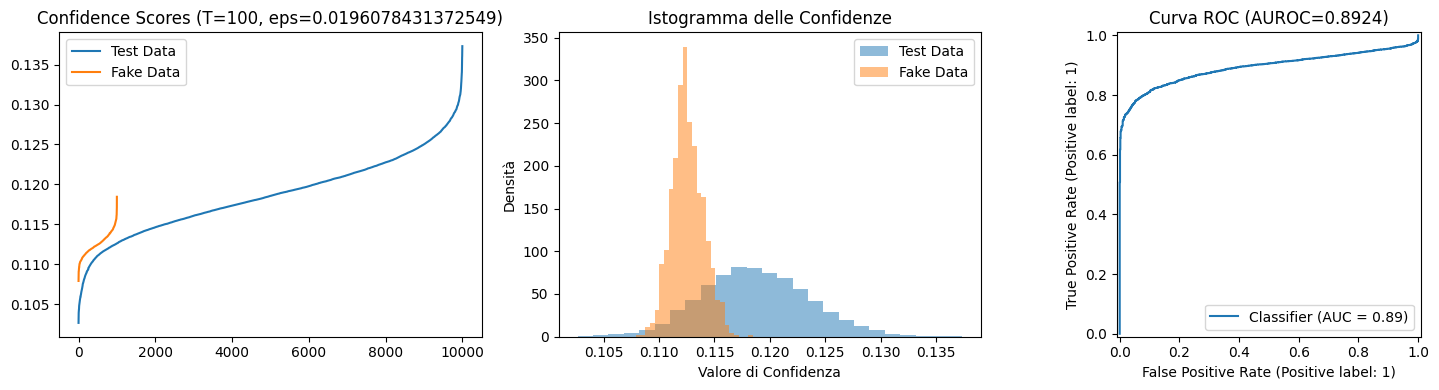


--- Testing T=100, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8480


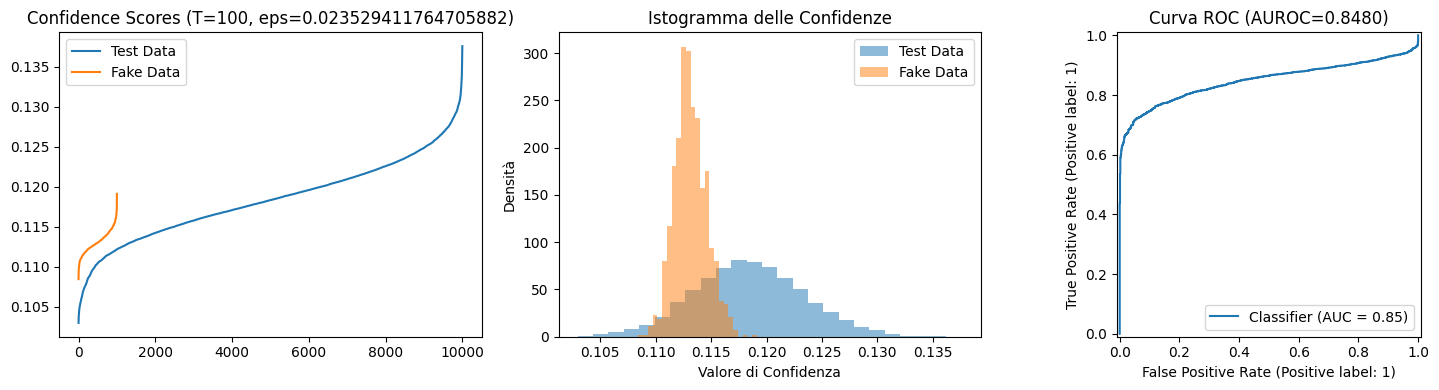


--- Testing T=100, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5726


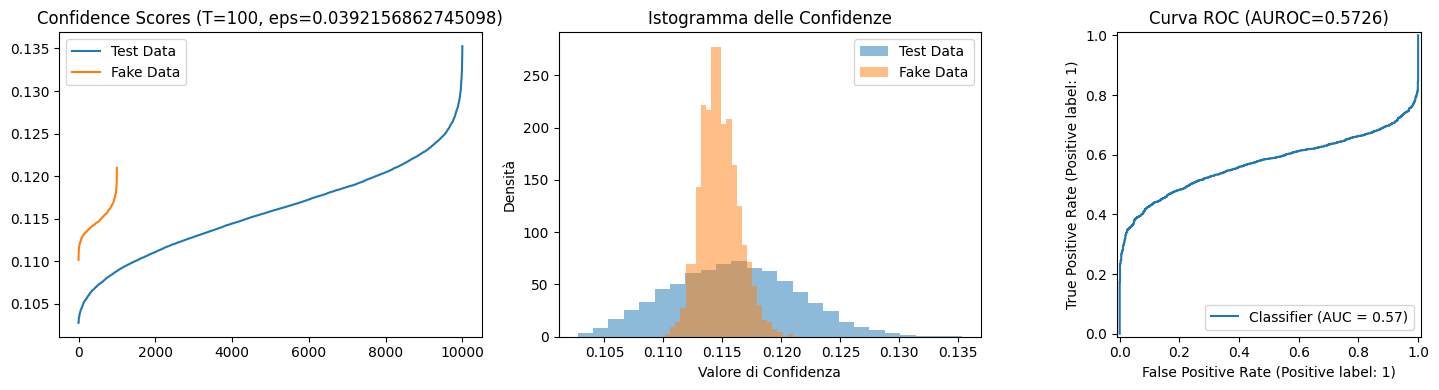


--- Testing T=1000, eps=0.0 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.6216


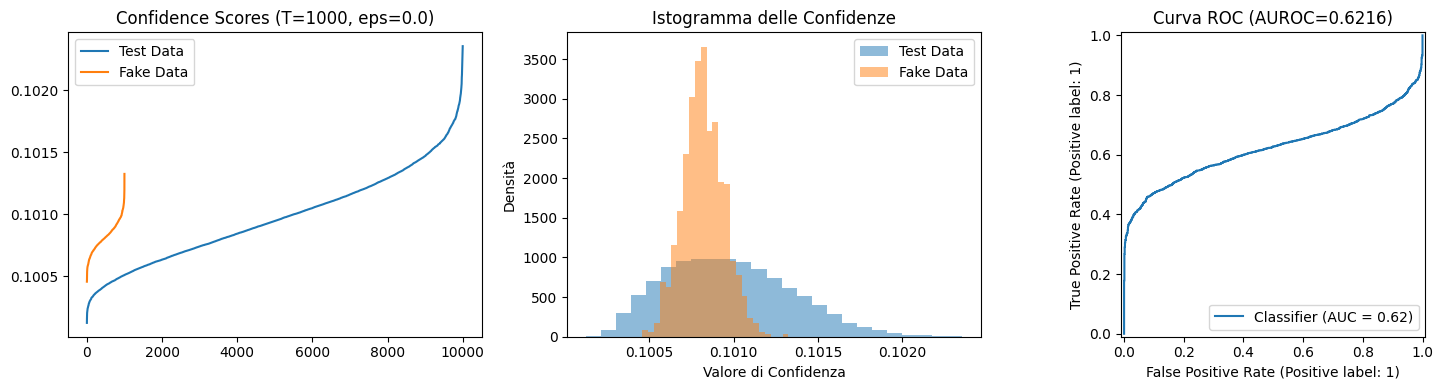


--- Testing T=1000, eps=0.00392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8534


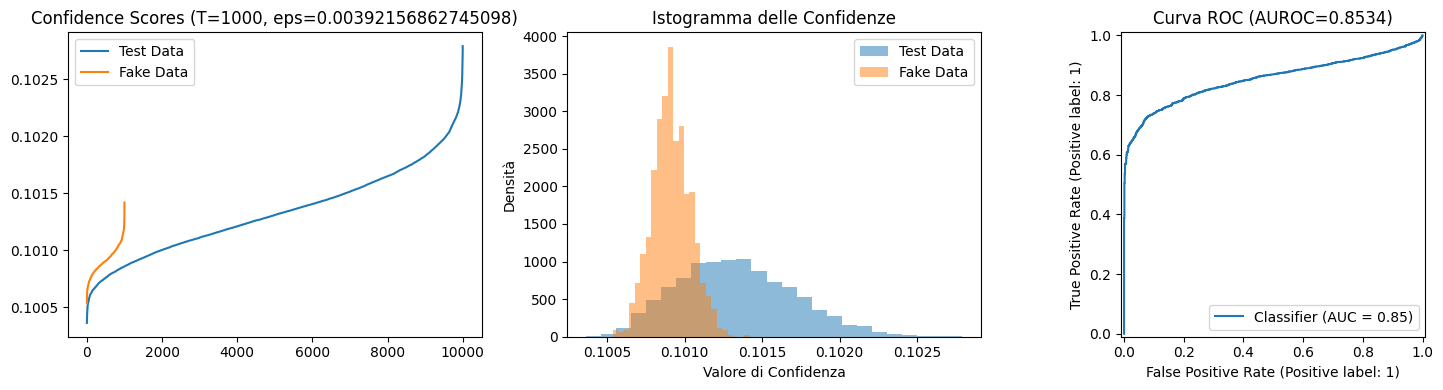


--- Testing T=1000, eps=0.00784313725490196 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9215


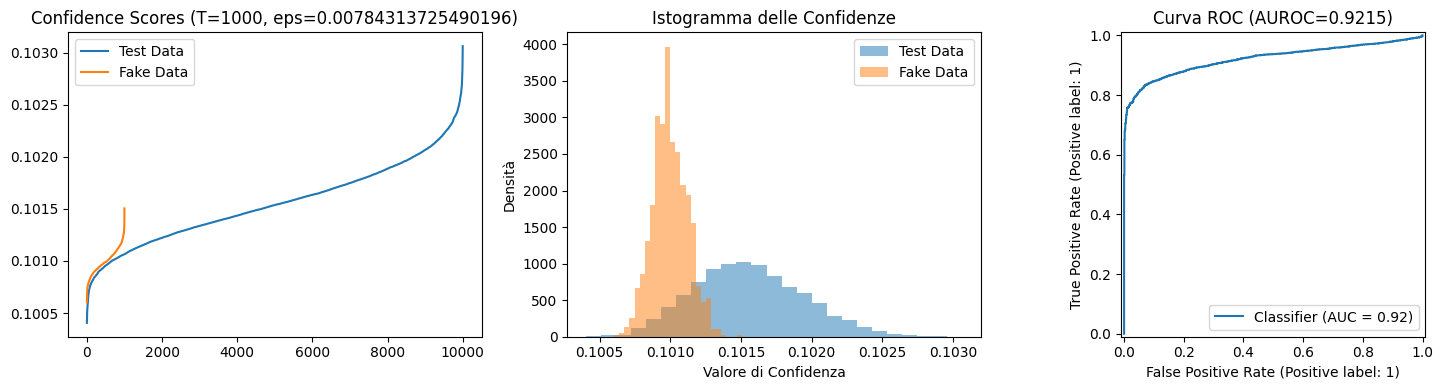


--- Testing T=1000, eps=0.01568627450980392 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.9202


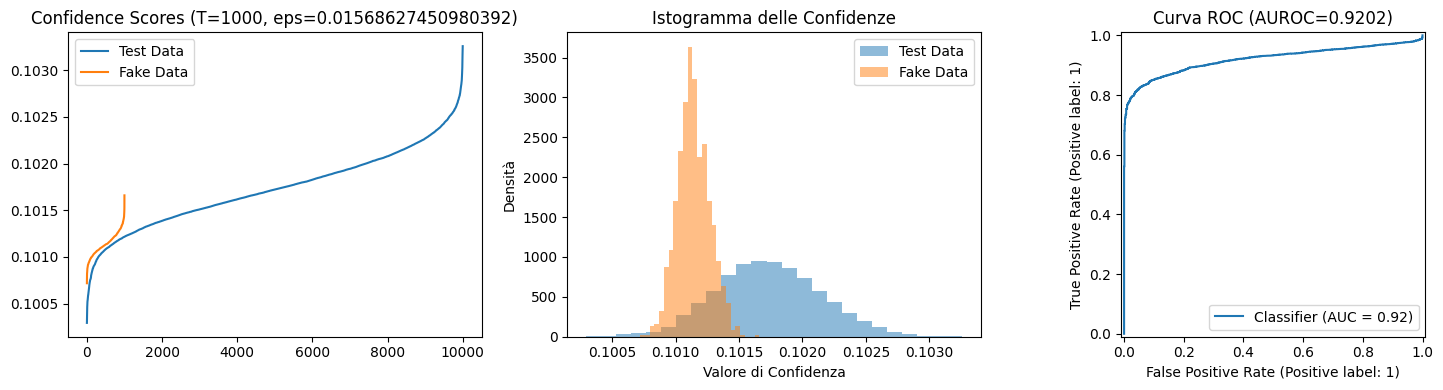


--- Testing T=1000, eps=0.0196078431372549 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8925


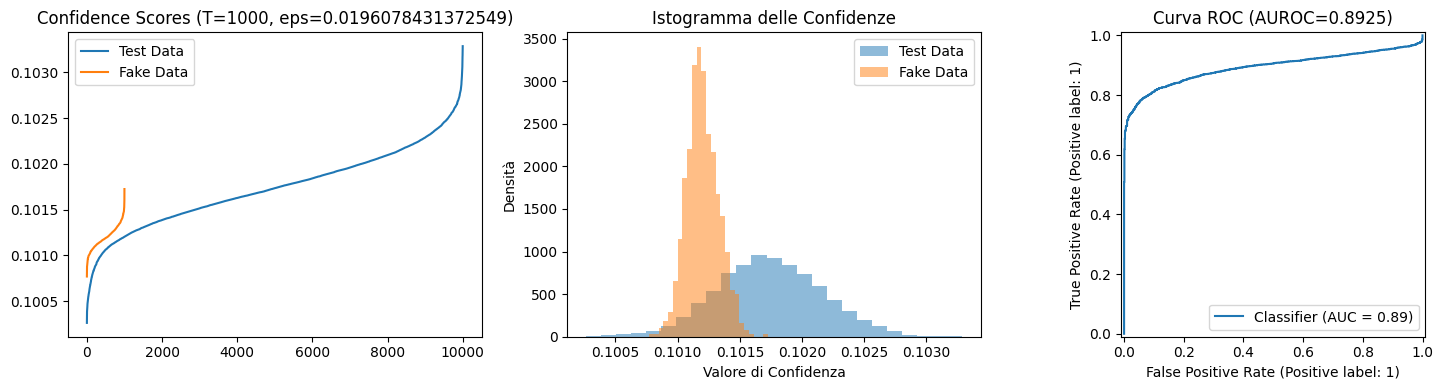


--- Testing T=1000, eps=0.023529411764705882 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.8481


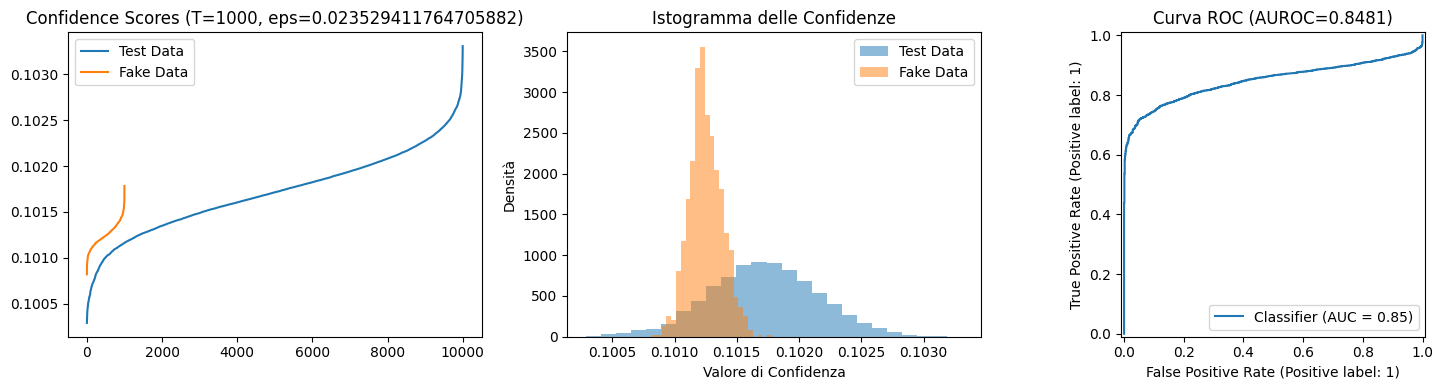


--- Testing T=1000, eps=0.0392156862745098 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC = 0.5728


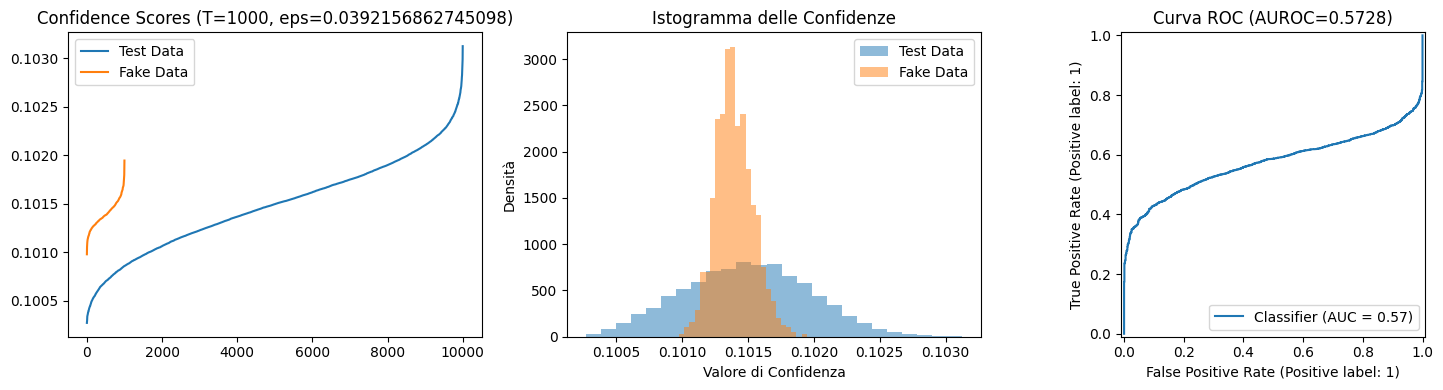

       T       eps     AUROC
0      1  0.000000  0.631797
1      1  0.003922  0.883138
2      1  0.007843  0.929626
3      1  0.015686  0.900511
4      1  0.019608  0.860135
5      1  0.023529  0.806521
6      1  0.039216  0.525699
7     10  0.000000  0.621297
8     10  0.003922  0.856334
9     10  0.007843  0.923397
10    10  0.015686  0.920651
11    10  0.019608  0.891941
12    10  0.023529  0.846623
13    10  0.039216  0.568841
14   100  0.000000  0.621569
15   100  0.003922  0.853637
16   100  0.007843  0.921622
17   100  0.015686  0.920202
18   100  0.019608  0.892418
19   100  0.023529  0.847982
20   100  0.039216  0.572601
21  1000  0.000000  0.621587
22  1000  0.003922  0.853419
23  1000  0.007843  0.921480
24  1000  0.015686  0.920185
25  1000  0.019608  0.892482
26  1000  0.023529  0.848085
27  1000  0.039216  0.572835


In [79]:
T_values = [1, 10, 100, 1000]
eps_values = [0.0, 1/255, 2/255, 4/255, 5/255, 6/255, 10/255]

# Lista per salvare i risultati
results = []

for T in T_values:
    for eps in eps_values:
        print(f"\n--- Testing T={T}, eps={eps} ---")

        scores_test = odin_scores(model_try, testloader, T=T, eps=eps)
        scores_fake = odin_scores(model_try, fakeloader, T=T, eps=eps)

        # Concatenazione per AUROC
        ypred = torch.cat((scores_test, scores_fake))
        y_test = torch.ones_like(scores_test)
        y_fake = torch.zeros_like(scores_fake)
        y = torch.cat((y_test, y_fake))

        auroc = roc_auc_score(
            y.detach().cpu().numpy(),
            ypred.detach().cpu().numpy()
        )

        # Salvataggio dei risultati
        results.append({"T": T, "eps": eps, "AUROC": auroc})
        print(f"AUROC = {auroc:.4f}")

        # Grafici diagnostici
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        # 1. Scatter ordinato
        axs[0].plot(sorted(scores_test.cpu()), label='Test Data')
        axs[0].plot(sorted(scores_fake.cpu()), label='Fake Data')
        axs[0].set_title(f"Confidence Scores (T={T}, eps={eps})")
        axs[0].legend()

        # 2. Istogramma densità
        axs[1].hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label='Test Data')
        axs[1].hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label='Fake Data')
        axs[1].set_xlabel('Valore di Confidenza')
        axs[1].set_ylabel('Densità')
        axs[1].set_title('Istogramma delle Confidenze')
        axs[1].legend()

        # 3. Curva ROC con AUC
        metrics.RocCurveDisplay.from_predictions(
            y.detach().cpu().numpy(),
            ypred.detach().cpu().numpy(),
            ax=axs[2]
        )
        axs[2].set_title(f'Curva ROC (AUROC={auroc:.4f})')

        plt.tight_layout()
        plt.show()

# Conversione a DataFrame per analisi successive
df_results = pd.DataFrame(results)
print(df_results)

T             1         10        100       1000
eps                                             
0.000000  0.631797  0.621297  0.621569  0.621587
0.003922  0.883138  0.856334  0.853637  0.853419
0.007843  0.929626  0.923397  0.921622  0.921480
0.015686  0.900511  0.920651  0.920202  0.920185
0.019608  0.860135  0.891941  0.892418  0.892482
0.023529  0.806521  0.846623  0.847982  0.848085
0.039216  0.525699  0.568841  0.572601  0.572835


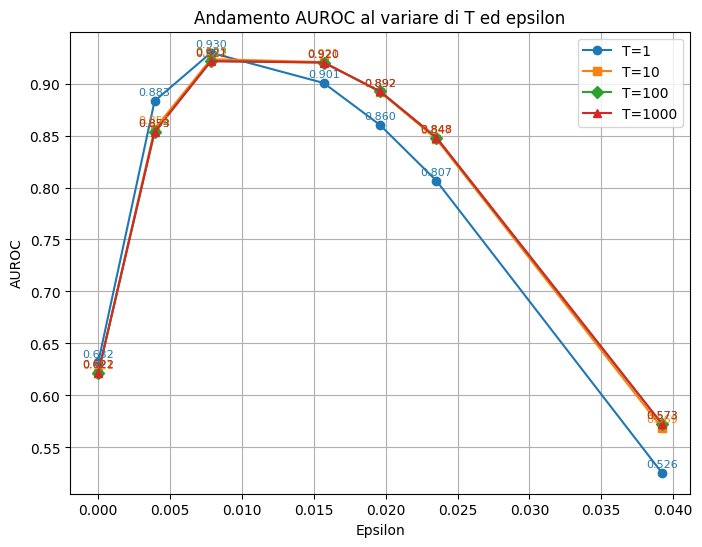

In [80]:
print(df_results.pivot(index="eps", columns="T", values="AUROC"))
markers = ["o", "s", "D", "^"]  # marker diversi per ogni T
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

plt.figure(figsize=(8,6))
for i, T in enumerate(T_values):
    subset = df_results[df_results["T"] == T]
    plt.plot(subset["eps"], subset["AUROC"],
             marker=markers[i], color=colors[i],
             label=f"T={T}")
    # aggiungi etichette numeriche sui punti
    for x, y in zip(subset["eps"], subset["AUROC"]):
        plt.text(x, y+0.005, f"{y:.3f}", ha="center", fontsize=8, color=colors[i])

plt.xlabel("Epsilon")
plt.ylabel("AUROC")
plt.title("Andamento AUROC al variare di T ed epsilon")
plt.legend()
plt.grid(True)
plt.show()